In [252]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# pre-processing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans

# ml algos
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

In [262]:
pip install gitpython

Note: you may need to restart the kernel to use updated packages.


In [253]:
df = pd.read_csv('processed_data/df.csv').iloc[:, 1:]

In [259]:
# checking once again to see that null values are gone
df.isna().sum()

user_id                               0
number_of_cards                       0
outstanding                           0
credit_limit                          0
bill                                  0
total_cash_usage                      0
total_retail_usage                    0
remaining_bill                        0
branch_code                           0
payment_ratio                         0
overlimit_percentage                  0
payment_ratio_3month                  0
payment_ratio_6month                  0
delinquency_score                     0
default_flag                          0
years_since_card_issuing              0
total_usage                           0
remaining_bill_per_number_of_cards    0
remaining_bill_per_limit              0
total_usage_per_limit                 0
total_3mo_usage_per_limit             0
utilization_3month                    0
remaining_bill_over_outstanding       1
total_card_usage                      0
limit_per_card                        0


# Feature Engineering

As mentioned previously, correlation analysis and other EDA generated ideas to create features that highlight overdrawing and overleveraged behaviour. We create those features here

Further, we also perform Kmeans clustering, after identifying the optimal number of clusters, to add potentially useful indicators for the model

In [255]:
df['remaining_bill_over_outstanding'] = df['remaining_bill']/df['outstanding']
df['total_card_usage'] = df['total_usage'] - df['total_cash_usage']
df['limit_per_card'] = df['credit_limit']/df['number_of_cards']
df['outstanding_per_card_limit'] = df['outstanding']/ (df['credit_limit']/df['number_of_cards'])

In [224]:
# one of our feature engineering steps generates an 'inf' value, so we replace it with a nan, and impute a value for that value
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
def impute_miss_data(df, excepted_columns = 'None'): 
    """
    Clean DataFrame

    # Arguments
        df: DataFrame containing the independent variables.
        expected_columns: columns to be excepted from imputation
        
    # Returns
        df: DataFrame with data imputed
    """
    if excepted_columns!= 'None':
    
        excepted_df = df[excepted_columns]
    
        df = df.drop(columns = [excepted_columns])
    
    df_num = df.select_dtypes(exclude='object').columns
    df_cat = df.select_dtypes(include='object').columns

    # fill missing values for numerical variables
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer = imputer.fit(df.loc[:, df_num])
    df.loc[:, df_num] = imputer.transform(df.loc[:, df_num])

    # fill missing values for categorical variables
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = imputer.fit(df.loc[:, df_cat])
    df.loc[:, df_cat] = imputer.transform(df.loc[:, df_cat])
    
    if excepted_columns!= 'None':
        df = pd.concat([df, excepted_df], axis = 1)
    
    return df

In [10]:
df = impute_miss_data(df)

In [260]:
# Feature Engineer 2: Kmeans Clustering

In [11]:
branch_code = df['branch_code']
default_flag = df['default_flag']

In [12]:
# dropping our target variable and the single categorical to allow for kmeans clustering (which works best with numericals)
df2 = df.drop(columns = ['user_id', 'default_flag', 'branch_code'])

# kmeans clustering works on euclidean distance, so we must scale the dataset
sc = StandardScaler()
X = sc.fit_transform(df2)

In [15]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


the optimal k value is 3

In [17]:
km = KMeans(n_clusters=3, random_state = 42).fit(X)

In [225]:
df['clusters'] = km.labels_

In [226]:
# Feature Engineering 3: One hot encoding for our single categorical variable

X = df.drop(columns = ['default_flag', 'user_id'])
X = pd.get_dummies(X, columns = ['branch_code'])
orig_columns = X.columns

X = sc.fit_transform(X)

# Preparing Analytical Model

In [227]:
y = df['default_flag']

In [228]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify = y)

# Over and Undersampling for Imbalanced Dataset

Now, as we are dealing with an unbalanced data set, we'll standardize and resample the training set with RandomUnderSampler

Initially I had experimented with different combinations of over and under sampling and different sampling_strategy values. However, while over-sampling improved results on the train set, it had marginal impact on the test set. Oversampling has a higher risk of creating variance error than undersampling with unseen test sets as it produces synthetic data points which may not recur in real life. 

Therefore, I elected to proceed only with undersampling. 

In [23]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
under = RandomUnderSampler(sampling_strategy=0.15)

In [24]:
from imblearn.pipeline import Pipeline
#steps = [('o', over), ('u', under)]
steps = [('u', under)]
pipeline = Pipeline(steps=steps)

# Defining a second train-test set with undersampled negative cases. 
# For later comparison of model performance between the natural and undersampled test sets
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [25]:
y_train2.value_counts()

0.0    7553
1.0    1133
Name: default_flag, dtype: int64

# Model Selection

We will use cross-validation to assist us in model selection. Instead of simply splitting the data into a train and test set, the cross_validate method splits our training data into k number of Folds, making better use of the data. In our case, we'll perform 5-fold cross-validation, as we let the default k value.

Our eventual decision will be based on the performance on several metrics - F1, Precision, Recall, and ROC-AUC. If performance is uneven, we must later make a choice about which metric to prioritise. 

In [166]:
# define the function val_model
def val_model(X, y, clf):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    f1_scores = cross_val_score(pipeline, X, y, scoring='f1')
    precision = cross_val_score(pipeline, X, y, scoring='precision')
    recall = cross_val_score(pipeline, X, y, scoring='recall')
    auc = cross_val_score(pipeline, X, y, scoring='roc_auc')

    #if show == True:
    #    print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return f1_scores.mean(), precision.mean(), recall.mean(), auc.mean()

In [178]:
# I picked a range of classifiers (including versions of randomforest from the imbalanced-ml package)
# Ranging from the simple KNN classifier to powerful classifiers like XGboost and CatBoost

def evaluate_models(X,y):
    
    """
    Evaluate the performance of various classifiers on the input dataset

    # Arguments
        X: DataFrame containing independent X variables
        y: Series containing y target variable
        
    # Returns
        results: DataFrame with each model's performance in f1-score, precision, recall, and roc_auc
    """
    
    easy = EasyEnsembleClassifier()
    balanced_rf = BalancedRandomForestClassifier()
    class_weighting_rf = RandomForestClassifier(class_weight = 'class_weight')
    bootstrap_rf = RandomForestClassifier(class_weight = 'balanced_subsample')
    knn = KNeighborsClassifier()
    rf =  RandomForestClassifier()
    xgb = XGBClassifier()
    lgb = LGBMClassifier()
    cb = CatBoostClassifier()
    
    model_names = ['easy', 'balanced', 'class_weighting_rf', 'bootstrap_rf', 'knn', 'rf', 'xgb', 'lgb', 'cb']
    model_list = []
    f1_scores_list = []
    precision_list = []
    recall_list = [] 
    roc_auc_list = []

    for clf in (easy, balanced, class_weighting_rf, bootstrap_rf, knn, rf, xgb, lgb, cb):
        model_list.append(clf.__class__.__name__)
        f1_scores, precision, recall, auc = val_model(X, y, clf)
        f1_scores_list.append(f1_scores)
        precision_list.append(precision)
        recall_list.append(recall)
        roc_auc_list.append(auc)
    
    results = pd.DataFrame({'model_list': model_list,
              'model_names': model_names,
             'f1_scores': f1_scores_list, 
             'precision': precision_list, 
             'recall' :recall_list, 
             'roc_auc_list': roc_auc_list})
    
    return results

In [179]:
original_data_results = evaluate_models(X_train, y_train)

[14:56:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:56:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:56:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

52:	learn: 0.2394156	total: 809ms	remaining: 14.5s
53:	learn: 0.2385468	total: 825ms	remaining: 14.5s
54:	learn: 0.2376689	total: 838ms	remaining: 14.4s
55:	learn: 0.2366179	total: 850ms	remaining: 14.3s
56:	learn: 0.2358419	total: 862ms	remaining: 14.3s
57:	learn: 0.2349020	total: 882ms	remaining: 14.3s
58:	learn: 0.2341711	total: 896ms	remaining: 14.3s
59:	learn: 0.2331321	total: 910ms	remaining: 14.3s
60:	learn: 0.2324315	total: 923ms	remaining: 14.2s
61:	learn: 0.2317821	total: 935ms	remaining: 14.1s
62:	learn: 0.2309400	total: 948ms	remaining: 14.1s
63:	learn: 0.2302258	total: 961ms	remaining: 14s
64:	learn: 0.2295181	total: 973ms	remaining: 14s
65:	learn: 0.2288031	total: 987ms	remaining: 14s
66:	learn: 0.2280002	total: 1.01s	remaining: 14s
67:	learn: 0.2273997	total: 1.02s	remaining: 14s
68:	learn: 0.2268542	total: 1.03s	remaining: 13.9s
69:	learn: 0.2262831	total: 1.04s	remaining: 13.9s
70:	learn: 0.2257245	total: 1.06s	remaining: 13.8s
71:	learn: 0.2253279	total: 1.08s	remaini

223:	learn: 0.1944643	total: 3.41s	remaining: 11.8s
224:	learn: 0.1942996	total: 3.43s	remaining: 11.8s
225:	learn: 0.1942151	total: 3.44s	remaining: 11.8s
226:	learn: 0.1940395	total: 3.46s	remaining: 11.8s
227:	learn: 0.1939150	total: 3.47s	remaining: 11.8s
228:	learn: 0.1938359	total: 3.49s	remaining: 11.7s
229:	learn: 0.1937139	total: 3.5s	remaining: 11.7s
230:	learn: 0.1936371	total: 3.51s	remaining: 11.7s
231:	learn: 0.1935162	total: 3.53s	remaining: 11.7s
232:	learn: 0.1934491	total: 3.54s	remaining: 11.6s
233:	learn: 0.1933909	total: 3.55s	remaining: 11.6s
234:	learn: 0.1932810	total: 3.56s	remaining: 11.6s
235:	learn: 0.1931331	total: 3.58s	remaining: 11.6s
236:	learn: 0.1930437	total: 3.59s	remaining: 11.6s
237:	learn: 0.1928997	total: 3.6s	remaining: 11.5s
238:	learn: 0.1928373	total: 3.62s	remaining: 11.5s
239:	learn: 0.1927039	total: 3.63s	remaining: 11.5s
240:	learn: 0.1926353	total: 3.64s	remaining: 11.5s
241:	learn: 0.1925640	total: 3.66s	remaining: 11.5s
242:	learn: 0.

382:	learn: 0.1765711	total: 5.57s	remaining: 8.97s
383:	learn: 0.1764868	total: 5.59s	remaining: 8.96s
384:	learn: 0.1763926	total: 5.6s	remaining: 8.95s
385:	learn: 0.1763456	total: 5.61s	remaining: 8.93s
386:	learn: 0.1762058	total: 5.63s	remaining: 8.91s
387:	learn: 0.1761457	total: 5.64s	remaining: 8.89s
388:	learn: 0.1759933	total: 5.65s	remaining: 8.88s
389:	learn: 0.1759003	total: 5.66s	remaining: 8.86s
390:	learn: 0.1758376	total: 5.67s	remaining: 8.84s
391:	learn: 0.1756964	total: 5.69s	remaining: 8.82s
392:	learn: 0.1755932	total: 5.7s	remaining: 8.8s
393:	learn: 0.1754106	total: 5.71s	remaining: 8.79s
394:	learn: 0.1753209	total: 5.73s	remaining: 8.77s
395:	learn: 0.1751876	total: 5.74s	remaining: 8.75s
396:	learn: 0.1750633	total: 5.75s	remaining: 8.73s
397:	learn: 0.1748988	total: 5.76s	remaining: 8.72s
398:	learn: 0.1747754	total: 5.78s	remaining: 8.71s
399:	learn: 0.1746954	total: 5.79s	remaining: 8.69s
400:	learn: 0.1746259	total: 5.81s	remaining: 8.68s
401:	learn: 0.1

553:	learn: 0.1598061	total: 8.4s	remaining: 6.76s
554:	learn: 0.1597649	total: 8.42s	remaining: 6.75s
555:	learn: 0.1596253	total: 8.44s	remaining: 6.74s
556:	learn: 0.1595330	total: 8.45s	remaining: 6.72s
557:	learn: 0.1594095	total: 8.46s	remaining: 6.71s
558:	learn: 0.1593517	total: 8.48s	remaining: 6.69s
559:	learn: 0.1592713	total: 8.49s	remaining: 6.67s
560:	learn: 0.1591459	total: 8.51s	remaining: 6.66s
561:	learn: 0.1590907	total: 8.54s	remaining: 6.65s
562:	learn: 0.1589774	total: 8.55s	remaining: 6.64s
563:	learn: 0.1589006	total: 8.57s	remaining: 6.63s
564:	learn: 0.1588117	total: 8.59s	remaining: 6.62s
565:	learn: 0.1587224	total: 8.61s	remaining: 6.6s
566:	learn: 0.1586760	total: 8.62s	remaining: 6.58s
567:	learn: 0.1586012	total: 8.64s	remaining: 6.57s
568:	learn: 0.1585444	total: 8.65s	remaining: 6.55s
569:	learn: 0.1584847	total: 8.67s	remaining: 6.54s
570:	learn: 0.1583779	total: 8.68s	remaining: 6.52s
571:	learn: 0.1582903	total: 8.7s	remaining: 6.51s
572:	learn: 0.1

713:	learn: 0.1473162	total: 10.8s	remaining: 4.31s
714:	learn: 0.1473112	total: 10.8s	remaining: 4.3s
715:	learn: 0.1472868	total: 10.8s	remaining: 4.28s
716:	learn: 0.1472331	total: 10.8s	remaining: 4.26s
717:	learn: 0.1471209	total: 10.8s	remaining: 4.25s
718:	learn: 0.1470476	total: 10.8s	remaining: 4.23s
719:	learn: 0.1469732	total: 10.8s	remaining: 4.22s
720:	learn: 0.1468794	total: 10.9s	remaining: 4.2s
721:	learn: 0.1467972	total: 10.9s	remaining: 4.18s
722:	learn: 0.1467563	total: 10.9s	remaining: 4.17s
723:	learn: 0.1466768	total: 10.9s	remaining: 4.15s
724:	learn: 0.1465779	total: 10.9s	remaining: 4.14s
725:	learn: 0.1465173	total: 10.9s	remaining: 4.12s
726:	learn: 0.1464959	total: 10.9s	remaining: 4.1s
727:	learn: 0.1463598	total: 10.9s	remaining: 4.09s
728:	learn: 0.1462852	total: 11s	remaining: 4.07s
729:	learn: 0.1462015	total: 11s	remaining: 4.06s
730:	learn: 0.1461317	total: 11s	remaining: 4.04s
731:	learn: 0.1460633	total: 11s	remaining: 4.03s
732:	learn: 0.1459933	t

882:	learn: 0.1345929	total: 13.3s	remaining: 1.76s
883:	learn: 0.1345329	total: 13.3s	remaining: 1.75s
884:	learn: 0.1344488	total: 13.3s	remaining: 1.73s
885:	learn: 0.1343696	total: 13.4s	remaining: 1.72s
886:	learn: 0.1342723	total: 13.4s	remaining: 1.7s
887:	learn: 0.1342309	total: 13.4s	remaining: 1.69s
888:	learn: 0.1341615	total: 13.4s	remaining: 1.67s
889:	learn: 0.1341010	total: 13.4s	remaining: 1.66s
890:	learn: 0.1340496	total: 13.4s	remaining: 1.64s
891:	learn: 0.1340077	total: 13.4s	remaining: 1.63s
892:	learn: 0.1339544	total: 13.4s	remaining: 1.61s
893:	learn: 0.1338690	total: 13.5s	remaining: 1.6s
894:	learn: 0.1338006	total: 13.5s	remaining: 1.58s
895:	learn: 0.1337450	total: 13.5s	remaining: 1.56s
896:	learn: 0.1336806	total: 13.5s	remaining: 1.55s
897:	learn: 0.1336201	total: 13.5s	remaining: 1.53s
898:	learn: 0.1335965	total: 13.5s	remaining: 1.52s
899:	learn: 0.1335245	total: 13.5s	remaining: 1.5s
900:	learn: 0.1334225	total: 13.6s	remaining: 1.49s
901:	learn: 0.1

43:	learn: 0.2480554	total: 579ms	remaining: 12.6s
44:	learn: 0.2459815	total: 595ms	remaining: 12.6s
45:	learn: 0.2443532	total: 608ms	remaining: 12.6s
46:	learn: 0.2430717	total: 621ms	remaining: 12.6s
47:	learn: 0.2414553	total: 635ms	remaining: 12.6s
48:	learn: 0.2402263	total: 655ms	remaining: 12.7s
49:	learn: 0.2388476	total: 669ms	remaining: 12.7s
50:	learn: 0.2379025	total: 681ms	remaining: 12.7s
51:	learn: 0.2367937	total: 694ms	remaining: 12.7s
52:	learn: 0.2357383	total: 706ms	remaining: 12.6s
53:	learn: 0.2348288	total: 720ms	remaining: 12.6s
54:	learn: 0.2337247	total: 733ms	remaining: 12.6s
55:	learn: 0.2327898	total: 745ms	remaining: 12.6s
56:	learn: 0.2319994	total: 758ms	remaining: 12.5s
57:	learn: 0.2312115	total: 774ms	remaining: 12.6s
58:	learn: 0.2305901	total: 787ms	remaining: 12.6s
59:	learn: 0.2295388	total: 808ms	remaining: 12.7s
60:	learn: 0.2288290	total: 827ms	remaining: 12.7s
61:	learn: 0.2280398	total: 841ms	remaining: 12.7s
62:	learn: 0.2272505	total: 856

211:	learn: 0.1920726	total: 3s	remaining: 11.1s
212:	learn: 0.1920164	total: 3.01s	remaining: 11.1s
213:	learn: 0.1918997	total: 3.02s	remaining: 11.1s
214:	learn: 0.1917728	total: 3.03s	remaining: 11.1s
215:	learn: 0.1916160	total: 3.05s	remaining: 11.1s
216:	learn: 0.1914674	total: 3.06s	remaining: 11s
217:	learn: 0.1913615	total: 3.07s	remaining: 11s
218:	learn: 0.1911749	total: 3.08s	remaining: 11s
219:	learn: 0.1910974	total: 3.1s	remaining: 11s
220:	learn: 0.1909551	total: 3.12s	remaining: 11s
221:	learn: 0.1908659	total: 3.14s	remaining: 11s
222:	learn: 0.1907824	total: 3.15s	remaining: 11s
223:	learn: 0.1906769	total: 3.17s	remaining: 11s
224:	learn: 0.1905165	total: 3.18s	remaining: 11s
225:	learn: 0.1904523	total: 3.2s	remaining: 11s
226:	learn: 0.1903543	total: 3.21s	remaining: 10.9s
227:	learn: 0.1901657	total: 3.23s	remaining: 10.9s
228:	learn: 0.1900707	total: 3.24s	remaining: 10.9s
229:	learn: 0.1899372	total: 3.25s	remaining: 10.9s
230:	learn: 0.1897904	total: 3.27s	re

374:	learn: 0.1747192	total: 5.4s	remaining: 9s
375:	learn: 0.1746257	total: 5.41s	remaining: 8.98s
376:	learn: 0.1745043	total: 5.43s	remaining: 8.97s
377:	learn: 0.1743864	total: 5.44s	remaining: 8.96s
378:	learn: 0.1742631	total: 5.46s	remaining: 8.94s
379:	learn: 0.1742139	total: 5.47s	remaining: 8.93s
380:	learn: 0.1741137	total: 5.48s	remaining: 8.91s
381:	learn: 0.1739852	total: 5.5s	remaining: 8.89s
382:	learn: 0.1738978	total: 5.51s	remaining: 8.87s
383:	learn: 0.1738191	total: 5.52s	remaining: 8.86s
384:	learn: 0.1737998	total: 5.53s	remaining: 8.84s
385:	learn: 0.1736511	total: 5.55s	remaining: 8.82s
386:	learn: 0.1735616	total: 5.56s	remaining: 8.81s
387:	learn: 0.1734828	total: 5.58s	remaining: 8.79s
388:	learn: 0.1733580	total: 5.59s	remaining: 8.78s
389:	learn: 0.1732157	total: 5.6s	remaining: 8.76s
390:	learn: 0.1731849	total: 5.62s	remaining: 8.74s
391:	learn: 0.1731083	total: 5.63s	remaining: 8.73s
392:	learn: 0.1729577	total: 5.64s	remaining: 8.71s
393:	learn: 0.1728

535:	learn: 0.1580589	total: 7.58s	remaining: 6.57s
536:	learn: 0.1580070	total: 7.59s	remaining: 6.55s
537:	learn: 0.1579799	total: 7.61s	remaining: 6.53s
538:	learn: 0.1579302	total: 7.62s	remaining: 6.52s
539:	learn: 0.1578364	total: 7.63s	remaining: 6.5s
540:	learn: 0.1577271	total: 7.64s	remaining: 6.49s
541:	learn: 0.1577215	total: 7.66s	remaining: 6.47s
542:	learn: 0.1576219	total: 7.67s	remaining: 6.45s
543:	learn: 0.1575110	total: 7.68s	remaining: 6.44s
544:	learn: 0.1574037	total: 7.7s	remaining: 6.42s
545:	learn: 0.1573134	total: 7.71s	remaining: 6.41s
546:	learn: 0.1572358	total: 7.72s	remaining: 6.39s
547:	learn: 0.1571793	total: 7.73s	remaining: 6.38s
548:	learn: 0.1570882	total: 7.75s	remaining: 6.36s
549:	learn: 0.1569805	total: 7.76s	remaining: 6.35s
550:	learn: 0.1568400	total: 7.78s	remaining: 6.34s
551:	learn: 0.1567165	total: 7.79s	remaining: 6.33s
552:	learn: 0.1565994	total: 7.81s	remaining: 6.31s
553:	learn: 0.1565072	total: 7.82s	remaining: 6.29s
554:	learn: 0.

694:	learn: 0.1432331	total: 10.3s	remaining: 4.51s
695:	learn: 0.1431266	total: 10.3s	remaining: 4.49s
696:	learn: 0.1430172	total: 10.3s	remaining: 4.48s
697:	learn: 0.1429247	total: 10.3s	remaining: 4.47s
698:	learn: 0.1428363	total: 10.3s	remaining: 4.46s
699:	learn: 0.1427121	total: 10.4s	remaining: 4.44s
700:	learn: 0.1426058	total: 10.4s	remaining: 4.43s
701:	learn: 0.1424565	total: 10.4s	remaining: 4.42s
702:	learn: 0.1424214	total: 10.4s	remaining: 4.4s
703:	learn: 0.1423251	total: 10.5s	remaining: 4.4s
704:	learn: 0.1422377	total: 10.5s	remaining: 4.41s
705:	learn: 0.1421429	total: 10.6s	remaining: 4.4s
706:	learn: 0.1420798	total: 10.6s	remaining: 4.38s
707:	learn: 0.1420657	total: 10.6s	remaining: 4.37s
708:	learn: 0.1420148	total: 10.6s	remaining: 4.35s
709:	learn: 0.1418856	total: 10.6s	remaining: 4.34s
710:	learn: 0.1417972	total: 10.6s	remaining: 4.32s
711:	learn: 0.1417678	total: 10.7s	remaining: 4.31s
712:	learn: 0.1416478	total: 10.7s	remaining: 4.3s
713:	learn: 0.14

857:	learn: 0.1306758	total: 12.9s	remaining: 2.14s
858:	learn: 0.1305711	total: 12.9s	remaining: 2.12s
859:	learn: 0.1305207	total: 13s	remaining: 2.11s
860:	learn: 0.1304362	total: 13s	remaining: 2.09s
861:	learn: 0.1303559	total: 13s	remaining: 2.08s
862:	learn: 0.1302823	total: 13s	remaining: 2.06s
863:	learn: 0.1302680	total: 13s	remaining: 2.05s
864:	learn: 0.1302226	total: 13s	remaining: 2.03s
865:	learn: 0.1301399	total: 13s	remaining: 2.02s
866:	learn: 0.1300397	total: 13.1s	remaining: 2s
867:	learn: 0.1299465	total: 13.1s	remaining: 1.99s
868:	learn: 0.1298664	total: 13.1s	remaining: 1.97s
869:	learn: 0.1297925	total: 13.1s	remaining: 1.96s
870:	learn: 0.1297593	total: 13.1s	remaining: 1.94s
871:	learn: 0.1296651	total: 13.1s	remaining: 1.93s
872:	learn: 0.1296530	total: 13.1s	remaining: 1.91s
873:	learn: 0.1296023	total: 13.1s	remaining: 1.9s
874:	learn: 0.1294947	total: 13.2s	remaining: 1.88s
875:	learn: 0.1294092	total: 13.2s	remaining: 1.86s
876:	learn: 0.1293651	total: 1

28:	learn: 0.2896430	total: 393ms	remaining: 13.2s
29:	learn: 0.2858913	total: 410ms	remaining: 13.3s
30:	learn: 0.2826140	total: 424ms	remaining: 13.2s
31:	learn: 0.2788601	total: 437ms	remaining: 13.2s
32:	learn: 0.2750139	total: 449ms	remaining: 13.2s
33:	learn: 0.2717531	total: 462ms	remaining: 13.1s
34:	learn: 0.2691406	total: 474ms	remaining: 13.1s
35:	learn: 0.2670719	total: 487ms	remaining: 13.1s
36:	learn: 0.2645590	total: 500ms	remaining: 13s
37:	learn: 0.2626760	total: 512ms	remaining: 13s
38:	learn: 0.2599202	total: 525ms	remaining: 12.9s
39:	learn: 0.2572710	total: 538ms	remaining: 12.9s
40:	learn: 0.2550265	total: 550ms	remaining: 12.9s
41:	learn: 0.2533940	total: 563ms	remaining: 12.8s
42:	learn: 0.2513019	total: 576ms	remaining: 12.8s
43:	learn: 0.2500275	total: 596ms	remaining: 12.9s
44:	learn: 0.2480921	total: 611ms	remaining: 13s
45:	learn: 0.2463861	total: 626ms	remaining: 13s
46:	learn: 0.2450869	total: 642ms	remaining: 13s
47:	learn: 0.2433758	total: 658ms	remaini

188:	learn: 0.1981054	total: 2.84s	remaining: 12.2s
189:	learn: 0.1979829	total: 2.85s	remaining: 12.2s
190:	learn: 0.1978604	total: 2.87s	remaining: 12.1s
191:	learn: 0.1977230	total: 2.88s	remaining: 12.1s
192:	learn: 0.1976876	total: 2.89s	remaining: 12.1s
193:	learn: 0.1975189	total: 2.9s	remaining: 12.1s
194:	learn: 0.1973414	total: 2.92s	remaining: 12s
195:	learn: 0.1972664	total: 2.93s	remaining: 12s
196:	learn: 0.1971805	total: 2.95s	remaining: 12s
197:	learn: 0.1970516	total: 2.96s	remaining: 12s
198:	learn: 0.1969021	total: 2.98s	remaining: 12s
199:	learn: 0.1967949	total: 2.99s	remaining: 12s
200:	learn: 0.1966719	total: 3s	remaining: 11.9s
201:	learn: 0.1965648	total: 3.01s	remaining: 11.9s
202:	learn: 0.1965151	total: 3.02s	remaining: 11.9s
203:	learn: 0.1963673	total: 3.04s	remaining: 11.9s
204:	learn: 0.1961355	total: 3.06s	remaining: 11.9s
205:	learn: 0.1959632	total: 3.08s	remaining: 11.9s
206:	learn: 0.1958893	total: 3.09s	remaining: 11.8s
207:	learn: 0.1958219	total:

352:	learn: 0.1797377	total: 5.04s	remaining: 9.23s
353:	learn: 0.1796544	total: 5.05s	remaining: 9.22s
354:	learn: 0.1795774	total: 5.07s	remaining: 9.21s
355:	learn: 0.1794389	total: 5.08s	remaining: 9.19s
356:	learn: 0.1792640	total: 5.09s	remaining: 9.18s
357:	learn: 0.1791283	total: 5.11s	remaining: 9.16s
358:	learn: 0.1789995	total: 5.12s	remaining: 9.14s
359:	learn: 0.1788191	total: 5.13s	remaining: 9.13s
360:	learn: 0.1787207	total: 5.15s	remaining: 9.11s
361:	learn: 0.1786431	total: 5.16s	remaining: 9.09s
362:	learn: 0.1785224	total: 5.17s	remaining: 9.08s
363:	learn: 0.1784024	total: 5.19s	remaining: 9.06s
364:	learn: 0.1782487	total: 5.2s	remaining: 9.04s
365:	learn: 0.1781435	total: 5.21s	remaining: 9.03s
366:	learn: 0.1779815	total: 5.22s	remaining: 9.01s
367:	learn: 0.1778930	total: 5.24s	remaining: 8.99s
368:	learn: 0.1777300	total: 5.25s	remaining: 8.98s
369:	learn: 0.1775711	total: 5.26s	remaining: 8.96s
370:	learn: 0.1775083	total: 5.28s	remaining: 8.94s
371:	learn: 0

521:	learn: 0.1607081	total: 7.45s	remaining: 6.83s
522:	learn: 0.1606248	total: 7.47s	remaining: 6.81s
523:	learn: 0.1604700	total: 7.49s	remaining: 6.8s
524:	learn: 0.1603720	total: 7.5s	remaining: 6.79s
525:	learn: 0.1602932	total: 7.52s	remaining: 6.78s
526:	learn: 0.1601476	total: 7.54s	remaining: 6.77s
527:	learn: 0.1600434	total: 7.55s	remaining: 6.75s
528:	learn: 0.1599414	total: 7.57s	remaining: 6.74s
529:	learn: 0.1598439	total: 7.59s	remaining: 6.73s
530:	learn: 0.1597285	total: 7.63s	remaining: 6.74s
531:	learn: 0.1596362	total: 7.69s	remaining: 6.76s
532:	learn: 0.1595281	total: 7.73s	remaining: 6.78s
533:	learn: 0.1594567	total: 7.78s	remaining: 6.79s
534:	learn: 0.1593560	total: 7.79s	remaining: 6.77s
535:	learn: 0.1593361	total: 7.81s	remaining: 6.76s
536:	learn: 0.1592477	total: 7.82s	remaining: 6.75s
537:	learn: 0.1591694	total: 7.84s	remaining: 6.73s
538:	learn: 0.1590903	total: 7.85s	remaining: 6.72s
539:	learn: 0.1590428	total: 7.87s	remaining: 6.7s
540:	learn: 0.1

683:	learn: 0.1458587	total: 10.2s	remaining: 4.71s
684:	learn: 0.1457521	total: 10.2s	remaining: 4.7s
685:	learn: 0.1456682	total: 10.2s	remaining: 4.68s
686:	learn: 0.1455809	total: 10.2s	remaining: 4.67s
687:	learn: 0.1454800	total: 10.3s	remaining: 4.65s
688:	learn: 0.1453980	total: 10.3s	remaining: 4.64s
689:	learn: 0.1453138	total: 10.3s	remaining: 4.63s
690:	learn: 0.1452621	total: 10.3s	remaining: 4.61s
691:	learn: 0.1452254	total: 10.3s	remaining: 4.59s
692:	learn: 0.1451504	total: 10.3s	remaining: 4.58s
693:	learn: 0.1450963	total: 10.3s	remaining: 4.56s
694:	learn: 0.1450498	total: 10.4s	remaining: 4.54s
695:	learn: 0.1449487	total: 10.4s	remaining: 4.53s
696:	learn: 0.1448933	total: 10.4s	remaining: 4.52s
697:	learn: 0.1447773	total: 10.4s	remaining: 4.5s
698:	learn: 0.1446563	total: 10.4s	remaining: 4.48s
699:	learn: 0.1445842	total: 10.4s	remaining: 4.47s
700:	learn: 0.1444979	total: 10.4s	remaining: 4.45s
701:	learn: 0.1444372	total: 10.5s	remaining: 4.44s
702:	learn: 0.

852:	learn: 0.1328680	total: 12.6s	remaining: 2.17s
853:	learn: 0.1328343	total: 12.6s	remaining: 2.16s
854:	learn: 0.1327523	total: 12.6s	remaining: 2.14s
855:	learn: 0.1327015	total: 12.6s	remaining: 2.13s
856:	learn: 0.1326118	total: 12.7s	remaining: 2.11s
857:	learn: 0.1325292	total: 12.7s	remaining: 2.1s
858:	learn: 0.1324114	total: 12.7s	remaining: 2.08s
859:	learn: 0.1323263	total: 12.7s	remaining: 2.07s
860:	learn: 0.1322926	total: 12.7s	remaining: 2.05s
861:	learn: 0.1322172	total: 12.7s	remaining: 2.04s
862:	learn: 0.1321509	total: 12.7s	remaining: 2.02s
863:	learn: 0.1320869	total: 12.8s	remaining: 2.01s
864:	learn: 0.1320564	total: 12.8s	remaining: 1.99s
865:	learn: 0.1320077	total: 12.8s	remaining: 1.98s
866:	learn: 0.1319588	total: 12.8s	remaining: 1.96s
867:	learn: 0.1318242	total: 12.8s	remaining: 1.95s
868:	learn: 0.1316797	total: 12.8s	remaining: 1.93s
869:	learn: 0.1316162	total: 12.8s	remaining: 1.92s
870:	learn: 0.1315599	total: 12.8s	remaining: 1.9s
871:	learn: 0.

13:	learn: 0.3912026	total: 198ms	remaining: 13.9s
14:	learn: 0.3797396	total: 211ms	remaining: 13.8s
15:	learn: 0.3686349	total: 226ms	remaining: 13.9s
16:	learn: 0.3595157	total: 251ms	remaining: 14.5s
17:	learn: 0.3515364	total: 264ms	remaining: 14.4s
18:	learn: 0.3435793	total: 277ms	remaining: 14.3s
19:	learn: 0.3356776	total: 290ms	remaining: 14.2s
20:	learn: 0.3285395	total: 302ms	remaining: 14.1s
21:	learn: 0.3214557	total: 316ms	remaining: 14s
22:	learn: 0.3158680	total: 334ms	remaining: 14.2s
23:	learn: 0.3106892	total: 349ms	remaining: 14.2s
24:	learn: 0.3048951	total: 362ms	remaining: 14.1s
25:	learn: 0.2997785	total: 381ms	remaining: 14.3s
26:	learn: 0.2946214	total: 397ms	remaining: 14.3s
27:	learn: 0.2896876	total: 410ms	remaining: 14.2s
28:	learn: 0.2849492	total: 424ms	remaining: 14.2s
29:	learn: 0.2805773	total: 437ms	remaining: 14.1s
30:	learn: 0.2770284	total: 450ms	remaining: 14.1s
31:	learn: 0.2735738	total: 463ms	remaining: 14s
32:	learn: 0.2702564	total: 480ms	r

175:	learn: 0.1941572	total: 2.59s	remaining: 12.1s
176:	learn: 0.1940677	total: 2.6s	remaining: 12.1s
177:	learn: 0.1939073	total: 2.62s	remaining: 12.1s
178:	learn: 0.1938230	total: 2.63s	remaining: 12.1s
179:	learn: 0.1936720	total: 2.65s	remaining: 12.1s
180:	learn: 0.1934582	total: 2.66s	remaining: 12.1s
181:	learn: 0.1932960	total: 2.68s	remaining: 12s
182:	learn: 0.1931327	total: 2.69s	remaining: 12s
183:	learn: 0.1929971	total: 2.71s	remaining: 12s
184:	learn: 0.1928722	total: 2.72s	remaining: 12s
185:	learn: 0.1927778	total: 2.73s	remaining: 12s
186:	learn: 0.1926002	total: 2.75s	remaining: 12s
187:	learn: 0.1925157	total: 2.77s	remaining: 12s
188:	learn: 0.1923940	total: 2.78s	remaining: 11.9s
189:	learn: 0.1922956	total: 2.79s	remaining: 11.9s
190:	learn: 0.1921831	total: 2.81s	remaining: 11.9s
191:	learn: 0.1920331	total: 2.82s	remaining: 11.9s
192:	learn: 0.1919075	total: 2.83s	remaining: 11.8s
193:	learn: 0.1917181	total: 2.85s	remaining: 11.8s
194:	learn: 0.1915409	total

336:	learn: 0.1757432	total: 5.03s	remaining: 9.89s
337:	learn: 0.1755940	total: 5.04s	remaining: 9.87s
338:	learn: 0.1754846	total: 5.05s	remaining: 9.86s
339:	learn: 0.1753181	total: 5.07s	remaining: 9.84s
340:	learn: 0.1752160	total: 5.08s	remaining: 9.82s
341:	learn: 0.1751423	total: 5.09s	remaining: 9.8s
342:	learn: 0.1750216	total: 5.11s	remaining: 9.78s
343:	learn: 0.1749258	total: 5.12s	remaining: 9.76s
344:	learn: 0.1747711	total: 5.13s	remaining: 9.75s
345:	learn: 0.1745821	total: 5.15s	remaining: 9.73s
346:	learn: 0.1744939	total: 5.16s	remaining: 9.71s
347:	learn: 0.1743795	total: 5.17s	remaining: 9.7s
348:	learn: 0.1742493	total: 5.19s	remaining: 9.68s
349:	learn: 0.1741858	total: 5.2s	remaining: 9.66s
350:	learn: 0.1740751	total: 5.21s	remaining: 9.64s
351:	learn: 0.1740038	total: 5.23s	remaining: 9.62s
352:	learn: 0.1738657	total: 5.24s	remaining: 9.6s
353:	learn: 0.1737704	total: 5.25s	remaining: 9.58s
354:	learn: 0.1736777	total: 5.27s	remaining: 9.57s
355:	learn: 0.17

497:	learn: 0.1573513	total: 7.41s	remaining: 7.46s
498:	learn: 0.1572960	total: 7.42s	remaining: 7.45s
499:	learn: 0.1572421	total: 7.43s	remaining: 7.43s
500:	learn: 0.1571194	total: 7.45s	remaining: 7.42s
501:	learn: 0.1569994	total: 7.46s	remaining: 7.4s
502:	learn: 0.1569021	total: 7.48s	remaining: 7.39s
503:	learn: 0.1568216	total: 7.49s	remaining: 7.37s
504:	learn: 0.1567569	total: 7.5s	remaining: 7.35s
505:	learn: 0.1566822	total: 7.51s	remaining: 7.34s
506:	learn: 0.1565757	total: 7.53s	remaining: 7.32s
507:	learn: 0.1564734	total: 7.54s	remaining: 7.3s
508:	learn: 0.1564183	total: 7.55s	remaining: 7.29s
509:	learn: 0.1563513	total: 7.57s	remaining: 7.27s
510:	learn: 0.1562068	total: 7.58s	remaining: 7.25s
511:	learn: 0.1560997	total: 7.6s	remaining: 7.24s
512:	learn: 0.1560078	total: 7.63s	remaining: 7.24s
513:	learn: 0.1558672	total: 7.65s	remaining: 7.23s
514:	learn: 0.1557953	total: 7.67s	remaining: 7.23s
515:	learn: 0.1557011	total: 7.69s	remaining: 7.21s
516:	learn: 0.15

659:	learn: 0.1429467	total: 10s	remaining: 5.17s
660:	learn: 0.1428702	total: 10.1s	remaining: 5.16s
661:	learn: 0.1427574	total: 10.1s	remaining: 5.14s
662:	learn: 0.1426348	total: 10.1s	remaining: 5.15s
663:	learn: 0.1425430	total: 10.2s	remaining: 5.14s
664:	learn: 0.1424675	total: 10.2s	remaining: 5.13s
665:	learn: 0.1423778	total: 10.2s	remaining: 5.13s
666:	learn: 0.1423080	total: 10.3s	remaining: 5.12s
667:	learn: 0.1422507	total: 10.3s	remaining: 5.11s
668:	learn: 0.1421384	total: 10.3s	remaining: 5.1s
669:	learn: 0.1420450	total: 10.3s	remaining: 5.09s
670:	learn: 0.1419330	total: 10.4s	remaining: 5.08s
671:	learn: 0.1418471	total: 10.4s	remaining: 5.07s
672:	learn: 0.1417916	total: 10.4s	remaining: 5.05s
673:	learn: 0.1417259	total: 10.4s	remaining: 5.04s
674:	learn: 0.1416241	total: 10.4s	remaining: 5.03s
675:	learn: 0.1415634	total: 10.5s	remaining: 5.02s
676:	learn: 0.1414499	total: 10.5s	remaining: 5s
677:	learn: 0.1413292	total: 10.5s	remaining: 4.99s
678:	learn: 0.1412

825:	learn: 0.1298870	total: 13s	remaining: 2.74s
826:	learn: 0.1298257	total: 13s	remaining: 2.73s
827:	learn: 0.1297311	total: 13.1s	remaining: 2.71s
828:	learn: 0.1296215	total: 13.1s	remaining: 2.7s
829:	learn: 0.1295804	total: 13.1s	remaining: 2.68s
830:	learn: 0.1295079	total: 13.1s	remaining: 2.67s
831:	learn: 0.1294879	total: 13.1s	remaining: 2.65s
832:	learn: 0.1293983	total: 13.1s	remaining: 2.63s
833:	learn: 0.1293128	total: 13.2s	remaining: 2.62s
834:	learn: 0.1292193	total: 13.2s	remaining: 2.6s
835:	learn: 0.1291449	total: 13.2s	remaining: 2.59s
836:	learn: 0.1290644	total: 13.2s	remaining: 2.57s
837:	learn: 0.1289854	total: 13.2s	remaining: 2.56s
838:	learn: 0.1288510	total: 13.2s	remaining: 2.54s
839:	learn: 0.1287808	total: 13.3s	remaining: 2.52s
840:	learn: 0.1287215	total: 13.3s	remaining: 2.51s
841:	learn: 0.1286773	total: 13.3s	remaining: 2.49s
842:	learn: 0.1285464	total: 13.3s	remaining: 2.48s
843:	learn: 0.1284806	total: 13.3s	remaining: 2.46s
844:	learn: 0.1284

989:	learn: 0.1183359	total: 15.7s	remaining: 158ms
990:	learn: 0.1182589	total: 15.7s	remaining: 142ms
991:	learn: 0.1182012	total: 15.7s	remaining: 126ms
992:	learn: 0.1181360	total: 15.7s	remaining: 111ms
993:	learn: 0.1180842	total: 15.7s	remaining: 94.8ms
994:	learn: 0.1180397	total: 15.7s	remaining: 79ms
995:	learn: 0.1179484	total: 15.7s	remaining: 63.2ms
996:	learn: 0.1178332	total: 15.8s	remaining: 47.4ms
997:	learn: 0.1177286	total: 15.8s	remaining: 31.6ms
998:	learn: 0.1176254	total: 15.8s	remaining: 15.8ms
999:	learn: 0.1175923	total: 15.8s	remaining: 0us
Learning rate set to 0.027553
0:	learn: 0.6582961	total: 13.8ms	remaining: 13.8s
1:	learn: 0.6263378	total: 27ms	remaining: 13.4s
2:	learn: 0.5967685	total: 39.5ms	remaining: 13.1s
3:	learn: 0.5705162	total: 52.3ms	remaining: 13s
4:	learn: 0.5450659	total: 64.8ms	remaining: 12.9s
5:	learn: 0.5199170	total: 77.3ms	remaining: 12.8s
6:	learn: 0.4972059	total: 90ms	remaining: 12.8s
7:	learn: 0.4807520	total: 103ms	remaining: 1

155:	learn: 0.2012180	total: 2.4s	remaining: 13s
156:	learn: 0.2009864	total: 2.41s	remaining: 12.9s
157:	learn: 0.2008433	total: 2.42s	remaining: 12.9s
158:	learn: 0.2006778	total: 2.43s	remaining: 12.9s
159:	learn: 0.2004787	total: 2.45s	remaining: 12.8s
160:	learn: 0.2002941	total: 2.46s	remaining: 12.8s
161:	learn: 0.2001570	total: 2.47s	remaining: 12.8s
162:	learn: 0.2000929	total: 2.48s	remaining: 12.8s
163:	learn: 0.1999142	total: 2.5s	remaining: 12.7s
164:	learn: 0.1997553	total: 2.51s	remaining: 12.7s
165:	learn: 0.1996589	total: 2.52s	remaining: 12.7s
166:	learn: 0.1995461	total: 2.54s	remaining: 12.6s
167:	learn: 0.1994379	total: 2.55s	remaining: 12.6s
168:	learn: 0.1993472	total: 2.56s	remaining: 12.6s
169:	learn: 0.1992591	total: 2.57s	remaining: 12.6s
170:	learn: 0.1991343	total: 2.59s	remaining: 12.5s
171:	learn: 0.1989625	total: 2.6s	remaining: 12.5s
172:	learn: 0.1987826	total: 2.62s	remaining: 12.5s
173:	learn: 0.1986456	total: 2.63s	remaining: 12.5s
174:	learn: 0.198

324:	learn: 0.1804057	total: 4.79s	remaining: 9.95s
325:	learn: 0.1802855	total: 4.8s	remaining: 9.94s
326:	learn: 0.1801302	total: 4.83s	remaining: 9.94s
327:	learn: 0.1800076	total: 4.84s	remaining: 9.92s
328:	learn: 0.1798455	total: 4.86s	remaining: 9.9s
329:	learn: 0.1796970	total: 4.87s	remaining: 9.89s
330:	learn: 0.1795265	total: 4.88s	remaining: 9.87s
331:	learn: 0.1792680	total: 4.9s	remaining: 9.86s
332:	learn: 0.1791855	total: 4.91s	remaining: 9.84s
333:	learn: 0.1790241	total: 4.93s	remaining: 9.82s
334:	learn: 0.1788875	total: 4.94s	remaining: 9.81s
335:	learn: 0.1788038	total: 4.95s	remaining: 9.79s
336:	learn: 0.1787000	total: 4.97s	remaining: 9.77s
337:	learn: 0.1786291	total: 4.98s	remaining: 9.76s
338:	learn: 0.1785192	total: 5s	remaining: 9.74s
339:	learn: 0.1782917	total: 5.01s	remaining: 9.73s
340:	learn: 0.1781065	total: 5.03s	remaining: 9.71s
341:	learn: 0.1780097	total: 5.04s	remaining: 9.69s
342:	learn: 0.1779005	total: 5.05s	remaining: 9.68s
343:	learn: 0.1777

497:	learn: 0.1614079	total: 7.17s	remaining: 7.23s
498:	learn: 0.1614004	total: 7.19s	remaining: 7.22s
499:	learn: 0.1612706	total: 7.2s	remaining: 7.2s
500:	learn: 0.1611336	total: 7.22s	remaining: 7.19s
501:	learn: 0.1610403	total: 7.23s	remaining: 7.17s
502:	learn: 0.1609694	total: 7.24s	remaining: 7.16s
503:	learn: 0.1608247	total: 7.26s	remaining: 7.14s
504:	learn: 0.1608161	total: 7.27s	remaining: 7.13s
505:	learn: 0.1607691	total: 7.29s	remaining: 7.12s
506:	learn: 0.1606549	total: 7.31s	remaining: 7.1s
507:	learn: 0.1605692	total: 7.32s	remaining: 7.09s
508:	learn: 0.1604521	total: 7.33s	remaining: 7.07s
509:	learn: 0.1603691	total: 7.34s	remaining: 7.06s
510:	learn: 0.1602666	total: 7.36s	remaining: 7.04s
511:	learn: 0.1601949	total: 7.37s	remaining: 7.03s
512:	learn: 0.1601129	total: 7.39s	remaining: 7.01s
513:	learn: 0.1600416	total: 7.4s	remaining: 7s
514:	learn: 0.1598531	total: 7.41s	remaining: 6.98s
515:	learn: 0.1597764	total: 7.42s	remaining: 6.96s
516:	learn: 0.15960

664:	learn: 0.1473551	total: 9.58s	remaining: 4.83s
665:	learn: 0.1472421	total: 9.6s	remaining: 4.81s
666:	learn: 0.1471630	total: 9.62s	remaining: 4.8s
667:	learn: 0.1470570	total: 9.63s	remaining: 4.79s
668:	learn: 0.1470081	total: 9.65s	remaining: 4.77s
669:	learn: 0.1468511	total: 9.66s	remaining: 4.76s
670:	learn: 0.1467283	total: 9.68s	remaining: 4.75s
671:	learn: 0.1466023	total: 9.7s	remaining: 4.73s
672:	learn: 0.1465876	total: 9.71s	remaining: 4.72s
673:	learn: 0.1465172	total: 9.73s	remaining: 4.71s
674:	learn: 0.1464928	total: 9.75s	remaining: 4.69s
675:	learn: 0.1464344	total: 9.77s	remaining: 4.68s
676:	learn: 0.1463326	total: 9.79s	remaining: 4.67s
677:	learn: 0.1463054	total: 9.8s	remaining: 4.66s
678:	learn: 0.1462110	total: 9.82s	remaining: 4.64s
679:	learn: 0.1461038	total: 9.84s	remaining: 4.63s
680:	learn: 0.1459934	total: 9.85s	remaining: 4.62s
681:	learn: 0.1458970	total: 9.87s	remaining: 4.6s
682:	learn: 0.1457931	total: 9.89s	remaining: 4.59s
683:	learn: 0.145

836:	learn: 0.1320340	total: 12.2s	remaining: 2.38s
837:	learn: 0.1319529	total: 12.2s	remaining: 2.37s
838:	learn: 0.1319516	total: 12.3s	remaining: 2.35s
839:	learn: 0.1318831	total: 12.3s	remaining: 2.34s
840:	learn: 0.1318004	total: 12.3s	remaining: 2.32s
841:	learn: 0.1316830	total: 12.3s	remaining: 2.31s
842:	learn: 0.1316118	total: 12.3s	remaining: 2.29s
843:	learn: 0.1315242	total: 12.3s	remaining: 2.28s
844:	learn: 0.1314367	total: 12.3s	remaining: 2.26s
845:	learn: 0.1313293	total: 12.3s	remaining: 2.25s
846:	learn: 0.1312527	total: 12.4s	remaining: 2.23s
847:	learn: 0.1311546	total: 12.4s	remaining: 2.22s
848:	learn: 0.1310697	total: 12.4s	remaining: 2.2s
849:	learn: 0.1309810	total: 12.4s	remaining: 2.19s
850:	learn: 0.1308888	total: 12.4s	remaining: 2.17s
851:	learn: 0.1308639	total: 12.4s	remaining: 2.16s
852:	learn: 0.1307836	total: 12.4s	remaining: 2.14s
853:	learn: 0.1306928	total: 12.5s	remaining: 2.13s
854:	learn: 0.1306780	total: 12.5s	remaining: 2.12s
855:	learn: 0

Learning rate set to 0.027552
0:	learn: 0.6599845	total: 13.6ms	remaining: 13.6s
1:	learn: 0.6285653	total: 26.8ms	remaining: 13.4s
2:	learn: 0.5991898	total: 39.5ms	remaining: 13.1s
3:	learn: 0.5733395	total: 52.3ms	remaining: 13s
4:	learn: 0.5482318	total: 64.4ms	remaining: 12.8s
5:	learn: 0.5233006	total: 77.6ms	remaining: 12.9s
6:	learn: 0.4998924	total: 90.8ms	remaining: 12.9s
7:	learn: 0.4833182	total: 103ms	remaining: 12.7s
8:	learn: 0.4674064	total: 115ms	remaining: 12.7s
9:	learn: 0.4490868	total: 137ms	remaining: 13.6s
10:	learn: 0.4344343	total: 152ms	remaining: 13.6s
11:	learn: 0.4210638	total: 164ms	remaining: 13.5s
12:	learn: 0.4094696	total: 177ms	remaining: 13.4s
13:	learn: 0.3983620	total: 191ms	remaining: 13.4s
14:	learn: 0.3873182	total: 203ms	remaining: 13.3s
15:	learn: 0.3763649	total: 216ms	remaining: 13.3s
16:	learn: 0.3675852	total: 229ms	remaining: 13.3s
17:	learn: 0.3582454	total: 242ms	remaining: 13.2s
18:	learn: 0.3509909	total: 255ms	remaining: 13.1s
19:	le

166:	learn: 0.2019379	total: 2.37s	remaining: 11.8s
167:	learn: 0.2018416	total: 2.38s	remaining: 11.8s
168:	learn: 0.2017237	total: 2.4s	remaining: 11.8s
169:	learn: 0.2016514	total: 2.41s	remaining: 11.8s
170:	learn: 0.2014605	total: 2.42s	remaining: 11.7s
171:	learn: 0.2013222	total: 2.43s	remaining: 11.7s
172:	learn: 0.2011798	total: 2.45s	remaining: 11.7s
173:	learn: 0.2010553	total: 2.46s	remaining: 11.7s
174:	learn: 0.2009034	total: 2.47s	remaining: 11.7s
175:	learn: 0.2007165	total: 2.48s	remaining: 11.6s
176:	learn: 0.2006012	total: 2.5s	remaining: 11.6s
177:	learn: 0.2004646	total: 2.51s	remaining: 11.6s
178:	learn: 0.2003189	total: 2.52s	remaining: 11.6s
179:	learn: 0.2001589	total: 2.54s	remaining: 11.6s
180:	learn: 0.2000364	total: 2.55s	remaining: 11.5s
181:	learn: 0.1998840	total: 2.56s	remaining: 11.5s
182:	learn: 0.1997571	total: 2.58s	remaining: 11.5s
183:	learn: 0.1996331	total: 2.59s	remaining: 11.5s
184:	learn: 0.1995206	total: 2.61s	remaining: 11.5s
185:	learn: 0.

326:	learn: 0.1827870	total: 4.86s	remaining: 10s
327:	learn: 0.1826732	total: 4.89s	remaining: 10s
328:	learn: 0.1825077	total: 4.91s	remaining: 10s
329:	learn: 0.1823907	total: 4.92s	remaining: 9.99s
330:	learn: 0.1822217	total: 4.94s	remaining: 9.98s
331:	learn: 0.1820931	total: 4.95s	remaining: 9.96s
332:	learn: 0.1819578	total: 4.96s	remaining: 9.94s
333:	learn: 0.1818968	total: 4.98s	remaining: 9.93s
334:	learn: 0.1818181	total: 4.99s	remaining: 9.91s
335:	learn: 0.1817319	total: 5.01s	remaining: 9.89s
336:	learn: 0.1816291	total: 5.02s	remaining: 9.88s
337:	learn: 0.1815420	total: 5.03s	remaining: 9.86s
338:	learn: 0.1813769	total: 5.05s	remaining: 9.86s
339:	learn: 0.1813166	total: 5.07s	remaining: 9.84s
340:	learn: 0.1812723	total: 5.08s	remaining: 9.82s
341:	learn: 0.1811940	total: 5.09s	remaining: 9.8s
342:	learn: 0.1810970	total: 5.11s	remaining: 9.78s
343:	learn: 0.1810000	total: 5.12s	remaining: 9.76s
344:	learn: 0.1808712	total: 5.13s	remaining: 9.74s
345:	learn: 0.18078

485:	learn: 0.1659829	total: 7.48s	remaining: 7.91s
486:	learn: 0.1658426	total: 7.49s	remaining: 7.89s
487:	learn: 0.1657486	total: 7.5s	remaining: 7.87s
488:	learn: 0.1656932	total: 7.52s	remaining: 7.86s
489:	learn: 0.1655657	total: 7.54s	remaining: 7.84s
490:	learn: 0.1654645	total: 7.55s	remaining: 7.83s
491:	learn: 0.1653523	total: 7.56s	remaining: 7.81s
492:	learn: 0.1652447	total: 7.58s	remaining: 7.79s
493:	learn: 0.1651402	total: 7.59s	remaining: 7.77s
494:	learn: 0.1650017	total: 7.6s	remaining: 7.75s
495:	learn: 0.1648853	total: 7.61s	remaining: 7.74s
496:	learn: 0.1648804	total: 7.63s	remaining: 7.72s
497:	learn: 0.1647578	total: 7.64s	remaining: 7.7s
498:	learn: 0.1645927	total: 7.65s	remaining: 7.68s
499:	learn: 0.1645009	total: 7.66s	remaining: 7.66s
500:	learn: 0.1643822	total: 7.68s	remaining: 7.65s
501:	learn: 0.1643203	total: 7.69s	remaining: 7.63s
502:	learn: 0.1642256	total: 7.7s	remaining: 7.61s
503:	learn: 0.1641017	total: 7.71s	remaining: 7.59s
504:	learn: 0.16

650:	learn: 0.1518847	total: 9.64s	remaining: 5.17s
651:	learn: 0.1517871	total: 9.65s	remaining: 5.15s
652:	learn: 0.1517054	total: 9.67s	remaining: 5.14s
653:	learn: 0.1515862	total: 9.68s	remaining: 5.12s
654:	learn: 0.1514952	total: 9.69s	remaining: 5.11s
655:	learn: 0.1514904	total: 9.7s	remaining: 5.09s
656:	learn: 0.1513932	total: 9.72s	remaining: 5.07s
657:	learn: 0.1513407	total: 9.73s	remaining: 5.06s
658:	learn: 0.1513122	total: 9.75s	remaining: 5.05s
659:	learn: 0.1512401	total: 9.77s	remaining: 5.03s
660:	learn: 0.1511130	total: 9.79s	remaining: 5.02s
661:	learn: 0.1510550	total: 9.8s	remaining: 5s
662:	learn: 0.1509370	total: 9.82s	remaining: 4.99s
663:	learn: 0.1508727	total: 9.84s	remaining: 4.98s
664:	learn: 0.1507528	total: 9.85s	remaining: 4.96s
665:	learn: 0.1506946	total: 9.87s	remaining: 4.95s
666:	learn: 0.1506880	total: 9.88s	remaining: 4.93s
667:	learn: 0.1506148	total: 9.9s	remaining: 4.92s
668:	learn: 0.1505349	total: 9.92s	remaining: 4.91s
669:	learn: 0.1504

815:	learn: 0.1393861	total: 12.4s	remaining: 2.81s
816:	learn: 0.1392895	total: 12.5s	remaining: 2.79s
817:	learn: 0.1392250	total: 12.5s	remaining: 2.78s
818:	learn: 0.1391448	total: 12.5s	remaining: 2.76s
819:	learn: 0.1390640	total: 12.5s	remaining: 2.75s
820:	learn: 0.1389935	total: 12.5s	remaining: 2.73s
821:	learn: 0.1389356	total: 12.5s	remaining: 2.71s
822:	learn: 0.1388696	total: 12.6s	remaining: 2.7s
823:	learn: 0.1387967	total: 12.6s	remaining: 2.68s
824:	learn: 0.1387294	total: 12.6s	remaining: 2.67s
825:	learn: 0.1386843	total: 12.6s	remaining: 2.65s
826:	learn: 0.1385833	total: 12.6s	remaining: 2.64s
827:	learn: 0.1384641	total: 12.6s	remaining: 2.62s
828:	learn: 0.1384049	total: 12.6s	remaining: 2.61s
829:	learn: 0.1383392	total: 12.7s	remaining: 2.59s
830:	learn: 0.1382862	total: 12.7s	remaining: 2.58s
831:	learn: 0.1382434	total: 12.7s	remaining: 2.56s
832:	learn: 0.1381298	total: 12.7s	remaining: 2.54s
833:	learn: 0.1380683	total: 12.7s	remaining: 2.53s
834:	learn: 0

985:	learn: 0.1275564	total: 14.8s	remaining: 211ms
986:	learn: 0.1274875	total: 14.9s	remaining: 196ms
987:	learn: 0.1274155	total: 14.9s	remaining: 181ms
988:	learn: 0.1272944	total: 14.9s	remaining: 166ms
989:	learn: 0.1272263	total: 14.9s	remaining: 151ms
990:	learn: 0.1271468	total: 14.9s	remaining: 136ms
991:	learn: 0.1270709	total: 14.9s	remaining: 120ms
992:	learn: 0.1270428	total: 14.9s	remaining: 105ms
993:	learn: 0.1269578	total: 15s	remaining: 90.3ms
994:	learn: 0.1268958	total: 15s	remaining: 75.3ms
995:	learn: 0.1267934	total: 15s	remaining: 60.2ms
996:	learn: 0.1266881	total: 15s	remaining: 45.1ms
997:	learn: 0.1266065	total: 15s	remaining: 30.1ms
998:	learn: 0.1265354	total: 15s	remaining: 15ms
999:	learn: 0.1264628	total: 15.1s	remaining: 0us
Learning rate set to 0.027553
0:	learn: 0.6589860	total: 13.4ms	remaining: 13.4s
1:	learn: 0.6271612	total: 26.1ms	remaining: 13s
2:	learn: 0.5978997	total: 38.7ms	remaining: 12.9s
3:	learn: 0.5705074	total: 51.5ms	remaining: 12.8

146:	learn: 0.2011122	total: 1.95s	remaining: 11.3s
147:	learn: 0.2009966	total: 1.97s	remaining: 11.3s
148:	learn: 0.2008718	total: 1.98s	remaining: 11.3s
149:	learn: 0.2006522	total: 1.99s	remaining: 11.3s
150:	learn: 0.2004791	total: 2s	remaining: 11.3s
151:	learn: 0.2003394	total: 2.02s	remaining: 11.3s
152:	learn: 0.2002715	total: 2.03s	remaining: 11.2s
153:	learn: 0.2001414	total: 2.04s	remaining: 11.2s
154:	learn: 0.2000169	total: 2.06s	remaining: 11.2s
155:	learn: 0.1998803	total: 2.08s	remaining: 11.2s
156:	learn: 0.1997395	total: 2.09s	remaining: 11.2s
157:	learn: 0.1995712	total: 2.1s	remaining: 11.2s
158:	learn: 0.1993958	total: 2.11s	remaining: 11.2s
159:	learn: 0.1992741	total: 2.13s	remaining: 11.2s
160:	learn: 0.1990590	total: 2.14s	remaining: 11.2s
161:	learn: 0.1988963	total: 2.15s	remaining: 11.1s
162:	learn: 0.1988102	total: 2.17s	remaining: 11.1s
163:	learn: 0.1986217	total: 2.18s	remaining: 11.1s
164:	learn: 0.1983596	total: 2.19s	remaining: 11.1s
165:	learn: 0.19

308:	learn: 0.1817345	total: 4.13s	remaining: 9.23s
309:	learn: 0.1816334	total: 4.14s	remaining: 9.21s
310:	learn: 0.1814945	total: 4.15s	remaining: 9.2s
311:	learn: 0.1813720	total: 4.17s	remaining: 9.19s
312:	learn: 0.1812490	total: 4.18s	remaining: 9.17s
313:	learn: 0.1811936	total: 4.19s	remaining: 9.16s
314:	learn: 0.1811355	total: 4.2s	remaining: 9.14s
315:	learn: 0.1810156	total: 4.21s	remaining: 9.13s
316:	learn: 0.1808321	total: 4.23s	remaining: 9.11s
317:	learn: 0.1807399	total: 4.24s	remaining: 9.1s
318:	learn: 0.1806622	total: 4.26s	remaining: 9.09s
319:	learn: 0.1805403	total: 4.27s	remaining: 9.08s
320:	learn: 0.1804766	total: 4.29s	remaining: 9.07s
321:	learn: 0.1803898	total: 4.3s	remaining: 9.05s
322:	learn: 0.1802485	total: 4.31s	remaining: 9.04s
323:	learn: 0.1801285	total: 4.33s	remaining: 9.03s
324:	learn: 0.1800281	total: 4.34s	remaining: 9.01s
325:	learn: 0.1798361	total: 4.35s	remaining: 9s
326:	learn: 0.1797305	total: 4.37s	remaining: 8.98s
327:	learn: 0.17959

471:	learn: 0.1645256	total: 6.31s	remaining: 7.05s
472:	learn: 0.1643925	total: 6.32s	remaining: 7.04s
473:	learn: 0.1643127	total: 6.33s	remaining: 7.03s
474:	learn: 0.1642110	total: 6.34s	remaining: 7.01s
475:	learn: 0.1641120	total: 6.36s	remaining: 7s
476:	learn: 0.1640554	total: 6.37s	remaining: 6.98s
477:	learn: 0.1638887	total: 6.38s	remaining: 6.97s
478:	learn: 0.1637354	total: 6.39s	remaining: 6.96s
479:	learn: 0.1636197	total: 6.41s	remaining: 6.94s
480:	learn: 0.1635203	total: 6.42s	remaining: 6.93s
481:	learn: 0.1634279	total: 6.43s	remaining: 6.91s
482:	learn: 0.1632804	total: 6.45s	remaining: 6.9s
483:	learn: 0.1631192	total: 6.46s	remaining: 6.88s
484:	learn: 0.1630040	total: 6.47s	remaining: 6.87s
485:	learn: 0.1628774	total: 6.49s	remaining: 6.86s
486:	learn: 0.1627759	total: 6.5s	remaining: 6.85s
487:	learn: 0.1626337	total: 6.52s	remaining: 6.84s
488:	learn: 0.1626232	total: 6.53s	remaining: 6.82s
489:	learn: 0.1625167	total: 6.54s	remaining: 6.81s
490:	learn: 0.162

635:	learn: 0.1484749	total: 8.52s	remaining: 4.87s
636:	learn: 0.1483842	total: 8.53s	remaining: 4.86s
637:	learn: 0.1482906	total: 8.54s	remaining: 4.85s
638:	learn: 0.1482283	total: 8.55s	remaining: 4.83s
639:	learn: 0.1481242	total: 8.57s	remaining: 4.82s
640:	learn: 0.1480932	total: 8.58s	remaining: 4.81s
641:	learn: 0.1480160	total: 8.6s	remaining: 4.79s
642:	learn: 0.1479104	total: 8.62s	remaining: 4.79s
643:	learn: 0.1478581	total: 8.64s	remaining: 4.78s
644:	learn: 0.1477821	total: 8.67s	remaining: 4.77s
645:	learn: 0.1477019	total: 8.71s	remaining: 4.77s
646:	learn: 0.1476445	total: 8.73s	remaining: 4.76s
647:	learn: 0.1475795	total: 8.75s	remaining: 4.75s
648:	learn: 0.1474741	total: 8.76s	remaining: 4.74s
649:	learn: 0.1473739	total: 8.77s	remaining: 4.72s
650:	learn: 0.1472788	total: 8.79s	remaining: 4.71s
651:	learn: 0.1471963	total: 8.8s	remaining: 4.7s
652:	learn: 0.1471384	total: 8.81s	remaining: 4.68s
653:	learn: 0.1470855	total: 8.82s	remaining: 4.67s
654:	learn: 0.1

802:	learn: 0.1348968	total: 11.2s	remaining: 2.74s
803:	learn: 0.1348801	total: 11.2s	remaining: 2.73s
804:	learn: 0.1347954	total: 11.2s	remaining: 2.71s
805:	learn: 0.1347226	total: 11.2s	remaining: 2.7s
806:	learn: 0.1346427	total: 11.2s	remaining: 2.69s
807:	learn: 0.1345704	total: 11.2s	remaining: 2.67s
808:	learn: 0.1344881	total: 11.3s	remaining: 2.66s
809:	learn: 0.1343568	total: 11.3s	remaining: 2.65s
810:	learn: 0.1342872	total: 11.3s	remaining: 2.63s
811:	learn: 0.1341769	total: 11.3s	remaining: 2.62s
812:	learn: 0.1340633	total: 11.3s	remaining: 2.61s
813:	learn: 0.1339681	total: 11.3s	remaining: 2.59s
814:	learn: 0.1338705	total: 11.4s	remaining: 2.58s
815:	learn: 0.1337881	total: 11.4s	remaining: 2.57s
816:	learn: 0.1337360	total: 11.4s	remaining: 2.55s
817:	learn: 0.1336826	total: 11.4s	remaining: 2.54s
818:	learn: 0.1336665	total: 11.4s	remaining: 2.53s
819:	learn: 0.1335851	total: 11.4s	remaining: 2.51s
820:	learn: 0.1335227	total: 11.5s	remaining: 2.5s
821:	learn: 0.

965:	learn: 0.1237057	total: 13.6s	remaining: 479ms
966:	learn: 0.1236300	total: 13.6s	remaining: 465ms
967:	learn: 0.1235369	total: 13.6s	remaining: 451ms
968:	learn: 0.1234828	total: 13.7s	remaining: 437ms
969:	learn: 0.1233914	total: 13.7s	remaining: 423ms
970:	learn: 0.1233031	total: 13.7s	remaining: 409ms
971:	learn: 0.1232389	total: 13.7s	remaining: 395ms
972:	learn: 0.1231370	total: 13.7s	remaining: 381ms
973:	learn: 0.1230763	total: 13.7s	remaining: 367ms
974:	learn: 0.1230218	total: 13.8s	remaining: 353ms
975:	learn: 0.1229997	total: 13.8s	remaining: 339ms
976:	learn: 0.1229507	total: 13.8s	remaining: 325ms
977:	learn: 0.1228655	total: 13.8s	remaining: 310ms
978:	learn: 0.1228345	total: 13.8s	remaining: 296ms
979:	learn: 0.1227945	total: 13.8s	remaining: 282ms
980:	learn: 0.1227449	total: 13.8s	remaining: 268ms
981:	learn: 0.1226758	total: 13.9s	remaining: 254ms
982:	learn: 0.1226483	total: 13.9s	remaining: 240ms
983:	learn: 0.1225667	total: 13.9s	remaining: 226ms
984:	learn: 

133:	learn: 0.2059871	total: 1.77s	remaining: 11.5s
134:	learn: 0.2058768	total: 1.79s	remaining: 11.4s
135:	learn: 0.2056780	total: 1.8s	remaining: 11.4s
136:	learn: 0.2053983	total: 1.81s	remaining: 11.4s
137:	learn: 0.2052787	total: 1.82s	remaining: 11.4s
138:	learn: 0.2051037	total: 1.84s	remaining: 11.4s
139:	learn: 0.2048917	total: 1.85s	remaining: 11.4s
140:	learn: 0.2047608	total: 1.86s	remaining: 11.3s
141:	learn: 0.2045009	total: 1.88s	remaining: 11.3s
142:	learn: 0.2044148	total: 1.89s	remaining: 11.3s
143:	learn: 0.2042625	total: 1.9s	remaining: 11.3s
144:	learn: 0.2041494	total: 1.91s	remaining: 11.3s
145:	learn: 0.2040347	total: 1.93s	remaining: 11.3s
146:	learn: 0.2038871	total: 1.94s	remaining: 11.3s
147:	learn: 0.2037974	total: 1.95s	remaining: 11.2s
148:	learn: 0.2036953	total: 1.97s	remaining: 11.2s
149:	learn: 0.2035734	total: 1.99s	remaining: 11.3s
150:	learn: 0.2034298	total: 2.01s	remaining: 11.3s
151:	learn: 0.2032977	total: 2.02s	remaining: 11.3s
152:	learn: 0.

300:	learn: 0.1850992	total: 3.98s	remaining: 9.23s
301:	learn: 0.1850283	total: 3.99s	remaining: 9.22s
302:	learn: 0.1848892	total: 4s	remaining: 9.2s
303:	learn: 0.1847711	total: 4.01s	remaining: 9.19s
304:	learn: 0.1846747	total: 4.03s	remaining: 9.18s
305:	learn: 0.1845801	total: 4.04s	remaining: 9.17s
306:	learn: 0.1844715	total: 4.05s	remaining: 9.15s
307:	learn: 0.1843649	total: 4.07s	remaining: 9.14s
308:	learn: 0.1842883	total: 4.08s	remaining: 9.12s
309:	learn: 0.1841235	total: 4.09s	remaining: 9.11s
310:	learn: 0.1840802	total: 4.11s	remaining: 9.1s
311:	learn: 0.1840244	total: 4.12s	remaining: 9.08s
312:	learn: 0.1839690	total: 4.13s	remaining: 9.06s
313:	learn: 0.1838549	total: 4.14s	remaining: 9.05s
314:	learn: 0.1838412	total: 4.16s	remaining: 9.04s
315:	learn: 0.1837496	total: 4.17s	remaining: 9.03s
316:	learn: 0.1836186	total: 4.18s	remaining: 9.01s
317:	learn: 0.1835541	total: 4.2s	remaining: 9s
318:	learn: 0.1833933	total: 4.21s	remaining: 9s
319:	learn: 0.1833037	to

466:	learn: 0.1664626	total: 6.13s	remaining: 7s
467:	learn: 0.1663619	total: 6.15s	remaining: 6.99s
468:	learn: 0.1662371	total: 6.16s	remaining: 6.97s
469:	learn: 0.1662090	total: 6.17s	remaining: 6.96s
470:	learn: 0.1661002	total: 6.19s	remaining: 6.95s
471:	learn: 0.1659782	total: 6.2s	remaining: 6.94s
472:	learn: 0.1659289	total: 6.21s	remaining: 6.92s
473:	learn: 0.1657969	total: 6.23s	remaining: 6.91s
474:	learn: 0.1656948	total: 6.24s	remaining: 6.89s
475:	learn: 0.1655916	total: 6.25s	remaining: 6.88s
476:	learn: 0.1654950	total: 6.26s	remaining: 6.87s
477:	learn: 0.1653934	total: 6.28s	remaining: 6.85s
478:	learn: 0.1652427	total: 6.29s	remaining: 6.84s
479:	learn: 0.1651563	total: 6.3s	remaining: 6.83s
480:	learn: 0.1650375	total: 6.31s	remaining: 6.81s
481:	learn: 0.1649474	total: 6.33s	remaining: 6.8s
482:	learn: 0.1648444	total: 6.34s	remaining: 6.79s
483:	learn: 0.1647173	total: 6.35s	remaining: 6.77s
484:	learn: 0.1645843	total: 6.37s	remaining: 6.76s
485:	learn: 0.1644

627:	learn: 0.1508412	total: 8.33s	remaining: 4.93s
628:	learn: 0.1507479	total: 8.34s	remaining: 4.92s
629:	learn: 0.1506598	total: 8.35s	remaining: 4.91s
630:	learn: 0.1505276	total: 8.37s	remaining: 4.89s
631:	learn: 0.1504079	total: 8.38s	remaining: 4.88s
632:	learn: 0.1502900	total: 8.39s	remaining: 4.87s
633:	learn: 0.1501716	total: 8.41s	remaining: 4.85s
634:	learn: 0.1500584	total: 8.42s	remaining: 4.84s
635:	learn: 0.1499126	total: 8.43s	remaining: 4.83s
636:	learn: 0.1498449	total: 8.45s	remaining: 4.81s
637:	learn: 0.1497587	total: 8.46s	remaining: 4.8s
638:	learn: 0.1496749	total: 8.47s	remaining: 4.79s
639:	learn: 0.1495632	total: 8.48s	remaining: 4.77s
640:	learn: 0.1495030	total: 8.5s	remaining: 4.76s
641:	learn: 0.1494168	total: 8.51s	remaining: 4.74s
642:	learn: 0.1492999	total: 8.52s	remaining: 4.73s
643:	learn: 0.1492297	total: 8.54s	remaining: 4.72s
644:	learn: 0.1491923	total: 8.55s	remaining: 4.7s
645:	learn: 0.1490547	total: 8.56s	remaining: 4.69s
646:	learn: 0.1

789:	learn: 0.1378224	total: 10.5s	remaining: 2.79s
790:	learn: 0.1377194	total: 10.5s	remaining: 2.77s
791:	learn: 0.1376831	total: 10.5s	remaining: 2.76s
792:	learn: 0.1375472	total: 10.5s	remaining: 2.75s
793:	learn: 0.1375197	total: 10.5s	remaining: 2.73s
794:	learn: 0.1374518	total: 10.5s	remaining: 2.72s
795:	learn: 0.1373701	total: 10.6s	remaining: 2.71s
796:	learn: 0.1372678	total: 10.6s	remaining: 2.69s
797:	learn: 0.1371759	total: 10.6s	remaining: 2.68s
798:	learn: 0.1370673	total: 10.6s	remaining: 2.67s
799:	learn: 0.1370022	total: 10.6s	remaining: 2.65s
800:	learn: 0.1368860	total: 10.6s	remaining: 2.64s
801:	learn: 0.1367906	total: 10.6s	remaining: 2.63s
802:	learn: 0.1366971	total: 10.7s	remaining: 2.61s
803:	learn: 0.1366288	total: 10.7s	remaining: 2.6s
804:	learn: 0.1365582	total: 10.7s	remaining: 2.59s
805:	learn: 0.1364479	total: 10.7s	remaining: 2.57s
806:	learn: 0.1364105	total: 10.7s	remaining: 2.56s
807:	learn: 0.1363328	total: 10.7s	remaining: 2.55s
808:	learn: 0

956:	learn: 0.1254883	total: 13.1s	remaining: 587ms
957:	learn: 0.1254368	total: 13.1s	remaining: 573ms
958:	learn: 0.1253508	total: 13.1s	remaining: 560ms
959:	learn: 0.1253155	total: 13.1s	remaining: 546ms
960:	learn: 0.1252589	total: 13.1s	remaining: 533ms
961:	learn: 0.1252484	total: 13.1s	remaining: 519ms
962:	learn: 0.1252071	total: 13.2s	remaining: 505ms
963:	learn: 0.1251877	total: 13.2s	remaining: 492ms
964:	learn: 0.1251111	total: 13.2s	remaining: 478ms
965:	learn: 0.1250030	total: 13.2s	remaining: 465ms
966:	learn: 0.1248976	total: 13.2s	remaining: 451ms
967:	learn: 0.1248206	total: 13.2s	remaining: 437ms
968:	learn: 0.1247113	total: 13.2s	remaining: 424ms
969:	learn: 0.1246352	total: 13.3s	remaining: 410ms
970:	learn: 0.1245540	total: 13.3s	remaining: 396ms
971:	learn: 0.1245296	total: 13.3s	remaining: 383ms
972:	learn: 0.1244451	total: 13.3s	remaining: 369ms
973:	learn: 0.1243436	total: 13.3s	remaining: 356ms
974:	learn: 0.1242731	total: 13.3s	remaining: 342ms
975:	learn: 

128:	learn: 0.2013473	total: 1.77s	remaining: 12s
129:	learn: 0.2012285	total: 1.79s	remaining: 12s
130:	learn: 0.2010067	total: 1.8s	remaining: 12s
131:	learn: 0.2008110	total: 1.82s	remaining: 12s
132:	learn: 0.2006636	total: 1.84s	remaining: 12s
133:	learn: 0.2005517	total: 1.86s	remaining: 12.1s
134:	learn: 0.2003645	total: 1.89s	remaining: 12.1s
135:	learn: 0.2002035	total: 1.93s	remaining: 12.3s
136:	learn: 0.2000389	total: 1.94s	remaining: 12.3s
137:	learn: 0.1997840	total: 1.96s	remaining: 12.2s
138:	learn: 0.1995475	total: 1.97s	remaining: 12.2s
139:	learn: 0.1993609	total: 1.99s	remaining: 12.2s
140:	learn: 0.1992017	total: 2s	remaining: 12.2s
141:	learn: 0.1989929	total: 2.01s	remaining: 12.2s
142:	learn: 0.1987740	total: 2.03s	remaining: 12.2s
143:	learn: 0.1986547	total: 2.04s	remaining: 12.2s
144:	learn: 0.1985003	total: 2.06s	remaining: 12.1s
145:	learn: 0.1983724	total: 2.07s	remaining: 12.1s
146:	learn: 0.1981948	total: 2.08s	remaining: 12.1s
147:	learn: 0.1980149	tota

301:	learn: 0.1794849	total: 4.13s	remaining: 9.54s
302:	learn: 0.1793325	total: 4.14s	remaining: 9.52s
303:	learn: 0.1792458	total: 4.15s	remaining: 9.51s
304:	learn: 0.1791824	total: 4.17s	remaining: 9.49s
305:	learn: 0.1791075	total: 4.18s	remaining: 9.48s
306:	learn: 0.1790016	total: 4.2s	remaining: 9.47s
307:	learn: 0.1789241	total: 4.21s	remaining: 9.46s
308:	learn: 0.1788110	total: 4.22s	remaining: 9.44s
309:	learn: 0.1786899	total: 4.24s	remaining: 9.44s
310:	learn: 0.1785491	total: 4.25s	remaining: 9.42s
311:	learn: 0.1784271	total: 4.27s	remaining: 9.41s
312:	learn: 0.1782717	total: 4.28s	remaining: 9.39s
313:	learn: 0.1781809	total: 4.29s	remaining: 9.38s
314:	learn: 0.1781461	total: 4.3s	remaining: 9.36s
315:	learn: 0.1779916	total: 4.32s	remaining: 9.35s
316:	learn: 0.1778661	total: 4.33s	remaining: 9.33s
317:	learn: 0.1777273	total: 4.34s	remaining: 9.31s
318:	learn: 0.1776378	total: 4.36s	remaining: 9.3s
319:	learn: 0.1775620	total: 4.37s	remaining: 9.28s
320:	learn: 0.1

466:	learn: 0.1608605	total: 6.29s	remaining: 7.18s
467:	learn: 0.1607214	total: 6.3s	remaining: 7.17s
468:	learn: 0.1605860	total: 6.32s	remaining: 7.15s
469:	learn: 0.1604681	total: 6.33s	remaining: 7.14s
470:	learn: 0.1603536	total: 6.35s	remaining: 7.13s
471:	learn: 0.1602624	total: 6.36s	remaining: 7.12s
472:	learn: 0.1601330	total: 6.37s	remaining: 7.1s
473:	learn: 0.1600409	total: 6.39s	remaining: 7.09s
474:	learn: 0.1599423	total: 6.4s	remaining: 7.07s
475:	learn: 0.1598240	total: 6.41s	remaining: 7.06s
476:	learn: 0.1596713	total: 6.42s	remaining: 7.04s
477:	learn: 0.1595514	total: 6.44s	remaining: 7.03s
478:	learn: 0.1594442	total: 6.46s	remaining: 7.02s
479:	learn: 0.1593086	total: 6.47s	remaining: 7.01s
480:	learn: 0.1592575	total: 6.48s	remaining: 6.99s
481:	learn: 0.1591514	total: 6.5s	remaining: 6.98s
482:	learn: 0.1590531	total: 6.51s	remaining: 6.97s
483:	learn: 0.1589329	total: 6.52s	remaining: 6.96s
484:	learn: 0.1588038	total: 6.54s	remaining: 6.95s
485:	learn: 0.15

630:	learn: 0.1454894	total: 9.05s	remaining: 5.29s
631:	learn: 0.1453950	total: 9.06s	remaining: 5.28s
632:	learn: 0.1453494	total: 9.07s	remaining: 5.26s
633:	learn: 0.1452364	total: 9.09s	remaining: 5.25s
634:	learn: 0.1451422	total: 9.1s	remaining: 5.23s
635:	learn: 0.1450378	total: 9.12s	remaining: 5.22s
636:	learn: 0.1449508	total: 9.13s	remaining: 5.2s
637:	learn: 0.1448348	total: 9.14s	remaining: 5.19s
638:	learn: 0.1447322	total: 9.16s	remaining: 5.17s
639:	learn: 0.1447143	total: 9.17s	remaining: 5.16s
640:	learn: 0.1446328	total: 9.19s	remaining: 5.14s
641:	learn: 0.1445707	total: 9.2s	remaining: 5.13s
642:	learn: 0.1444991	total: 9.21s	remaining: 5.12s
643:	learn: 0.1444103	total: 9.23s	remaining: 5.1s
644:	learn: 0.1442966	total: 9.24s	remaining: 5.09s
645:	learn: 0.1442572	total: 9.26s	remaining: 5.07s
646:	learn: 0.1441372	total: 9.27s	remaining: 5.06s
647:	learn: 0.1440566	total: 9.29s	remaining: 5.04s
648:	learn: 0.1439763	total: 9.3s	remaining: 5.03s
649:	learn: 0.143

789:	learn: 0.1325730	total: 11.4s	remaining: 3.04s
790:	learn: 0.1324811	total: 11.4s	remaining: 3.02s
791:	learn: 0.1324192	total: 11.5s	remaining: 3.01s
792:	learn: 0.1323452	total: 11.5s	remaining: 3s
793:	learn: 0.1322826	total: 11.5s	remaining: 2.98s
794:	learn: 0.1322066	total: 11.5s	remaining: 2.97s
795:	learn: 0.1321106	total: 11.5s	remaining: 2.96s
796:	learn: 0.1320629	total: 11.5s	remaining: 2.94s
797:	learn: 0.1319635	total: 11.6s	remaining: 2.93s
798:	learn: 0.1318457	total: 11.6s	remaining: 2.91s
799:	learn: 0.1317555	total: 11.6s	remaining: 2.9s
800:	learn: 0.1316639	total: 11.6s	remaining: 2.89s
801:	learn: 0.1315062	total: 11.6s	remaining: 2.88s
802:	learn: 0.1314621	total: 11.7s	remaining: 2.86s
803:	learn: 0.1314017	total: 11.7s	remaining: 2.85s
804:	learn: 0.1313225	total: 11.7s	remaining: 2.83s
805:	learn: 0.1312669	total: 11.7s	remaining: 2.82s
806:	learn: 0.1311719	total: 11.7s	remaining: 2.8s
807:	learn: 0.1311114	total: 11.7s	remaining: 2.79s
808:	learn: 0.131

957:	learn: 0.1203465	total: 14s	remaining: 616ms
958:	learn: 0.1203312	total: 14.1s	remaining: 601ms
959:	learn: 0.1202590	total: 14.1s	remaining: 587ms
960:	learn: 0.1201792	total: 14.1s	remaining: 572ms
961:	learn: 0.1201400	total: 14.1s	remaining: 558ms
962:	learn: 0.1200971	total: 14.1s	remaining: 543ms
963:	learn: 0.1200420	total: 14.1s	remaining: 528ms
964:	learn: 0.1199572	total: 14.2s	remaining: 514ms
965:	learn: 0.1198834	total: 14.2s	remaining: 499ms
966:	learn: 0.1198372	total: 14.2s	remaining: 484ms
967:	learn: 0.1197550	total: 14.2s	remaining: 470ms
968:	learn: 0.1196798	total: 14.2s	remaining: 455ms
969:	learn: 0.1196204	total: 14.2s	remaining: 441ms
970:	learn: 0.1195588	total: 14.3s	remaining: 426ms
971:	learn: 0.1195163	total: 14.3s	remaining: 411ms
972:	learn: 0.1194471	total: 14.3s	remaining: 397ms
973:	learn: 0.1193992	total: 14.3s	remaining: 382ms
974:	learn: 0.1193497	total: 14.3s	remaining: 368ms
975:	learn: 0.1193305	total: 14.4s	remaining: 353ms
976:	learn: 0.

125:	learn: 0.2062232	total: 1.78s	remaining: 12.3s
126:	learn: 0.2060450	total: 1.79s	remaining: 12.3s
127:	learn: 0.2059072	total: 1.8s	remaining: 12.3s
128:	learn: 0.2056573	total: 1.82s	remaining: 12.3s
129:	learn: 0.2055168	total: 1.83s	remaining: 12.2s
130:	learn: 0.2052293	total: 1.84s	remaining: 12.2s
131:	learn: 0.2050955	total: 1.85s	remaining: 12.2s
132:	learn: 0.2048881	total: 1.87s	remaining: 12.2s
133:	learn: 0.2047127	total: 1.88s	remaining: 12.2s
134:	learn: 0.2045847	total: 1.89s	remaining: 12.1s
135:	learn: 0.2044173	total: 1.91s	remaining: 12.1s
136:	learn: 0.2042757	total: 1.92s	remaining: 12.1s
137:	learn: 0.2040975	total: 1.94s	remaining: 12.1s
138:	learn: 0.2038564	total: 1.95s	remaining: 12.1s
139:	learn: 0.2037738	total: 1.96s	remaining: 12.1s
140:	learn: 0.2035441	total: 1.98s	remaining: 12s
141:	learn: 0.2032817	total: 1.99s	remaining: 12s
142:	learn: 0.2032130	total: 2s	remaining: 12s
143:	learn: 0.2030552	total: 2.01s	remaining: 12s
144:	learn: 0.2028895	to

289:	learn: 0.1841590	total: 4.18s	remaining: 10.2s
290:	learn: 0.1840685	total: 4.2s	remaining: 10.2s
291:	learn: 0.1839243	total: 4.21s	remaining: 10.2s
292:	learn: 0.1837844	total: 4.22s	remaining: 10.2s
293:	learn: 0.1836900	total: 4.24s	remaining: 10.2s
294:	learn: 0.1835459	total: 4.25s	remaining: 10.2s
295:	learn: 0.1834450	total: 4.26s	remaining: 10.1s
296:	learn: 0.1833380	total: 4.27s	remaining: 10.1s
297:	learn: 0.1832569	total: 4.29s	remaining: 10.1s
298:	learn: 0.1831101	total: 4.3s	remaining: 10.1s
299:	learn: 0.1829601	total: 4.31s	remaining: 10.1s
300:	learn: 0.1828699	total: 4.33s	remaining: 10s
301:	learn: 0.1827936	total: 4.34s	remaining: 10s
302:	learn: 0.1826951	total: 4.35s	remaining: 10s
303:	learn: 0.1825927	total: 4.36s	remaining: 9.99s
304:	learn: 0.1825009	total: 4.38s	remaining: 9.97s
305:	learn: 0.1823547	total: 4.39s	remaining: 9.96s
306:	learn: 0.1822535	total: 4.41s	remaining: 9.95s
307:	learn: 0.1821560	total: 4.42s	remaining: 9.94s
308:	learn: 0.182033

457:	learn: 0.1654602	total: 6.38s	remaining: 7.56s
458:	learn: 0.1653327	total: 6.4s	remaining: 7.54s
459:	learn: 0.1652598	total: 6.41s	remaining: 7.52s
460:	learn: 0.1651307	total: 6.42s	remaining: 7.51s
461:	learn: 0.1650191	total: 6.43s	remaining: 7.49s
462:	learn: 0.1649266	total: 6.45s	remaining: 7.48s
463:	learn: 0.1648247	total: 6.46s	remaining: 7.46s
464:	learn: 0.1647850	total: 6.47s	remaining: 7.45s
465:	learn: 0.1646587	total: 6.48s	remaining: 7.43s
466:	learn: 0.1646056	total: 6.5s	remaining: 7.42s
467:	learn: 0.1645091	total: 6.51s	remaining: 7.4s
468:	learn: 0.1643679	total: 6.52s	remaining: 7.38s
469:	learn: 0.1642354	total: 6.54s	remaining: 7.37s
470:	learn: 0.1641053	total: 6.55s	remaining: 7.35s
471:	learn: 0.1640922	total: 6.56s	remaining: 7.34s
472:	learn: 0.1639836	total: 6.57s	remaining: 7.32s
473:	learn: 0.1638076	total: 6.58s	remaining: 7.31s
474:	learn: 0.1637260	total: 6.6s	remaining: 7.29s
475:	learn: 0.1636249	total: 6.62s	remaining: 7.29s
476:	learn: 0.16

628:	learn: 0.1500053	total: 8.74s	remaining: 5.16s
629:	learn: 0.1499252	total: 8.76s	remaining: 5.14s
630:	learn: 0.1498497	total: 8.78s	remaining: 5.13s
631:	learn: 0.1497694	total: 8.79s	remaining: 5.12s
632:	learn: 0.1496395	total: 8.8s	remaining: 5.1s
633:	learn: 0.1495481	total: 8.82s	remaining: 5.09s
634:	learn: 0.1494081	total: 8.85s	remaining: 5.08s
635:	learn: 0.1493397	total: 8.86s	remaining: 5.07s
636:	learn: 0.1492738	total: 8.88s	remaining: 5.06s
637:	learn: 0.1492378	total: 8.89s	remaining: 5.04s
638:	learn: 0.1491891	total: 8.91s	remaining: 5.03s
639:	learn: 0.1491186	total: 8.92s	remaining: 5.02s
640:	learn: 0.1490406	total: 8.94s	remaining: 5s
641:	learn: 0.1490075	total: 8.95s	remaining: 4.99s
642:	learn: 0.1489157	total: 8.96s	remaining: 4.98s
643:	learn: 0.1487850	total: 8.98s	remaining: 4.96s
644:	learn: 0.1486970	total: 8.99s	remaining: 4.95s
645:	learn: 0.1486594	total: 9.01s	remaining: 4.94s
646:	learn: 0.1486264	total: 9.02s	remaining: 4.92s
647:	learn: 0.148

792:	learn: 0.1354143	total: 11.2s	remaining: 2.91s
793:	learn: 0.1353064	total: 11.2s	remaining: 2.9s
794:	learn: 0.1352511	total: 11.2s	remaining: 2.88s
795:	learn: 0.1351939	total: 11.2s	remaining: 2.87s
796:	learn: 0.1350701	total: 11.2s	remaining: 2.85s
797:	learn: 0.1349652	total: 11.2s	remaining: 2.84s
798:	learn: 0.1349064	total: 11.2s	remaining: 2.83s
799:	learn: 0.1348512	total: 11.2s	remaining: 2.81s
800:	learn: 0.1347516	total: 11.3s	remaining: 2.8s
801:	learn: 0.1346962	total: 11.3s	remaining: 2.78s
802:	learn: 0.1346048	total: 11.3s	remaining: 2.77s
803:	learn: 0.1344997	total: 11.3s	remaining: 2.76s
804:	learn: 0.1344069	total: 11.3s	remaining: 2.74s
805:	learn: 0.1343766	total: 11.3s	remaining: 2.73s
806:	learn: 0.1342871	total: 11.4s	remaining: 2.72s
807:	learn: 0.1342132	total: 11.4s	remaining: 2.7s
808:	learn: 0.1341527	total: 11.4s	remaining: 2.69s
809:	learn: 0.1340876	total: 11.4s	remaining: 2.67s
810:	learn: 0.1340113	total: 11.4s	remaining: 2.66s
811:	learn: 0.1

961:	learn: 0.1235154	total: 13.5s	remaining: 535ms
962:	learn: 0.1234829	total: 13.6s	remaining: 521ms
963:	learn: 0.1234029	total: 13.6s	remaining: 507ms
964:	learn: 0.1233325	total: 13.6s	remaining: 493ms
965:	learn: 0.1232500	total: 13.6s	remaining: 478ms
966:	learn: 0.1231817	total: 13.6s	remaining: 464ms
967:	learn: 0.1230557	total: 13.6s	remaining: 450ms
968:	learn: 0.1229836	total: 13.6s	remaining: 436ms
969:	learn: 0.1229383	total: 13.6s	remaining: 422ms
970:	learn: 0.1228385	total: 13.7s	remaining: 408ms
971:	learn: 0.1227687	total: 13.7s	remaining: 394ms
972:	learn: 0.1227034	total: 13.7s	remaining: 380ms
973:	learn: 0.1226441	total: 13.7s	remaining: 366ms
974:	learn: 0.1225557	total: 13.7s	remaining: 352ms
975:	learn: 0.1224963	total: 13.7s	remaining: 338ms
976:	learn: 0.1224950	total: 13.8s	remaining: 324ms
977:	learn: 0.1224276	total: 13.8s	remaining: 310ms
978:	learn: 0.1223582	total: 13.8s	remaining: 296ms
979:	learn: 0.1223570	total: 13.8s	remaining: 282ms
980:	learn: 

121:	learn: 0.2093417	total: 2.05s	remaining: 14.7s
122:	learn: 0.2091670	total: 2.06s	remaining: 14.7s
123:	learn: 0.2090120	total: 2.07s	remaining: 14.6s
124:	learn: 0.2088435	total: 2.08s	remaining: 14.6s
125:	learn: 0.2086248	total: 2.1s	remaining: 14.6s
126:	learn: 0.2084436	total: 2.11s	remaining: 14.5s
127:	learn: 0.2082728	total: 2.12s	remaining: 14.5s
128:	learn: 0.2080787	total: 2.14s	remaining: 14.4s
129:	learn: 0.2078788	total: 2.15s	remaining: 14.4s
130:	learn: 0.2076800	total: 2.16s	remaining: 14.3s
131:	learn: 0.2075442	total: 2.17s	remaining: 14.3s
132:	learn: 0.2074562	total: 2.19s	remaining: 14.3s
133:	learn: 0.2073470	total: 2.2s	remaining: 14.2s
134:	learn: 0.2071703	total: 2.21s	remaining: 14.2s
135:	learn: 0.2068847	total: 2.23s	remaining: 14.1s
136:	learn: 0.2066888	total: 2.24s	remaining: 14.1s
137:	learn: 0.2065316	total: 2.26s	remaining: 14.1s
138:	learn: 0.2063407	total: 2.27s	remaining: 14.1s
139:	learn: 0.2061261	total: 2.29s	remaining: 14.1s
140:	learn: 0.

284:	learn: 0.1874428	total: 4.25s	remaining: 10.7s
285:	learn: 0.1872610	total: 4.26s	remaining: 10.6s
286:	learn: 0.1871834	total: 4.28s	remaining: 10.6s
287:	learn: 0.1870828	total: 4.3s	remaining: 10.6s
288:	learn: 0.1869566	total: 4.32s	remaining: 10.6s
289:	learn: 0.1868938	total: 4.33s	remaining: 10.6s
290:	learn: 0.1868131	total: 4.35s	remaining: 10.6s
291:	learn: 0.1867544	total: 4.37s	remaining: 10.6s
292:	learn: 0.1866290	total: 4.39s	remaining: 10.6s
293:	learn: 0.1865403	total: 4.4s	remaining: 10.6s
294:	learn: 0.1863979	total: 4.42s	remaining: 10.6s
295:	learn: 0.1863196	total: 4.44s	remaining: 10.6s
296:	learn: 0.1861745	total: 4.46s	remaining: 10.6s
297:	learn: 0.1861058	total: 4.48s	remaining: 10.6s
298:	learn: 0.1860021	total: 4.49s	remaining: 10.5s
299:	learn: 0.1858360	total: 4.51s	remaining: 10.5s
300:	learn: 0.1857068	total: 4.52s	remaining: 10.5s
301:	learn: 0.1856631	total: 4.53s	remaining: 10.5s
302:	learn: 0.1855569	total: 4.54s	remaining: 10.5s
303:	learn: 0.

456:	learn: 0.1690903	total: 6.66s	remaining: 7.91s
457:	learn: 0.1690383	total: 6.67s	remaining: 7.9s
458:	learn: 0.1689118	total: 6.69s	remaining: 7.88s
459:	learn: 0.1688008	total: 6.7s	remaining: 7.87s
460:	learn: 0.1686816	total: 6.71s	remaining: 7.85s
461:	learn: 0.1686070	total: 6.73s	remaining: 7.83s
462:	learn: 0.1685009	total: 6.74s	remaining: 7.82s
463:	learn: 0.1683714	total: 6.75s	remaining: 7.8s
464:	learn: 0.1681873	total: 6.76s	remaining: 7.78s
465:	learn: 0.1680323	total: 6.78s	remaining: 7.76s
466:	learn: 0.1678947	total: 6.79s	remaining: 7.75s
467:	learn: 0.1677806	total: 6.8s	remaining: 7.73s
468:	learn: 0.1676797	total: 6.81s	remaining: 7.71s
469:	learn: 0.1676057	total: 6.83s	remaining: 7.7s
470:	learn: 0.1674827	total: 6.84s	remaining: 7.68s
471:	learn: 0.1674323	total: 6.85s	remaining: 7.67s
472:	learn: 0.1673390	total: 6.87s	remaining: 7.65s
473:	learn: 0.1672374	total: 6.88s	remaining: 7.63s
474:	learn: 0.1670897	total: 6.89s	remaining: 7.62s
475:	learn: 0.167

620:	learn: 0.1540064	total: 8.82s	remaining: 5.38s
621:	learn: 0.1539205	total: 8.83s	remaining: 5.37s
622:	learn: 0.1538408	total: 8.84s	remaining: 5.35s
623:	learn: 0.1537288	total: 8.85s	remaining: 5.33s
624:	learn: 0.1536843	total: 8.87s	remaining: 5.32s
625:	learn: 0.1536183	total: 8.88s	remaining: 5.31s
626:	learn: 0.1535548	total: 8.9s	remaining: 5.29s
627:	learn: 0.1534978	total: 8.91s	remaining: 5.28s
628:	learn: 0.1534565	total: 8.93s	remaining: 5.26s
629:	learn: 0.1533818	total: 8.94s	remaining: 5.25s
630:	learn: 0.1532907	total: 8.95s	remaining: 5.23s
631:	learn: 0.1531900	total: 8.96s	remaining: 5.22s
632:	learn: 0.1531296	total: 8.98s	remaining: 5.2s
633:	learn: 0.1531129	total: 8.99s	remaining: 5.19s
634:	learn: 0.1530864	total: 9s	remaining: 5.17s
635:	learn: 0.1529681	total: 9.02s	remaining: 5.16s
636:	learn: 0.1529622	total: 9.03s	remaining: 5.15s
637:	learn: 0.1529104	total: 9.05s	remaining: 5.13s
638:	learn: 0.1528045	total: 9.06s	remaining: 5.12s
639:	learn: 0.152

786:	learn: 0.1416063	total: 11.2s	remaining: 3.03s
787:	learn: 0.1415355	total: 11.2s	remaining: 3.01s
788:	learn: 0.1414558	total: 11.2s	remaining: 3s
789:	learn: 0.1413968	total: 11.2s	remaining: 2.98s
790:	learn: 0.1413611	total: 11.2s	remaining: 2.97s
791:	learn: 0.1412980	total: 11.3s	remaining: 2.96s
792:	learn: 0.1412495	total: 11.3s	remaining: 2.94s
793:	learn: 0.1411551	total: 11.3s	remaining: 2.93s
794:	learn: 0.1410454	total: 11.3s	remaining: 2.91s
795:	learn: 0.1409951	total: 11.3s	remaining: 2.9s
796:	learn: 0.1408674	total: 11.3s	remaining: 2.88s
797:	learn: 0.1407342	total: 11.3s	remaining: 2.87s
798:	learn: 0.1406877	total: 11.4s	remaining: 2.85s
799:	learn: 0.1406171	total: 11.4s	remaining: 2.84s
800:	learn: 0.1406039	total: 11.4s	remaining: 2.83s
801:	learn: 0.1404878	total: 11.4s	remaining: 2.81s
802:	learn: 0.1403817	total: 11.4s	remaining: 2.8s
803:	learn: 0.1402921	total: 11.4s	remaining: 2.78s
804:	learn: 0.1401726	total: 11.4s	remaining: 2.77s
805:	learn: 0.140

947:	learn: 0.1301657	total: 13.3s	remaining: 731ms
948:	learn: 0.1301069	total: 13.3s	remaining: 717ms
949:	learn: 0.1300451	total: 13.4s	remaining: 703ms
950:	learn: 0.1299551	total: 13.4s	remaining: 689ms
951:	learn: 0.1298939	total: 13.4s	remaining: 675ms
952:	learn: 0.1298358	total: 13.4s	remaining: 660ms
953:	learn: 0.1297461	total: 13.4s	remaining: 646ms
954:	learn: 0.1296403	total: 13.4s	remaining: 632ms
955:	learn: 0.1296320	total: 13.4s	remaining: 618ms
956:	learn: 0.1295911	total: 13.4s	remaining: 604ms
957:	learn: 0.1295560	total: 13.5s	remaining: 590ms
958:	learn: 0.1294866	total: 13.5s	remaining: 576ms
959:	learn: 0.1294180	total: 13.5s	remaining: 562ms
960:	learn: 0.1293613	total: 13.5s	remaining: 548ms
961:	learn: 0.1292889	total: 13.5s	remaining: 533ms
962:	learn: 0.1292320	total: 13.5s	remaining: 520ms
963:	learn: 0.1291366	total: 13.5s	remaining: 506ms
964:	learn: 0.1290634	total: 13.6s	remaining: 492ms
965:	learn: 0.1289978	total: 13.6s	remaining: 478ms
966:	learn: 

117:	learn: 0.2065349	total: 1.88s	remaining: 14.1s
118:	learn: 0.2062741	total: 1.9s	remaining: 14.1s
119:	learn: 0.2061045	total: 1.92s	remaining: 14.1s
120:	learn: 0.2059605	total: 1.93s	remaining: 14s
121:	learn: 0.2057554	total: 1.95s	remaining: 14s
122:	learn: 0.2055716	total: 1.96s	remaining: 14s
123:	learn: 0.2054413	total: 1.98s	remaining: 14s
124:	learn: 0.2051954	total: 1.99s	remaining: 14s
125:	learn: 0.2049236	total: 2.01s	remaining: 13.9s
126:	learn: 0.2047739	total: 2.03s	remaining: 14s
127:	learn: 0.2045222	total: 2.04s	remaining: 13.9s
128:	learn: 0.2043029	total: 2.06s	remaining: 13.9s
129:	learn: 0.2041558	total: 2.07s	remaining: 13.9s
130:	learn: 0.2039290	total: 2.09s	remaining: 13.9s
131:	learn: 0.2038055	total: 2.1s	remaining: 13.8s
132:	learn: 0.2036778	total: 2.12s	remaining: 13.8s
133:	learn: 0.2034202	total: 2.14s	remaining: 13.8s
134:	learn: 0.2033065	total: 2.15s	remaining: 13.8s
135:	learn: 0.2030816	total: 2.17s	remaining: 13.8s
136:	learn: 0.2028592	tota

286:	learn: 0.1838787	total: 4.75s	remaining: 11.8s
287:	learn: 0.1837573	total: 4.77s	remaining: 11.8s
288:	learn: 0.1836909	total: 4.78s	remaining: 11.8s
289:	learn: 0.1836711	total: 4.8s	remaining: 11.7s
290:	learn: 0.1836392	total: 4.81s	remaining: 11.7s
291:	learn: 0.1835638	total: 4.83s	remaining: 11.7s
292:	learn: 0.1834275	total: 4.84s	remaining: 11.7s
293:	learn: 0.1832586	total: 4.86s	remaining: 11.7s
294:	learn: 0.1831437	total: 4.87s	remaining: 11.6s
295:	learn: 0.1830655	total: 4.88s	remaining: 11.6s
296:	learn: 0.1830186	total: 4.9s	remaining: 11.6s
297:	learn: 0.1829625	total: 4.92s	remaining: 11.6s
298:	learn: 0.1828751	total: 4.93s	remaining: 11.6s
299:	learn: 0.1827134	total: 4.95s	remaining: 11.6s
300:	learn: 0.1825986	total: 4.97s	remaining: 11.5s
301:	learn: 0.1825470	total: 4.98s	remaining: 11.5s
302:	learn: 0.1824366	total: 4.99s	remaining: 11.5s
303:	learn: 0.1823511	total: 5.01s	remaining: 11.5s
304:	learn: 0.1822536	total: 5.03s	remaining: 11.5s
305:	learn: 0.

447:	learn: 0.1674464	total: 7.13s	remaining: 8.79s
448:	learn: 0.1673220	total: 7.15s	remaining: 8.77s
449:	learn: 0.1672305	total: 7.16s	remaining: 8.75s
450:	learn: 0.1670942	total: 7.17s	remaining: 8.73s
451:	learn: 0.1670178	total: 7.18s	remaining: 8.71s
452:	learn: 0.1669192	total: 7.2s	remaining: 8.69s
453:	learn: 0.1667992	total: 7.21s	remaining: 8.68s
454:	learn: 0.1667108	total: 7.23s	remaining: 8.66s
455:	learn: 0.1664847	total: 7.24s	remaining: 8.64s
456:	learn: 0.1663736	total: 7.25s	remaining: 8.62s
457:	learn: 0.1662875	total: 7.26s	remaining: 8.6s
458:	learn: 0.1661850	total: 7.28s	remaining: 8.58s
459:	learn: 0.1660569	total: 7.29s	remaining: 8.56s
460:	learn: 0.1659412	total: 7.3s	remaining: 8.54s
461:	learn: 0.1658195	total: 7.32s	remaining: 8.52s
462:	learn: 0.1656399	total: 7.33s	remaining: 8.5s
463:	learn: 0.1655055	total: 7.34s	remaining: 8.48s
464:	learn: 0.1653551	total: 7.35s	remaining: 8.46s
465:	learn: 0.1652410	total: 7.37s	remaining: 8.44s
466:	learn: 0.16

614:	learn: 0.1505609	total: 9.54s	remaining: 5.97s
615:	learn: 0.1504363	total: 9.55s	remaining: 5.95s
616:	learn: 0.1502908	total: 9.56s	remaining: 5.94s
617:	learn: 0.1501986	total: 9.58s	remaining: 5.92s
618:	learn: 0.1501267	total: 9.59s	remaining: 5.9s
619:	learn: 0.1500087	total: 9.6s	remaining: 5.88s
620:	learn: 0.1498963	total: 9.61s	remaining: 5.87s
621:	learn: 0.1497949	total: 9.63s	remaining: 5.85s
622:	learn: 0.1496865	total: 9.64s	remaining: 5.83s
623:	learn: 0.1495922	total: 9.65s	remaining: 5.82s
624:	learn: 0.1494804	total: 9.66s	remaining: 5.8s
625:	learn: 0.1494057	total: 9.68s	remaining: 5.78s
626:	learn: 0.1492926	total: 9.69s	remaining: 5.77s
627:	learn: 0.1492053	total: 9.71s	remaining: 5.75s
628:	learn: 0.1491026	total: 9.72s	remaining: 5.73s
629:	learn: 0.1490418	total: 9.73s	remaining: 5.71s
630:	learn: 0.1489178	total: 9.74s	remaining: 5.7s
631:	learn: 0.1488200	total: 9.76s	remaining: 5.68s
632:	learn: 0.1486928	total: 9.77s	remaining: 5.66s
633:	learn: 0.14

776:	learn: 0.1365358	total: 12.4s	remaining: 3.56s
777:	learn: 0.1364528	total: 12.4s	remaining: 3.55s
778:	learn: 0.1363788	total: 12.5s	remaining: 3.54s
779:	learn: 0.1363662	total: 12.5s	remaining: 3.52s
780:	learn: 0.1363328	total: 12.5s	remaining: 3.5s
781:	learn: 0.1362364	total: 12.5s	remaining: 3.49s
782:	learn: 0.1361478	total: 12.5s	remaining: 3.47s
783:	learn: 0.1360671	total: 12.6s	remaining: 3.46s
784:	learn: 0.1359825	total: 12.6s	remaining: 3.44s
785:	learn: 0.1359235	total: 12.6s	remaining: 3.43s
786:	learn: 0.1358713	total: 12.6s	remaining: 3.41s
787:	learn: 0.1357728	total: 12.6s	remaining: 3.39s
788:	learn: 0.1356812	total: 12.6s	remaining: 3.38s
789:	learn: 0.1356433	total: 12.7s	remaining: 3.37s
790:	learn: 0.1355564	total: 12.7s	remaining: 3.35s
791:	learn: 0.1355191	total: 12.7s	remaining: 3.33s
792:	learn: 0.1354182	total: 12.7s	remaining: 3.32s
793:	learn: 0.1354071	total: 12.7s	remaining: 3.3s
794:	learn: 0.1353380	total: 12.7s	remaining: 3.29s
795:	learn: 0.

941:	learn: 0.1250214	total: 15.2s	remaining: 938ms
942:	learn: 0.1249703	total: 15.2s	remaining: 921ms
943:	learn: 0.1249519	total: 15.3s	remaining: 905ms
944:	learn: 0.1248615	total: 15.3s	remaining: 889ms
945:	learn: 0.1248217	total: 15.3s	remaining: 873ms
946:	learn: 0.1247404	total: 15.3s	remaining: 857ms
947:	learn: 0.1247137	total: 15.3s	remaining: 841ms
948:	learn: 0.1246947	total: 15.3s	remaining: 825ms
949:	learn: 0.1246472	total: 15.4s	remaining: 808ms
950:	learn: 0.1246012	total: 15.4s	remaining: 792ms
951:	learn: 0.1245333	total: 15.4s	remaining: 776ms
952:	learn: 0.1244731	total: 15.4s	remaining: 760ms
953:	learn: 0.1244279	total: 15.4s	remaining: 744ms
954:	learn: 0.1243719	total: 15.4s	remaining: 728ms
955:	learn: 0.1243294	total: 15.5s	remaining: 712ms
956:	learn: 0.1242522	total: 15.5s	remaining: 695ms
957:	learn: 0.1241929	total: 15.5s	remaining: 679ms
958:	learn: 0.1241529	total: 15.5s	remaining: 663ms
959:	learn: 0.1240960	total: 15.5s	remaining: 646ms
960:	learn: 

113:	learn: 0.2096035	total: 2.28s	remaining: 17.7s
114:	learn: 0.2093986	total: 2.3s	remaining: 17.7s
115:	learn: 0.2091281	total: 2.32s	remaining: 17.7s
116:	learn: 0.2089897	total: 2.33s	remaining: 17.6s
117:	learn: 0.2088328	total: 2.35s	remaining: 17.6s
118:	learn: 0.2085881	total: 2.37s	remaining: 17.5s
119:	learn: 0.2084016	total: 2.39s	remaining: 17.5s
120:	learn: 0.2082628	total: 2.4s	remaining: 17.5s
121:	learn: 0.2081206	total: 2.42s	remaining: 17.5s
122:	learn: 0.2079615	total: 2.44s	remaining: 17.4s
123:	learn: 0.2077861	total: 2.46s	remaining: 17.4s
124:	learn: 0.2075593	total: 2.48s	remaining: 17.4s
125:	learn: 0.2073598	total: 2.51s	remaining: 17.4s
126:	learn: 0.2071756	total: 2.52s	remaining: 17.4s
127:	learn: 0.2070220	total: 2.54s	remaining: 17.3s
128:	learn: 0.2067789	total: 2.56s	remaining: 17.3s
129:	learn: 0.2066028	total: 2.57s	remaining: 17.2s
130:	learn: 0.2064298	total: 2.59s	remaining: 17.2s
131:	learn: 0.2063027	total: 2.6s	remaining: 17.1s
132:	learn: 0.2

281:	learn: 0.1871326	total: 4.65s	remaining: 11.8s
282:	learn: 0.1870489	total: 4.66s	remaining: 11.8s
283:	learn: 0.1869278	total: 4.68s	remaining: 11.8s
284:	learn: 0.1868544	total: 4.69s	remaining: 11.8s
285:	learn: 0.1866748	total: 4.71s	remaining: 11.8s
286:	learn: 0.1865539	total: 4.72s	remaining: 11.7s
287:	learn: 0.1864959	total: 4.74s	remaining: 11.7s
288:	learn: 0.1863882	total: 4.75s	remaining: 11.7s
289:	learn: 0.1863226	total: 4.76s	remaining: 11.7s
290:	learn: 0.1862412	total: 4.77s	remaining: 11.6s
291:	learn: 0.1861704	total: 4.79s	remaining: 11.6s
292:	learn: 0.1860854	total: 4.8s	remaining: 11.6s
293:	learn: 0.1859650	total: 4.81s	remaining: 11.6s
294:	learn: 0.1858585	total: 4.83s	remaining: 11.5s
295:	learn: 0.1857170	total: 4.84s	remaining: 11.5s
296:	learn: 0.1856058	total: 4.87s	remaining: 11.5s
297:	learn: 0.1855229	total: 4.88s	remaining: 11.5s
298:	learn: 0.1854038	total: 4.89s	remaining: 11.5s
299:	learn: 0.1852361	total: 4.91s	remaining: 11.5s
300:	learn: 0

442:	learn: 0.1692710	total: 6.83s	remaining: 8.59s
443:	learn: 0.1691613	total: 6.85s	remaining: 8.58s
444:	learn: 0.1690264	total: 6.87s	remaining: 8.56s
445:	learn: 0.1689160	total: 6.88s	remaining: 8.54s
446:	learn: 0.1687433	total: 6.89s	remaining: 8.53s
447:	learn: 0.1685871	total: 6.9s	remaining: 8.51s
448:	learn: 0.1685231	total: 6.92s	remaining: 8.49s
449:	learn: 0.1684115	total: 6.93s	remaining: 8.47s
450:	learn: 0.1682503	total: 6.94s	remaining: 8.45s
451:	learn: 0.1681811	total: 6.95s	remaining: 8.43s
452:	learn: 0.1680461	total: 6.96s	remaining: 8.41s
453:	learn: 0.1679575	total: 6.98s	remaining: 8.39s
454:	learn: 0.1678786	total: 6.99s	remaining: 8.37s
455:	learn: 0.1677647	total: 7s	remaining: 8.35s
456:	learn: 0.1675872	total: 7.01s	remaining: 8.34s
457:	learn: 0.1674502	total: 7.03s	remaining: 8.32s
458:	learn: 0.1673457	total: 7.05s	remaining: 8.31s
459:	learn: 0.1672397	total: 7.06s	remaining: 8.29s
460:	learn: 0.1671082	total: 7.07s	remaining: 8.27s
461:	learn: 0.16

606:	learn: 0.1527239	total: 9.02s	remaining: 5.84s
607:	learn: 0.1526337	total: 9.03s	remaining: 5.82s
608:	learn: 0.1525154	total: 9.05s	remaining: 5.81s
609:	learn: 0.1524059	total: 9.06s	remaining: 5.79s
610:	learn: 0.1523559	total: 9.07s	remaining: 5.78s
611:	learn: 0.1523216	total: 9.09s	remaining: 5.76s
612:	learn: 0.1522312	total: 9.1s	remaining: 5.74s
613:	learn: 0.1521547	total: 9.11s	remaining: 5.73s
614:	learn: 0.1520336	total: 9.12s	remaining: 5.71s
615:	learn: 0.1519862	total: 9.13s	remaining: 5.69s
616:	learn: 0.1519012	total: 9.15s	remaining: 5.68s
617:	learn: 0.1517786	total: 9.16s	remaining: 5.66s
618:	learn: 0.1516937	total: 9.17s	remaining: 5.65s
619:	learn: 0.1515692	total: 9.19s	remaining: 5.63s
620:	learn: 0.1514596	total: 9.2s	remaining: 5.61s
621:	learn: 0.1513847	total: 9.21s	remaining: 5.6s
622:	learn: 0.1512881	total: 9.23s	remaining: 5.58s
623:	learn: 0.1512181	total: 9.24s	remaining: 5.57s
624:	learn: 0.1511491	total: 9.26s	remaining: 5.55s
625:	learn: 0.1

772:	learn: 0.1391668	total: 11.2s	remaining: 3.29s
773:	learn: 0.1390927	total: 11.2s	remaining: 3.28s
774:	learn: 0.1390334	total: 11.2s	remaining: 3.26s
775:	learn: 0.1389205	total: 11.3s	remaining: 3.25s
776:	learn: 0.1388281	total: 11.3s	remaining: 3.23s
777:	learn: 0.1387489	total: 11.3s	remaining: 3.22s
778:	learn: 0.1386603	total: 11.3s	remaining: 3.2s
779:	learn: 0.1386402	total: 11.3s	remaining: 3.19s
780:	learn: 0.1385255	total: 11.3s	remaining: 3.17s
781:	learn: 0.1383931	total: 11.3s	remaining: 3.16s
782:	learn: 0.1383698	total: 11.3s	remaining: 3.14s
783:	learn: 0.1383041	total: 11.4s	remaining: 3.13s
784:	learn: 0.1382606	total: 11.4s	remaining: 3.11s
785:	learn: 0.1381760	total: 11.4s	remaining: 3.1s
786:	learn: 0.1381163	total: 11.4s	remaining: 3.08s
787:	learn: 0.1379877	total: 11.4s	remaining: 3.07s
788:	learn: 0.1379477	total: 11.4s	remaining: 3.05s
789:	learn: 0.1378224	total: 11.4s	remaining: 3.04s
790:	learn: 0.1377194	total: 11.4s	remaining: 3.02s
791:	learn: 0.

938:	learn: 0.1268020	total: 13.4s	remaining: 871ms
939:	learn: 0.1267305	total: 13.4s	remaining: 856ms
940:	learn: 0.1266166	total: 13.4s	remaining: 842ms
941:	learn: 0.1265798	total: 13.4s	remaining: 828ms
942:	learn: 0.1265229	total: 13.5s	remaining: 814ms
943:	learn: 0.1264863	total: 13.5s	remaining: 799ms
944:	learn: 0.1264136	total: 13.5s	remaining: 785ms
945:	learn: 0.1262855	total: 13.5s	remaining: 770ms
946:	learn: 0.1262367	total: 13.5s	remaining: 756ms
947:	learn: 0.1261363	total: 13.5s	remaining: 742ms
948:	learn: 0.1260384	total: 13.5s	remaining: 727ms
949:	learn: 0.1260241	total: 13.5s	remaining: 713ms
950:	learn: 0.1259030	total: 13.6s	remaining: 699ms
951:	learn: 0.1258823	total: 13.6s	remaining: 684ms
952:	learn: 0.1258328	total: 13.6s	remaining: 670ms
953:	learn: 0.1257556	total: 13.6s	remaining: 656ms
954:	learn: 0.1256902	total: 13.6s	remaining: 642ms
955:	learn: 0.1256026	total: 13.6s	remaining: 627ms
956:	learn: 0.1254883	total: 13.6s	remaining: 613ms
957:	learn: 

106:	learn: 0.2058842	total: 1.62s	remaining: 13.5s
107:	learn: 0.2057114	total: 1.64s	remaining: 13.5s
108:	learn: 0.2053665	total: 1.66s	remaining: 13.5s
109:	learn: 0.2051086	total: 1.67s	remaining: 13.5s
110:	learn: 0.2048917	total: 1.69s	remaining: 13.5s
111:	learn: 0.2046763	total: 1.7s	remaining: 13.5s
112:	learn: 0.2044492	total: 1.72s	remaining: 13.5s
113:	learn: 0.2042087	total: 1.74s	remaining: 13.5s
114:	learn: 0.2040023	total: 1.75s	remaining: 13.5s
115:	learn: 0.2037694	total: 1.77s	remaining: 13.5s
116:	learn: 0.2035944	total: 1.79s	remaining: 13.5s
117:	learn: 0.2034086	total: 1.81s	remaining: 13.5s
118:	learn: 0.2031586	total: 1.83s	remaining: 13.6s
119:	learn: 0.2028440	total: 1.85s	remaining: 13.6s
120:	learn: 0.2027181	total: 1.87s	remaining: 13.6s
121:	learn: 0.2026014	total: 1.88s	remaining: 13.5s
122:	learn: 0.2023987	total: 1.9s	remaining: 13.5s
123:	learn: 0.2022256	total: 1.91s	remaining: 13.5s
124:	learn: 0.2020421	total: 1.93s	remaining: 13.5s
125:	learn: 0.

279:	learn: 0.1817157	total: 4.36s	remaining: 11.2s
280:	learn: 0.1816221	total: 4.38s	remaining: 11.2s
281:	learn: 0.1815010	total: 4.39s	remaining: 11.2s
282:	learn: 0.1814165	total: 4.41s	remaining: 11.2s
283:	learn: 0.1813486	total: 4.42s	remaining: 11.2s
284:	learn: 0.1812552	total: 4.44s	remaining: 11.1s
285:	learn: 0.1811891	total: 4.45s	remaining: 11.1s
286:	learn: 0.1810672	total: 4.46s	remaining: 11.1s
287:	learn: 0.1809977	total: 4.47s	remaining: 11.1s
288:	learn: 0.1808524	total: 4.49s	remaining: 11s
289:	learn: 0.1807459	total: 4.5s	remaining: 11s
290:	learn: 0.1806652	total: 4.52s	remaining: 11s
291:	learn: 0.1805999	total: 4.53s	remaining: 11s
292:	learn: 0.1804887	total: 4.55s	remaining: 11s
293:	learn: 0.1803588	total: 4.58s	remaining: 11s
294:	learn: 0.1802556	total: 4.6s	remaining: 11s
295:	learn: 0.1801594	total: 4.62s	remaining: 11s
296:	learn: 0.1800948	total: 4.63s	remaining: 11s
297:	learn: 0.1799371	total: 4.64s	remaining: 10.9s
298:	learn: 0.1798032	total: 4.6

446:	learn: 0.1633065	total: 6.75s	remaining: 8.35s
447:	learn: 0.1631982	total: 6.76s	remaining: 8.33s
448:	learn: 0.1631127	total: 6.78s	remaining: 8.32s
449:	learn: 0.1630249	total: 6.79s	remaining: 8.3s
450:	learn: 0.1629166	total: 6.8s	remaining: 8.28s
451:	learn: 0.1627560	total: 6.82s	remaining: 8.26s
452:	learn: 0.1626294	total: 6.83s	remaining: 8.24s
453:	learn: 0.1625265	total: 6.84s	remaining: 8.23s
454:	learn: 0.1624156	total: 6.85s	remaining: 8.21s
455:	learn: 0.1623311	total: 6.87s	remaining: 8.19s
456:	learn: 0.1622482	total: 6.88s	remaining: 8.17s
457:	learn: 0.1621294	total: 6.89s	remaining: 8.15s
458:	learn: 0.1619632	total: 6.9s	remaining: 8.14s
459:	learn: 0.1617853	total: 6.92s	remaining: 8.12s
460:	learn: 0.1616595	total: 6.93s	remaining: 8.1s
461:	learn: 0.1615342	total: 6.95s	remaining: 8.09s
462:	learn: 0.1614686	total: 6.96s	remaining: 8.07s
463:	learn: 0.1613234	total: 6.97s	remaining: 8.06s
464:	learn: 0.1611337	total: 6.99s	remaining: 8.04s
465:	learn: 0.16

611:	learn: 0.1470171	total: 8.93s	remaining: 5.66s
612:	learn: 0.1469465	total: 8.95s	remaining: 5.65s
613:	learn: 0.1468530	total: 8.96s	remaining: 5.63s
614:	learn: 0.1467852	total: 8.98s	remaining: 5.62s
615:	learn: 0.1466947	total: 8.99s	remaining: 5.6s
616:	learn: 0.1466700	total: 9s	remaining: 5.59s
617:	learn: 0.1465680	total: 9.01s	remaining: 5.57s
618:	learn: 0.1464786	total: 9.03s	remaining: 5.56s
619:	learn: 0.1464182	total: 9.04s	remaining: 5.54s
620:	learn: 0.1463310	total: 9.05s	remaining: 5.53s
621:	learn: 0.1462719	total: 9.06s	remaining: 5.51s
622:	learn: 0.1462112	total: 9.08s	remaining: 5.49s
623:	learn: 0.1460977	total: 9.09s	remaining: 5.48s
624:	learn: 0.1459853	total: 9.1s	remaining: 5.46s
625:	learn: 0.1459097	total: 9.12s	remaining: 5.45s
626:	learn: 0.1458169	total: 9.13s	remaining: 5.43s
627:	learn: 0.1457204	total: 9.15s	remaining: 5.42s
628:	learn: 0.1456814	total: 9.16s	remaining: 5.4s
629:	learn: 0.1455601	total: 9.18s	remaining: 5.39s
630:	learn: 0.1454

780:	learn: 0.1332049	total: 11.5s	remaining: 3.23s
781:	learn: 0.1331315	total: 11.5s	remaining: 3.21s
782:	learn: 0.1331070	total: 11.5s	remaining: 3.2s
783:	learn: 0.1330130	total: 11.6s	remaining: 3.18s
784:	learn: 0.1329471	total: 11.6s	remaining: 3.17s
785:	learn: 0.1329040	total: 11.6s	remaining: 3.15s
786:	learn: 0.1327875	total: 11.6s	remaining: 3.14s
787:	learn: 0.1327292	total: 11.6s	remaining: 3.13s
788:	learn: 0.1326538	total: 11.6s	remaining: 3.11s
789:	learn: 0.1325730	total: 11.6s	remaining: 3.1s
790:	learn: 0.1324811	total: 11.7s	remaining: 3.08s
791:	learn: 0.1324192	total: 11.7s	remaining: 3.07s
792:	learn: 0.1323452	total: 11.7s	remaining: 3.05s
793:	learn: 0.1322826	total: 11.7s	remaining: 3.04s
794:	learn: 0.1322066	total: 11.7s	remaining: 3.02s
795:	learn: 0.1321106	total: 11.7s	remaining: 3.01s
796:	learn: 0.1320629	total: 11.8s	remaining: 3s
797:	learn: 0.1319635	total: 11.8s	remaining: 2.98s
798:	learn: 0.1318457	total: 11.8s	remaining: 2.97s
799:	learn: 0.131

945:	learn: 0.1211522	total: 13.9s	remaining: 793ms
946:	learn: 0.1211374	total: 13.9s	remaining: 778ms
947:	learn: 0.1211201	total: 13.9s	remaining: 763ms
948:	learn: 0.1210276	total: 13.9s	remaining: 749ms
949:	learn: 0.1209476	total: 13.9s	remaining: 734ms
950:	learn: 0.1209026	total: 14s	remaining: 719ms
951:	learn: 0.1208052	total: 14s	remaining: 704ms
952:	learn: 0.1207089	total: 14s	remaining: 690ms
953:	learn: 0.1206289	total: 14s	remaining: 675ms
954:	learn: 0.1205482	total: 14s	remaining: 660ms
955:	learn: 0.1204963	total: 14s	remaining: 646ms
956:	learn: 0.1204070	total: 14s	remaining: 631ms
957:	learn: 0.1203465	total: 14.1s	remaining: 616ms
958:	learn: 0.1203312	total: 14.1s	remaining: 601ms
959:	learn: 0.1202590	total: 14.1s	remaining: 587ms
960:	learn: 0.1201792	total: 14.1s	remaining: 572ms
961:	learn: 0.1201400	total: 14.1s	remaining: 558ms
962:	learn: 0.1200971	total: 14.1s	remaining: 543ms
963:	learn: 0.1200420	total: 14.1s	remaining: 528ms
964:	learn: 0.1199572	tota

106:	learn: 0.2101881	total: 1.6s	remaining: 13.4s
107:	learn: 0.2099609	total: 1.63s	remaining: 13.4s
108:	learn: 0.2096981	total: 1.64s	remaining: 13.4s
109:	learn: 0.2094037	total: 1.66s	remaining: 13.4s
110:	learn: 0.2092133	total: 1.67s	remaining: 13.4s
111:	learn: 0.2089802	total: 1.69s	remaining: 13.4s
112:	learn: 0.2087694	total: 1.71s	remaining: 13.4s
113:	learn: 0.2085088	total: 1.72s	remaining: 13.4s
114:	learn: 0.2083666	total: 1.74s	remaining: 13.4s
115:	learn: 0.2080868	total: 1.75s	remaining: 13.4s
116:	learn: 0.2078515	total: 1.77s	remaining: 13.3s
117:	learn: 0.2076919	total: 1.79s	remaining: 13.4s
118:	learn: 0.2074058	total: 1.81s	remaining: 13.4s
119:	learn: 0.2072378	total: 1.83s	remaining: 13.5s
120:	learn: 0.2071071	total: 1.86s	remaining: 13.5s
121:	learn: 0.2069714	total: 1.89s	remaining: 13.6s
122:	learn: 0.2068093	total: 1.93s	remaining: 13.7s
123:	learn: 0.2066289	total: 1.95s	remaining: 13.8s
124:	learn: 0.2064520	total: 1.98s	remaining: 13.9s
125:	learn: 0

273:	learn: 0.1859064	total: 4.66s	remaining: 12.4s
274:	learn: 0.1857543	total: 4.68s	remaining: 12.4s
275:	learn: 0.1856561	total: 4.7s	remaining: 12.3s
276:	learn: 0.1855595	total: 4.72s	remaining: 12.3s
277:	learn: 0.1854379	total: 4.73s	remaining: 12.3s
278:	learn: 0.1853396	total: 4.75s	remaining: 12.3s
279:	learn: 0.1851719	total: 4.77s	remaining: 12.3s
280:	learn: 0.1850562	total: 4.78s	remaining: 12.2s
281:	learn: 0.1850026	total: 4.8s	remaining: 12.2s
282:	learn: 0.1849256	total: 4.81s	remaining: 12.2s
283:	learn: 0.1848177	total: 4.83s	remaining: 12.2s
284:	learn: 0.1847170	total: 4.84s	remaining: 12.2s
285:	learn: 0.1845419	total: 4.87s	remaining: 12.1s
286:	learn: 0.1844201	total: 4.88s	remaining: 12.1s
287:	learn: 0.1843089	total: 4.9s	remaining: 12.1s
288:	learn: 0.1842392	total: 4.91s	remaining: 12.1s
289:	learn: 0.1841590	total: 4.93s	remaining: 12.1s
290:	learn: 0.1840685	total: 4.94s	remaining: 12s
291:	learn: 0.1839243	total: 4.96s	remaining: 12s
292:	learn: 0.18378

435:	learn: 0.1674234	total: 7.21s	remaining: 9.33s
436:	learn: 0.1673394	total: 7.23s	remaining: 9.32s
437:	learn: 0.1672660	total: 7.25s	remaining: 9.3s
438:	learn: 0.1671513	total: 7.26s	remaining: 9.28s
439:	learn: 0.1671314	total: 7.27s	remaining: 9.26s
440:	learn: 0.1670126	total: 7.29s	remaining: 9.24s
441:	learn: 0.1669438	total: 7.3s	remaining: 9.22s
442:	learn: 0.1668706	total: 7.31s	remaining: 9.19s
443:	learn: 0.1667711	total: 7.33s	remaining: 9.17s
444:	learn: 0.1666935	total: 7.34s	remaining: 9.15s
445:	learn: 0.1665876	total: 7.35s	remaining: 9.13s
446:	learn: 0.1664377	total: 7.37s	remaining: 9.12s
447:	learn: 0.1663749	total: 7.39s	remaining: 9.1s
448:	learn: 0.1662871	total: 7.4s	remaining: 9.08s
449:	learn: 0.1662794	total: 7.42s	remaining: 9.07s
450:	learn: 0.1661259	total: 7.43s	remaining: 9.05s
451:	learn: 0.1660272	total: 7.45s	remaining: 9.03s
452:	learn: 0.1659093	total: 7.46s	remaining: 9.01s
453:	learn: 0.1658660	total: 7.47s	remaining: 8.99s
454:	learn: 0.16

603:	learn: 0.1520262	total: 9.62s	remaining: 6.3s
604:	learn: 0.1519613	total: 9.63s	remaining: 6.29s
605:	learn: 0.1519134	total: 9.65s	remaining: 6.27s
606:	learn: 0.1518327	total: 9.66s	remaining: 6.25s
607:	learn: 0.1517127	total: 9.67s	remaining: 6.24s
608:	learn: 0.1516520	total: 9.69s	remaining: 6.22s
609:	learn: 0.1515990	total: 9.7s	remaining: 6.2s
610:	learn: 0.1515564	total: 9.71s	remaining: 6.18s
611:	learn: 0.1514494	total: 9.73s	remaining: 6.17s
612:	learn: 0.1513781	total: 9.74s	remaining: 6.15s
613:	learn: 0.1512991	total: 9.75s	remaining: 6.13s
614:	learn: 0.1511967	total: 9.76s	remaining: 6.11s
615:	learn: 0.1510477	total: 9.78s	remaining: 6.09s
616:	learn: 0.1509511	total: 9.79s	remaining: 6.08s
617:	learn: 0.1508372	total: 9.8s	remaining: 6.06s
618:	learn: 0.1507904	total: 9.82s	remaining: 6.05s
619:	learn: 0.1506944	total: 9.85s	remaining: 6.03s
620:	learn: 0.1506048	total: 9.86s	remaining: 6.02s
621:	learn: 0.1504965	total: 9.87s	remaining: 6s
622:	learn: 0.15042

766:	learn: 0.1378228	total: 11.8s	remaining: 3.59s
767:	learn: 0.1377152	total: 11.8s	remaining: 3.57s
768:	learn: 0.1376479	total: 11.8s	remaining: 3.56s
769:	learn: 0.1375732	total: 11.9s	remaining: 3.54s
770:	learn: 0.1374829	total: 11.9s	remaining: 3.52s
771:	learn: 0.1374370	total: 11.9s	remaining: 3.51s
772:	learn: 0.1373770	total: 11.9s	remaining: 3.49s
773:	learn: 0.1373184	total: 11.9s	remaining: 3.48s
774:	learn: 0.1371527	total: 11.9s	remaining: 3.46s
775:	learn: 0.1371355	total: 11.9s	remaining: 3.44s
776:	learn: 0.1370359	total: 11.9s	remaining: 3.43s
777:	learn: 0.1370024	total: 12s	remaining: 3.41s
778:	learn: 0.1368867	total: 12s	remaining: 3.4s
779:	learn: 0.1368346	total: 12s	remaining: 3.38s
780:	learn: 0.1367085	total: 12s	remaining: 3.36s
781:	learn: 0.1366248	total: 12s	remaining: 3.35s
782:	learn: 0.1364792	total: 12s	remaining: 3.33s
783:	learn: 0.1363683	total: 12s	remaining: 3.32s
784:	learn: 0.1362608	total: 12.1s	remaining: 3.3s
785:	learn: 0.1361603	total:

930:	learn: 0.1259670	total: 14s	remaining: 1.04s
931:	learn: 0.1258433	total: 14s	remaining: 1.02s
932:	learn: 0.1258216	total: 14s	remaining: 1.01s
933:	learn: 0.1257227	total: 14.1s	remaining: 993ms
934:	learn: 0.1256383	total: 14.1s	remaining: 978ms
935:	learn: 0.1255744	total: 14.1s	remaining: 963ms
936:	learn: 0.1254390	total: 14.1s	remaining: 948ms
937:	learn: 0.1253610	total: 14.1s	remaining: 933ms
938:	learn: 0.1252741	total: 14.1s	remaining: 917ms
939:	learn: 0.1251650	total: 14.1s	remaining: 902ms
940:	learn: 0.1250825	total: 14.1s	remaining: 887ms
941:	learn: 0.1249916	total: 14.2s	remaining: 872ms
942:	learn: 0.1249086	total: 14.2s	remaining: 857ms
943:	learn: 0.1248475	total: 14.2s	remaining: 842ms
944:	learn: 0.1247661	total: 14.2s	remaining: 827ms
945:	learn: 0.1246851	total: 14.2s	remaining: 812ms
946:	learn: 0.1245940	total: 14.2s	remaining: 797ms
947:	learn: 0.1245460	total: 14.3s	remaining: 782ms
948:	learn: 0.1244690	total: 14.3s	remaining: 767ms
949:	learn: 0.1244

103:	learn: 0.2133014	total: 1.38s	remaining: 11.9s
104:	learn: 0.2130896	total: 1.4s	remaining: 11.9s
105:	learn: 0.2129016	total: 1.41s	remaining: 11.9s
106:	learn: 0.2125471	total: 1.42s	remaining: 11.9s
107:	learn: 0.2122340	total: 1.44s	remaining: 11.9s
108:	learn: 0.2119112	total: 1.45s	remaining: 11.9s
109:	learn: 0.2116106	total: 1.46s	remaining: 11.8s
110:	learn: 0.2114323	total: 1.48s	remaining: 11.8s
111:	learn: 0.2111876	total: 1.49s	remaining: 11.8s
112:	learn: 0.2110451	total: 1.5s	remaining: 11.8s
113:	learn: 0.2107931	total: 1.51s	remaining: 11.8s
114:	learn: 0.2105793	total: 1.52s	remaining: 11.7s
115:	learn: 0.2102940	total: 1.54s	remaining: 11.7s
116:	learn: 0.2101167	total: 1.55s	remaining: 11.7s
117:	learn: 0.2099975	total: 1.56s	remaining: 11.7s
118:	learn: 0.2098131	total: 1.58s	remaining: 11.7s
119:	learn: 0.2096136	total: 1.59s	remaining: 11.7s
120:	learn: 0.2095291	total: 1.61s	remaining: 11.7s
121:	learn: 0.2093417	total: 1.62s	remaining: 11.7s
122:	learn: 0.

265:	learn: 0.1897600	total: 3.81s	remaining: 10.5s
266:	learn: 0.1896192	total: 3.84s	remaining: 10.5s
267:	learn: 0.1894767	total: 3.85s	remaining: 10.5s
268:	learn: 0.1892646	total: 3.87s	remaining: 10.5s
269:	learn: 0.1890692	total: 3.88s	remaining: 10.5s
270:	learn: 0.1889531	total: 3.9s	remaining: 10.5s
271:	learn: 0.1888535	total: 3.91s	remaining: 10.5s
272:	learn: 0.1887629	total: 3.93s	remaining: 10.5s
273:	learn: 0.1886558	total: 3.94s	remaining: 10.4s
274:	learn: 0.1885268	total: 3.96s	remaining: 10.4s
275:	learn: 0.1884843	total: 3.97s	remaining: 10.4s
276:	learn: 0.1884261	total: 3.99s	remaining: 10.4s
277:	learn: 0.1883350	total: 4s	remaining: 10.4s
278:	learn: 0.1882101	total: 4.03s	remaining: 10.4s
279:	learn: 0.1880411	total: 4.05s	remaining: 10.4s
280:	learn: 0.1878863	total: 4.07s	remaining: 10.4s
281:	learn: 0.1877872	total: 4.08s	remaining: 10.4s
282:	learn: 0.1876561	total: 4.1s	remaining: 10.4s
283:	learn: 0.1875543	total: 4.11s	remaining: 10.4s
284:	learn: 0.187

438:	learn: 0.1707475	total: 6.42s	remaining: 8.21s
439:	learn: 0.1705976	total: 6.44s	remaining: 8.2s
440:	learn: 0.1705397	total: 6.46s	remaining: 8.18s
441:	learn: 0.1704702	total: 6.47s	remaining: 8.16s
442:	learn: 0.1703897	total: 6.48s	remaining: 8.15s
443:	learn: 0.1703112	total: 6.49s	remaining: 8.13s
444:	learn: 0.1702249	total: 6.5s	remaining: 8.11s
445:	learn: 0.1701454	total: 6.52s	remaining: 8.1s
446:	learn: 0.1700550	total: 6.53s	remaining: 8.08s
447:	learn: 0.1699668	total: 6.54s	remaining: 8.06s
448:	learn: 0.1698951	total: 6.56s	remaining: 8.04s
449:	learn: 0.1697706	total: 6.57s	remaining: 8.03s
450:	learn: 0.1696495	total: 6.58s	remaining: 8.01s
451:	learn: 0.1695914	total: 6.59s	remaining: 7.99s
452:	learn: 0.1694833	total: 6.61s	remaining: 7.98s
453:	learn: 0.1693773	total: 6.62s	remaining: 7.96s
454:	learn: 0.1692828	total: 6.64s	remaining: 7.95s
455:	learn: 0.1691894	total: 6.65s	remaining: 7.93s
456:	learn: 0.1690903	total: 6.66s	remaining: 7.92s
457:	learn: 0.1

607:	learn: 0.1552530	total: 8.82s	remaining: 5.68s
608:	learn: 0.1551847	total: 8.83s	remaining: 5.67s
609:	learn: 0.1551378	total: 8.85s	remaining: 5.66s
610:	learn: 0.1550418	total: 8.86s	remaining: 5.64s
611:	learn: 0.1549374	total: 8.88s	remaining: 5.63s
612:	learn: 0.1547906	total: 8.89s	remaining: 5.61s
613:	learn: 0.1547087	total: 8.9s	remaining: 5.59s
614:	learn: 0.1546234	total: 8.91s	remaining: 5.58s
615:	learn: 0.1545544	total: 8.93s	remaining: 5.56s
616:	learn: 0.1544548	total: 8.94s	remaining: 5.55s
617:	learn: 0.1543416	total: 8.95s	remaining: 5.53s
618:	learn: 0.1542154	total: 8.96s	remaining: 5.52s
619:	learn: 0.1541454	total: 8.98s	remaining: 5.5s
620:	learn: 0.1540064	total: 8.99s	remaining: 5.49s
621:	learn: 0.1539205	total: 9s	remaining: 5.47s
622:	learn: 0.1538408	total: 9.02s	remaining: 5.46s
623:	learn: 0.1537288	total: 9.04s	remaining: 5.44s
624:	learn: 0.1536843	total: 9.05s	remaining: 5.43s
625:	learn: 0.1536183	total: 9.06s	remaining: 5.41s
626:	learn: 0.153

773:	learn: 0.1428050	total: 11.2s	remaining: 3.27s
774:	learn: 0.1427190	total: 11.2s	remaining: 3.26s
775:	learn: 0.1426708	total: 11.2s	remaining: 3.24s
776:	learn: 0.1426180	total: 11.2s	remaining: 3.23s
777:	learn: 0.1425111	total: 11.3s	remaining: 3.21s
778:	learn: 0.1423878	total: 11.3s	remaining: 3.2s
779:	learn: 0.1423128	total: 11.3s	remaining: 3.18s
780:	learn: 0.1422113	total: 11.3s	remaining: 3.17s
781:	learn: 0.1421087	total: 11.3s	remaining: 3.15s
782:	learn: 0.1420414	total: 11.3s	remaining: 3.14s
783:	learn: 0.1419336	total: 11.3s	remaining: 3.12s
784:	learn: 0.1418300	total: 11.3s	remaining: 3.11s
785:	learn: 0.1416947	total: 11.4s	remaining: 3.09s
786:	learn: 0.1416063	total: 11.4s	remaining: 3.08s
787:	learn: 0.1415355	total: 11.4s	remaining: 3.06s
788:	learn: 0.1414558	total: 11.4s	remaining: 3.05s
789:	learn: 0.1413968	total: 11.4s	remaining: 3.04s
790:	learn: 0.1413611	total: 11.4s	remaining: 3.02s
791:	learn: 0.1412980	total: 11.4s	remaining: 3.01s
792:	learn: 0

938:	learn: 0.1307361	total: 13.6s	remaining: 882ms
939:	learn: 0.1306892	total: 13.6s	remaining: 868ms
940:	learn: 0.1306283	total: 13.6s	remaining: 853ms
941:	learn: 0.1305665	total: 13.6s	remaining: 839ms
942:	learn: 0.1305096	total: 13.6s	remaining: 824ms
943:	learn: 0.1304107	total: 13.6s	remaining: 809ms
944:	learn: 0.1303461	total: 13.7s	remaining: 795ms
945:	learn: 0.1303019	total: 13.7s	remaining: 780ms
946:	learn: 0.1302664	total: 13.7s	remaining: 766ms
947:	learn: 0.1301657	total: 13.7s	remaining: 751ms
948:	learn: 0.1301069	total: 13.7s	remaining: 737ms
949:	learn: 0.1300451	total: 13.7s	remaining: 722ms
950:	learn: 0.1299551	total: 13.7s	remaining: 708ms
951:	learn: 0.1298939	total: 13.7s	remaining: 693ms
952:	learn: 0.1298358	total: 13.8s	remaining: 679ms
953:	learn: 0.1297461	total: 13.8s	remaining: 664ms
954:	learn: 0.1296403	total: 13.8s	remaining: 650ms
955:	learn: 0.1296320	total: 13.8s	remaining: 635ms
956:	learn: 0.1295911	total: 13.8s	remaining: 621ms
957:	learn: 

100:	learn: 0.2104371	total: 1.38s	remaining: 12.3s
101:	learn: 0.2102131	total: 1.39s	remaining: 12.3s
102:	learn: 0.2099921	total: 1.41s	remaining: 12.3s
103:	learn: 0.2097301	total: 1.42s	remaining: 12.3s
104:	learn: 0.2095370	total: 1.44s	remaining: 12.3s
105:	learn: 0.2093342	total: 1.45s	remaining: 12.3s
106:	learn: 0.2090670	total: 1.47s	remaining: 12.2s
107:	learn: 0.2087461	total: 1.48s	remaining: 12.2s
108:	learn: 0.2085000	total: 1.49s	remaining: 12.2s
109:	learn: 0.2082442	total: 1.51s	remaining: 12.2s
110:	learn: 0.2080804	total: 1.52s	remaining: 12.2s
111:	learn: 0.2078211	total: 1.54s	remaining: 12.2s
112:	learn: 0.2076269	total: 1.56s	remaining: 12.2s
113:	learn: 0.2073638	total: 1.57s	remaining: 12.2s
114:	learn: 0.2071126	total: 1.59s	remaining: 12.2s
115:	learn: 0.2068834	total: 1.6s	remaining: 12.2s
116:	learn: 0.2067126	total: 1.62s	remaining: 12.2s
117:	learn: 0.2065349	total: 1.63s	remaining: 12.2s
118:	learn: 0.2062741	total: 1.64s	remaining: 12.2s
119:	learn: 0

266:	learn: 0.1858487	total: 3.78s	remaining: 10.4s
267:	learn: 0.1857588	total: 3.8s	remaining: 10.4s
268:	learn: 0.1856276	total: 3.82s	remaining: 10.4s
269:	learn: 0.1855334	total: 3.85s	remaining: 10.4s
270:	learn: 0.1853974	total: 3.87s	remaining: 10.4s
271:	learn: 0.1852823	total: 3.89s	remaining: 10.4s
272:	learn: 0.1852429	total: 3.91s	remaining: 10.4s
273:	learn: 0.1851175	total: 3.93s	remaining: 10.4s
274:	learn: 0.1850304	total: 3.95s	remaining: 10.4s
275:	learn: 0.1849371	total: 3.98s	remaining: 10.4s
276:	learn: 0.1848807	total: 4s	remaining: 10.5s
277:	learn: 0.1848208	total: 4.02s	remaining: 10.4s
278:	learn: 0.1847215	total: 4.04s	remaining: 10.4s
279:	learn: 0.1846548	total: 4.05s	remaining: 10.4s
280:	learn: 0.1845343	total: 4.07s	remaining: 10.4s
281:	learn: 0.1844261	total: 4.09s	remaining: 10.4s
282:	learn: 0.1843480	total: 4.11s	remaining: 10.4s
283:	learn: 0.1842701	total: 4.13s	remaining: 10.4s
284:	learn: 0.1841638	total: 4.14s	remaining: 10.4s
285:	learn: 0.18

432:	learn: 0.1689333	total: 6.81s	remaining: 8.92s
433:	learn: 0.1688081	total: 6.83s	remaining: 8.91s
434:	learn: 0.1687451	total: 6.84s	remaining: 8.89s
435:	learn: 0.1686178	total: 6.86s	remaining: 8.87s
436:	learn: 0.1685246	total: 6.87s	remaining: 8.86s
437:	learn: 0.1684200	total: 6.89s	remaining: 8.84s
438:	learn: 0.1683189	total: 6.9s	remaining: 8.82s
439:	learn: 0.1682644	total: 6.91s	remaining: 8.8s
440:	learn: 0.1681504	total: 6.93s	remaining: 8.78s
441:	learn: 0.1679906	total: 6.94s	remaining: 8.76s
442:	learn: 0.1678087	total: 6.95s	remaining: 8.74s
443:	learn: 0.1676800	total: 6.97s	remaining: 8.72s
444:	learn: 0.1675447	total: 6.98s	remaining: 8.71s
445:	learn: 0.1675132	total: 7s	remaining: 8.69s
446:	learn: 0.1674567	total: 7.01s	remaining: 8.67s
447:	learn: 0.1674464	total: 7.03s	remaining: 8.66s
448:	learn: 0.1673220	total: 7.04s	remaining: 8.64s
449:	learn: 0.1672305	total: 7.06s	remaining: 8.63s
450:	learn: 0.1670942	total: 7.07s	remaining: 8.61s
451:	learn: 0.167

599:	learn: 0.1520651	total: 9.19s	remaining: 6.13s
600:	learn: 0.1519739	total: 9.21s	remaining: 6.11s
601:	learn: 0.1519029	total: 9.22s	remaining: 6.1s
602:	learn: 0.1518336	total: 9.24s	remaining: 6.08s
603:	learn: 0.1516972	total: 9.25s	remaining: 6.06s
604:	learn: 0.1516093	total: 9.26s	remaining: 6.05s
605:	learn: 0.1515308	total: 9.27s	remaining: 6.03s
606:	learn: 0.1514114	total: 9.29s	remaining: 6.01s
607:	learn: 0.1512904	total: 9.3s	remaining: 6s
608:	learn: 0.1511950	total: 9.31s	remaining: 5.98s
609:	learn: 0.1510970	total: 9.32s	remaining: 5.96s
610:	learn: 0.1509652	total: 9.34s	remaining: 5.94s
611:	learn: 0.1508777	total: 9.35s	remaining: 5.93s
612:	learn: 0.1507847	total: 9.36s	remaining: 5.91s
613:	learn: 0.1506423	total: 9.37s	remaining: 5.89s
614:	learn: 0.1505609	total: 9.39s	remaining: 5.88s
615:	learn: 0.1504363	total: 9.4s	remaining: 5.86s
616:	learn: 0.1502908	total: 9.42s	remaining: 5.85s
617:	learn: 0.1501986	total: 9.44s	remaining: 5.84s
618:	learn: 0.1501

764:	learn: 0.1374015	total: 11.9s	remaining: 3.65s
765:	learn: 0.1373821	total: 11.9s	remaining: 3.63s
766:	learn: 0.1373279	total: 11.9s	remaining: 3.62s
767:	learn: 0.1372094	total: 11.9s	remaining: 3.6s
768:	learn: 0.1371275	total: 11.9s	remaining: 3.59s
769:	learn: 0.1370942	total: 12s	remaining: 3.57s
770:	learn: 0.1369864	total: 12s	remaining: 3.55s
771:	learn: 0.1369319	total: 12s	remaining: 3.54s
772:	learn: 0.1368665	total: 12s	remaining: 3.52s
773:	learn: 0.1367719	total: 12s	remaining: 3.5s
774:	learn: 0.1366569	total: 12s	remaining: 3.49s
775:	learn: 0.1366177	total: 12s	remaining: 3.47s
776:	learn: 0.1365358	total: 12s	remaining: 3.46s
777:	learn: 0.1364528	total: 12.1s	remaining: 3.44s
778:	learn: 0.1363788	total: 12.1s	remaining: 3.42s
779:	learn: 0.1363662	total: 12.1s	remaining: 3.41s
780:	learn: 0.1363328	total: 12.1s	remaining: 3.4s
781:	learn: 0.1362364	total: 12.1s	remaining: 3.38s
782:	learn: 0.1361478	total: 12.1s	remaining: 3.36s
783:	learn: 0.1360671	total: 12

937:	learn: 0.1252843	total: 14.3s	remaining: 944ms
938:	learn: 0.1252006	total: 14.3s	remaining: 929ms
939:	learn: 0.1251113	total: 14.3s	remaining: 914ms
940:	learn: 0.1250400	total: 14.3s	remaining: 898ms
941:	learn: 0.1250214	total: 14.3s	remaining: 883ms
942:	learn: 0.1249703	total: 14.4s	remaining: 868ms
943:	learn: 0.1249519	total: 14.4s	remaining: 852ms
944:	learn: 0.1248615	total: 14.4s	remaining: 837ms
945:	learn: 0.1248217	total: 14.4s	remaining: 822ms
946:	learn: 0.1247404	total: 14.4s	remaining: 807ms
947:	learn: 0.1247137	total: 14.4s	remaining: 791ms
948:	learn: 0.1246947	total: 14.4s	remaining: 776ms
949:	learn: 0.1246472	total: 14.4s	remaining: 760ms
950:	learn: 0.1246012	total: 14.5s	remaining: 745ms
951:	learn: 0.1245333	total: 14.5s	remaining: 730ms
952:	learn: 0.1244731	total: 14.5s	remaining: 715ms
953:	learn: 0.1244279	total: 14.5s	remaining: 699ms
954:	learn: 0.1243719	total: 14.5s	remaining: 684ms
955:	learn: 0.1243294	total: 14.5s	remaining: 669ms
956:	learn: 

105:	learn: 0.2113659	total: 1.6s	remaining: 13.5s
106:	learn: 0.2111645	total: 1.62s	remaining: 13.5s
107:	learn: 0.2108864	total: 1.64s	remaining: 13.5s
108:	learn: 0.2106780	total: 1.65s	remaining: 13.5s
109:	learn: 0.2104325	total: 1.66s	remaining: 13.5s
110:	learn: 0.2102656	total: 1.68s	remaining: 13.4s
111:	learn: 0.2100219	total: 1.69s	remaining: 13.4s
112:	learn: 0.2098565	total: 1.7s	remaining: 13.4s
113:	learn: 0.2096035	total: 1.71s	remaining: 13.3s
114:	learn: 0.2093986	total: 1.73s	remaining: 13.3s
115:	learn: 0.2091281	total: 1.74s	remaining: 13.3s
116:	learn: 0.2089897	total: 1.75s	remaining: 13.2s
117:	learn: 0.2088328	total: 1.76s	remaining: 13.2s
118:	learn: 0.2085881	total: 1.78s	remaining: 13.2s
119:	learn: 0.2084016	total: 1.79s	remaining: 13.1s
120:	learn: 0.2082628	total: 1.81s	remaining: 13.1s
121:	learn: 0.2081206	total: 1.82s	remaining: 13.1s
122:	learn: 0.2079615	total: 1.84s	remaining: 13.1s
123:	learn: 0.2077861	total: 1.85s	remaining: 13.1s
124:	learn: 0.

274:	learn: 0.1880999	total: 4s	remaining: 10.5s
275:	learn: 0.1879995	total: 4.02s	remaining: 10.6s
276:	learn: 0.1878881	total: 4.05s	remaining: 10.6s
277:	learn: 0.1877507	total: 4.07s	remaining: 10.6s
278:	learn: 0.1875712	total: 4.08s	remaining: 10.5s
279:	learn: 0.1874539	total: 4.1s	remaining: 10.5s
280:	learn: 0.1872559	total: 4.12s	remaining: 10.5s
281:	learn: 0.1871326	total: 4.13s	remaining: 10.5s
282:	learn: 0.1870489	total: 4.15s	remaining: 10.5s
283:	learn: 0.1869278	total: 4.17s	remaining: 10.5s
284:	learn: 0.1868544	total: 4.19s	remaining: 10.5s
285:	learn: 0.1866748	total: 4.22s	remaining: 10.5s
286:	learn: 0.1865539	total: 4.24s	remaining: 10.5s
287:	learn: 0.1864959	total: 4.27s	remaining: 10.6s
288:	learn: 0.1863882	total: 4.29s	remaining: 10.6s
289:	learn: 0.1863226	total: 4.32s	remaining: 10.6s
290:	learn: 0.1862412	total: 4.34s	remaining: 10.6s
291:	learn: 0.1861704	total: 4.37s	remaining: 10.6s
292:	learn: 0.1860854	total: 4.39s	remaining: 10.6s
293:	learn: 0.18

437:	learn: 0.1698524	total: 6.87s	remaining: 8.81s
438:	learn: 0.1697484	total: 6.88s	remaining: 8.79s
439:	learn: 0.1696231	total: 6.9s	remaining: 8.78s
440:	learn: 0.1695065	total: 6.91s	remaining: 8.76s
441:	learn: 0.1693630	total: 6.92s	remaining: 8.74s
442:	learn: 0.1692710	total: 6.94s	remaining: 8.72s
443:	learn: 0.1691613	total: 6.95s	remaining: 8.7s
444:	learn: 0.1690264	total: 6.96s	remaining: 8.68s
445:	learn: 0.1689160	total: 6.98s	remaining: 8.66s
446:	learn: 0.1687433	total: 6.99s	remaining: 8.65s
447:	learn: 0.1685871	total: 7s	remaining: 8.63s
448:	learn: 0.1685231	total: 7.02s	remaining: 8.61s
449:	learn: 0.1684115	total: 7.03s	remaining: 8.6s
450:	learn: 0.1682503	total: 7.05s	remaining: 8.58s
451:	learn: 0.1681811	total: 7.06s	remaining: 8.56s
452:	learn: 0.1680461	total: 7.08s	remaining: 8.54s
453:	learn: 0.1679575	total: 7.09s	remaining: 8.53s
454:	learn: 0.1678786	total: 7.11s	remaining: 8.52s
455:	learn: 0.1677647	total: 7.13s	remaining: 8.5s
456:	learn: 0.16758

605:	learn: 0.1527765	total: 9.6s	remaining: 6.24s
606:	learn: 0.1527239	total: 9.61s	remaining: 6.22s
607:	learn: 0.1526337	total: 9.63s	remaining: 6.21s
608:	learn: 0.1525154	total: 9.64s	remaining: 6.19s
609:	learn: 0.1524059	total: 9.65s	remaining: 6.17s
610:	learn: 0.1523559	total: 9.67s	remaining: 6.16s
611:	learn: 0.1523216	total: 9.68s	remaining: 6.14s
612:	learn: 0.1522312	total: 9.69s	remaining: 6.12s
613:	learn: 0.1521547	total: 9.71s	remaining: 6.1s
614:	learn: 0.1520336	total: 9.72s	remaining: 6.08s
615:	learn: 0.1519862	total: 9.73s	remaining: 6.07s
616:	learn: 0.1519012	total: 9.74s	remaining: 6.05s
617:	learn: 0.1517786	total: 9.76s	remaining: 6.03s
618:	learn: 0.1516937	total: 9.77s	remaining: 6.01s
619:	learn: 0.1515692	total: 9.78s	remaining: 5.99s
620:	learn: 0.1514596	total: 9.8s	remaining: 5.98s
621:	learn: 0.1513847	total: 9.81s	remaining: 5.96s
622:	learn: 0.1512881	total: 9.83s	remaining: 5.95s
623:	learn: 0.1512181	total: 9.84s	remaining: 5.93s
624:	learn: 0.1

769:	learn: 0.1393465	total: 12.3s	remaining: 3.66s
770:	learn: 0.1392836	total: 12.3s	remaining: 3.65s
771:	learn: 0.1391967	total: 12.3s	remaining: 3.63s
772:	learn: 0.1391668	total: 12.3s	remaining: 3.62s
773:	learn: 0.1390927	total: 12.4s	remaining: 3.61s
774:	learn: 0.1390334	total: 12.4s	remaining: 3.59s
775:	learn: 0.1389205	total: 12.4s	remaining: 3.58s
776:	learn: 0.1388281	total: 12.4s	remaining: 3.57s
777:	learn: 0.1387489	total: 12.4s	remaining: 3.55s
778:	learn: 0.1386603	total: 12.5s	remaining: 3.54s
779:	learn: 0.1386402	total: 12.5s	remaining: 3.52s
780:	learn: 0.1385255	total: 12.5s	remaining: 3.5s
781:	learn: 0.1383931	total: 12.5s	remaining: 3.49s
782:	learn: 0.1383698	total: 12.5s	remaining: 3.47s
783:	learn: 0.1383041	total: 12.5s	remaining: 3.45s
784:	learn: 0.1382606	total: 12.5s	remaining: 3.44s
785:	learn: 0.1381760	total: 12.6s	remaining: 3.42s
786:	learn: 0.1381163	total: 12.6s	remaining: 3.4s
787:	learn: 0.1379877	total: 12.6s	remaining: 3.39s
788:	learn: 0.

932:	learn: 0.1271624	total: 14.6s	remaining: 1.05s
933:	learn: 0.1271270	total: 14.6s	remaining: 1.03s
934:	learn: 0.1270629	total: 14.6s	remaining: 1.02s
935:	learn: 0.1270076	total: 14.7s	remaining: 1s
936:	learn: 0.1268898	total: 14.7s	remaining: 987ms
937:	learn: 0.1268533	total: 14.7s	remaining: 971ms
938:	learn: 0.1268020	total: 14.7s	remaining: 955ms
939:	learn: 0.1267305	total: 14.7s	remaining: 939ms
940:	learn: 0.1266166	total: 14.7s	remaining: 923ms
941:	learn: 0.1265798	total: 14.7s	remaining: 908ms
942:	learn: 0.1265229	total: 14.8s	remaining: 892ms
943:	learn: 0.1264863	total: 14.8s	remaining: 876ms
944:	learn: 0.1264136	total: 14.8s	remaining: 860ms
945:	learn: 0.1262855	total: 14.8s	remaining: 844ms
946:	learn: 0.1262367	total: 14.8s	remaining: 828ms
947:	learn: 0.1261363	total: 14.8s	remaining: 813ms
948:	learn: 0.1260384	total: 14.8s	remaining: 797ms
949:	learn: 0.1260241	total: 14.8s	remaining: 782ms
950:	learn: 0.1259030	total: 14.9s	remaining: 766ms
951:	learn: 0.1

98:	learn: 0.2081402	total: 1.61s	remaining: 14.6s
99:	learn: 0.2078327	total: 1.63s	remaining: 14.7s
100:	learn: 0.2075135	total: 1.65s	remaining: 14.7s
101:	learn: 0.2072639	total: 1.68s	remaining: 14.8s
102:	learn: 0.2070417	total: 1.69s	remaining: 14.7s
103:	learn: 0.2066623	total: 1.71s	remaining: 14.7s
104:	learn: 0.2064613	total: 1.72s	remaining: 14.7s
105:	learn: 0.2061773	total: 1.74s	remaining: 14.7s
106:	learn: 0.2058842	total: 1.75s	remaining: 14.6s
107:	learn: 0.2057114	total: 1.77s	remaining: 14.6s
108:	learn: 0.2053665	total: 1.78s	remaining: 14.6s
109:	learn: 0.2051086	total: 1.81s	remaining: 14.7s
110:	learn: 0.2048917	total: 1.82s	remaining: 14.6s
111:	learn: 0.2046763	total: 1.84s	remaining: 14.6s
112:	learn: 0.2044492	total: 1.85s	remaining: 14.5s
113:	learn: 0.2042087	total: 1.87s	remaining: 14.5s
114:	learn: 0.2040023	total: 1.88s	remaining: 14.5s
115:	learn: 0.2037694	total: 1.89s	remaining: 14.4s
116:	learn: 0.2035944	total: 1.91s	remaining: 14.4s
117:	learn: 0.

264:	learn: 0.1831799	total: 4.79s	remaining: 13.3s
265:	learn: 0.1830694	total: 4.82s	remaining: 13.3s
266:	learn: 0.1829585	total: 4.85s	remaining: 13.3s
267:	learn: 0.1828130	total: 4.88s	remaining: 13.3s
268:	learn: 0.1826752	total: 4.92s	remaining: 13.4s
269:	learn: 0.1824934	total: 4.95s	remaining: 13.4s
270:	learn: 0.1824277	total: 5.02s	remaining: 13.5s
271:	learn: 0.1823923	total: 5.07s	remaining: 13.6s
272:	learn: 0.1823252	total: 5.1s	remaining: 13.6s
273:	learn: 0.1822247	total: 5.12s	remaining: 13.6s
274:	learn: 0.1821532	total: 5.14s	remaining: 13.6s
275:	learn: 0.1820248	total: 5.16s	remaining: 13.5s
276:	learn: 0.1818999	total: 5.18s	remaining: 13.5s
277:	learn: 0.1817925	total: 5.21s	remaining: 13.5s
278:	learn: 0.1817628	total: 5.24s	remaining: 13.5s
279:	learn: 0.1817157	total: 5.26s	remaining: 13.5s
280:	learn: 0.1816221	total: 5.28s	remaining: 13.5s
281:	learn: 0.1815010	total: 5.29s	remaining: 13.5s
282:	learn: 0.1814165	total: 5.31s	remaining: 13.5s
283:	learn: 0

431:	learn: 0.1649510	total: 7.63s	remaining: 10s
432:	learn: 0.1648881	total: 7.65s	remaining: 10s
433:	learn: 0.1648491	total: 7.66s	remaining: 9.99s
434:	learn: 0.1647338	total: 7.68s	remaining: 9.97s
435:	learn: 0.1646182	total: 7.74s	remaining: 10s
436:	learn: 0.1644645	total: 7.79s	remaining: 10s
437:	learn: 0.1644253	total: 7.81s	remaining: 10s
438:	learn: 0.1643072	total: 7.85s	remaining: 10s
439:	learn: 0.1641944	total: 7.88s	remaining: 10s
440:	learn: 0.1640849	total: 7.89s	remaining: 10s
441:	learn: 0.1639799	total: 7.9s	remaining: 9.98s
442:	learn: 0.1638336	total: 7.92s	remaining: 9.96s
443:	learn: 0.1636893	total: 7.93s	remaining: 9.93s
444:	learn: 0.1635988	total: 7.95s	remaining: 9.91s
445:	learn: 0.1634189	total: 7.96s	remaining: 9.89s
446:	learn: 0.1633065	total: 7.97s	remaining: 9.87s
447:	learn: 0.1631982	total: 7.99s	remaining: 9.84s
448:	learn: 0.1631127	total: 8s	remaining: 9.82s
449:	learn: 0.1630249	total: 8.02s	remaining: 9.8s
450:	learn: 0.1629166	total: 8.03

597:	learn: 0.1481609	total: 11.9s	remaining: 8.03s
598:	learn: 0.1481213	total: 12s	remaining: 8s
599:	learn: 0.1479927	total: 12s	remaining: 7.98s
600:	learn: 0.1479316	total: 12s	remaining: 7.95s
601:	learn: 0.1478287	total: 12s	remaining: 7.93s
602:	learn: 0.1477682	total: 12s	remaining: 7.91s
603:	learn: 0.1476910	total: 12s	remaining: 7.88s
604:	learn: 0.1476012	total: 12s	remaining: 7.86s
605:	learn: 0.1475391	total: 12s	remaining: 7.83s
606:	learn: 0.1474462	total: 12.1s	remaining: 7.81s
607:	learn: 0.1473740	total: 12.1s	remaining: 7.78s
608:	learn: 0.1472850	total: 12.1s	remaining: 7.76s
609:	learn: 0.1472256	total: 12.1s	remaining: 7.74s
610:	learn: 0.1471198	total: 12.1s	remaining: 7.72s
611:	learn: 0.1470171	total: 12.1s	remaining: 7.69s
612:	learn: 0.1469465	total: 12.1s	remaining: 7.67s
613:	learn: 0.1468530	total: 12.2s	remaining: 7.65s
614:	learn: 0.1467852	total: 12.2s	remaining: 7.62s
615:	learn: 0.1466947	total: 12.2s	remaining: 7.6s
616:	learn: 0.1466700	total: 12.

761:	learn: 0.1346712	total: 14.5s	remaining: 4.54s
762:	learn: 0.1345605	total: 14.5s	remaining: 4.52s
763:	learn: 0.1344970	total: 14.6s	remaining: 4.5s
764:	learn: 0.1344189	total: 14.6s	remaining: 4.48s
765:	learn: 0.1343621	total: 14.6s	remaining: 4.46s
766:	learn: 0.1342616	total: 14.6s	remaining: 4.44s
767:	learn: 0.1342061	total: 14.6s	remaining: 4.42s
768:	learn: 0.1341408	total: 14.6s	remaining: 4.39s
769:	learn: 0.1340158	total: 14.6s	remaining: 4.37s
770:	learn: 0.1339356	total: 14.7s	remaining: 4.35s
771:	learn: 0.1338888	total: 14.7s	remaining: 4.33s
772:	learn: 0.1338485	total: 14.7s	remaining: 4.31s
773:	learn: 0.1337693	total: 14.7s	remaining: 4.29s
774:	learn: 0.1336703	total: 14.7s	remaining: 4.27s
775:	learn: 0.1336019	total: 14.7s	remaining: 4.25s
776:	learn: 0.1335048	total: 14.7s	remaining: 4.23s
777:	learn: 0.1334034	total: 14.8s	remaining: 4.21s
778:	learn: 0.1333218	total: 14.8s	remaining: 4.19s
779:	learn: 0.1332801	total: 14.8s	remaining: 4.17s
780:	learn: 0

925:	learn: 0.1225380	total: 18.4s	remaining: 1.47s
926:	learn: 0.1224769	total: 18.4s	remaining: 1.45s
927:	learn: 0.1224234	total: 18.4s	remaining: 1.43s
928:	learn: 0.1223313	total: 18.4s	remaining: 1.41s
929:	learn: 0.1222461	total: 18.5s	remaining: 1.39s
930:	learn: 0.1221823	total: 18.5s	remaining: 1.37s
931:	learn: 0.1220967	total: 18.5s	remaining: 1.35s
932:	learn: 0.1220105	total: 18.5s	remaining: 1.33s
933:	learn: 0.1219292	total: 18.6s	remaining: 1.31s
934:	learn: 0.1218841	total: 18.6s	remaining: 1.29s
935:	learn: 0.1218160	total: 18.6s	remaining: 1.27s
936:	learn: 0.1217761	total: 18.6s	remaining: 1.25s
937:	learn: 0.1217162	total: 18.6s	remaining: 1.23s
938:	learn: 0.1216700	total: 18.6s	remaining: 1.21s
939:	learn: 0.1215629	total: 18.7s	remaining: 1.19s
940:	learn: 0.1215249	total: 18.7s	remaining: 1.17s
941:	learn: 0.1214648	total: 18.7s	remaining: 1.15s
942:	learn: 0.1214053	total: 18.7s	remaining: 1.13s
943:	learn: 0.1213437	total: 18.8s	remaining: 1.11s
944:	learn: 

89:	learn: 0.2151433	total: 2.15s	remaining: 21.7s
90:	learn: 0.2147656	total: 2.17s	remaining: 21.6s
91:	learn: 0.2144918	total: 2.18s	remaining: 21.6s
92:	learn: 0.2140971	total: 2.2s	remaining: 21.5s
93:	learn: 0.2138036	total: 2.22s	remaining: 21.4s
94:	learn: 0.2135528	total: 2.23s	remaining: 21.3s
95:	learn: 0.2132024	total: 2.25s	remaining: 21.2s
96:	learn: 0.2128837	total: 2.27s	remaining: 21.1s
97:	learn: 0.2126860	total: 2.28s	remaining: 21s
98:	learn: 0.2123676	total: 2.3s	remaining: 20.9s
99:	learn: 0.2121303	total: 2.31s	remaining: 20.8s
100:	learn: 0.2119176	total: 2.33s	remaining: 20.7s
101:	learn: 0.2116585	total: 2.35s	remaining: 20.6s
102:	learn: 0.2113977	total: 2.36s	remaining: 20.6s
103:	learn: 0.2110991	total: 2.38s	remaining: 20.5s
104:	learn: 0.2108329	total: 2.4s	remaining: 20.4s
105:	learn: 0.2105049	total: 2.41s	remaining: 20.3s
106:	learn: 0.2101881	total: 2.43s	remaining: 20.3s
107:	learn: 0.2099609	total: 2.44s	remaining: 20.2s
108:	learn: 0.2096981	total:

255:	learn: 0.1880486	total: 4.52s	remaining: 13.1s
256:	learn: 0.1879331	total: 4.53s	remaining: 13.1s
257:	learn: 0.1877457	total: 4.54s	remaining: 13.1s
258:	learn: 0.1876251	total: 4.56s	remaining: 13s
259:	learn: 0.1874662	total: 4.57s	remaining: 13s
260:	learn: 0.1873477	total: 4.58s	remaining: 13s
261:	learn: 0.1872519	total: 4.6s	remaining: 13s
262:	learn: 0.1871643	total: 4.61s	remaining: 12.9s
263:	learn: 0.1870428	total: 4.62s	remaining: 12.9s
264:	learn: 0.1869150	total: 4.64s	remaining: 12.9s
265:	learn: 0.1868539	total: 4.65s	remaining: 12.8s
266:	learn: 0.1866551	total: 4.66s	remaining: 12.8s
267:	learn: 0.1865001	total: 4.68s	remaining: 12.8s
268:	learn: 0.1863810	total: 4.69s	remaining: 12.7s
269:	learn: 0.1862776	total: 4.7s	remaining: 12.7s
270:	learn: 0.1861793	total: 4.72s	remaining: 12.7s
271:	learn: 0.1860747	total: 4.73s	remaining: 12.7s
272:	learn: 0.1859785	total: 4.74s	remaining: 12.6s
273:	learn: 0.1859064	total: 4.76s	remaining: 12.6s
274:	learn: 0.1857543	

424:	learn: 0.1685285	total: 6.9s	remaining: 9.33s
425:	learn: 0.1683948	total: 6.92s	remaining: 9.32s
426:	learn: 0.1682732	total: 6.93s	remaining: 9.3s
427:	learn: 0.1681519	total: 6.95s	remaining: 9.29s
428:	learn: 0.1680595	total: 6.97s	remaining: 9.27s
429:	learn: 0.1678769	total: 6.99s	remaining: 9.26s
430:	learn: 0.1677705	total: 7s	remaining: 9.24s
431:	learn: 0.1677211	total: 7.02s	remaining: 9.22s
432:	learn: 0.1676895	total: 7.03s	remaining: 9.21s
433:	learn: 0.1675876	total: 7.05s	remaining: 9.2s
434:	learn: 0.1674857	total: 7.07s	remaining: 9.18s
435:	learn: 0.1674234	total: 7.09s	remaining: 9.18s
436:	learn: 0.1673394	total: 7.12s	remaining: 9.17s
437:	learn: 0.1672660	total: 7.13s	remaining: 9.15s
438:	learn: 0.1671513	total: 7.16s	remaining: 9.15s
439:	learn: 0.1671314	total: 7.18s	remaining: 9.14s
440:	learn: 0.1670126	total: 7.21s	remaining: 9.14s
441:	learn: 0.1669438	total: 7.23s	remaining: 9.13s
442:	learn: 0.1668706	total: 7.26s	remaining: 9.12s
443:	learn: 0.1667

588:	learn: 0.1532324	total: 9.54s	remaining: 6.66s
589:	learn: 0.1531296	total: 9.56s	remaining: 6.64s
590:	learn: 0.1531053	total: 9.57s	remaining: 6.62s
591:	learn: 0.1530279	total: 9.58s	remaining: 6.6s
592:	learn: 0.1529756	total: 9.6s	remaining: 6.59s
593:	learn: 0.1529400	total: 9.61s	remaining: 6.57s
594:	learn: 0.1528569	total: 9.62s	remaining: 6.55s
595:	learn: 0.1527587	total: 9.63s	remaining: 6.53s
596:	learn: 0.1526993	total: 9.65s	remaining: 6.51s
597:	learn: 0.1526337	total: 9.68s	remaining: 6.5s
598:	learn: 0.1525969	total: 9.7s	remaining: 6.49s
599:	learn: 0.1524411	total: 9.71s	remaining: 6.48s
600:	learn: 0.1523670	total: 9.73s	remaining: 6.46s
601:	learn: 0.1522612	total: 9.74s	remaining: 6.44s
602:	learn: 0.1521050	total: 9.76s	remaining: 6.42s
603:	learn: 0.1520262	total: 9.77s	remaining: 6.41s
604:	learn: 0.1519613	total: 9.78s	remaining: 6.39s
605:	learn: 0.1519134	total: 9.79s	remaining: 6.37s
606:	learn: 0.1518327	total: 9.81s	remaining: 6.35s
607:	learn: 0.15

757:	learn: 0.1385873	total: 11.9s	remaining: 3.81s
758:	learn: 0.1384693	total: 11.9s	remaining: 3.79s
759:	learn: 0.1383593	total: 12s	remaining: 3.78s
760:	learn: 0.1382425	total: 12s	remaining: 3.76s
761:	learn: 0.1381581	total: 12s	remaining: 3.74s
762:	learn: 0.1381253	total: 12s	remaining: 3.73s
763:	learn: 0.1380610	total: 12s	remaining: 3.71s
764:	learn: 0.1379982	total: 12s	remaining: 3.69s
765:	learn: 0.1379369	total: 12s	remaining: 3.68s
766:	learn: 0.1378228	total: 12s	remaining: 3.66s
767:	learn: 0.1377152	total: 12.1s	remaining: 3.64s
768:	learn: 0.1376479	total: 12.1s	remaining: 3.63s
769:	learn: 0.1375732	total: 12.1s	remaining: 3.61s
770:	learn: 0.1374829	total: 12.1s	remaining: 3.6s
771:	learn: 0.1374370	total: 12.1s	remaining: 3.58s
772:	learn: 0.1373770	total: 12.1s	remaining: 3.56s
773:	learn: 0.1373184	total: 12.1s	remaining: 3.55s
774:	learn: 0.1371527	total: 12.2s	remaining: 3.53s
775:	learn: 0.1371355	total: 12.2s	remaining: 3.51s
776:	learn: 0.1370359	total: 

925:	learn: 0.1262666	total: 14.8s	remaining: 1.18s
926:	learn: 0.1261655	total: 14.8s	remaining: 1.17s
927:	learn: 0.1261646	total: 14.9s	remaining: 1.15s
928:	learn: 0.1260906	total: 14.9s	remaining: 1.14s
929:	learn: 0.1260392	total: 14.9s	remaining: 1.12s
930:	learn: 0.1259670	total: 14.9s	remaining: 1.1s
931:	learn: 0.1258433	total: 14.9s	remaining: 1.09s
932:	learn: 0.1258216	total: 14.9s	remaining: 1.07s
933:	learn: 0.1257227	total: 15s	remaining: 1.06s
934:	learn: 0.1256383	total: 15s	remaining: 1.04s
935:	learn: 0.1255744	total: 15s	remaining: 1.02s
936:	learn: 0.1254390	total: 15s	remaining: 1.01s
937:	learn: 0.1253610	total: 15s	remaining: 993ms
938:	learn: 0.1252741	total: 15s	remaining: 977ms
939:	learn: 0.1251650	total: 15.1s	remaining: 961ms
940:	learn: 0.1250825	total: 15.1s	remaining: 945ms
941:	learn: 0.1249916	total: 15.1s	remaining: 929ms
942:	learn: 0.1249086	total: 15.1s	remaining: 913ms
943:	learn: 0.1248475	total: 15.1s	remaining: 897ms
944:	learn: 0.1247661	tot

In [180]:
undersampled_results = evaluate_models(X_train2, y_train2)

[15:05:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

53:	learn: 0.3012989	total: 595ms	remaining: 10.4s
54:	learn: 0.2998738	total: 609ms	remaining: 10.5s
55:	learn: 0.2985068	total: 621ms	remaining: 10.5s
56:	learn: 0.2976189	total: 632ms	remaining: 10.4s
57:	learn: 0.2964515	total: 642ms	remaining: 10.4s
58:	learn: 0.2955189	total: 653ms	remaining: 10.4s
59:	learn: 0.2941149	total: 664ms	remaining: 10.4s
60:	learn: 0.2932509	total: 675ms	remaining: 10.4s
61:	learn: 0.2923383	total: 686ms	remaining: 10.4s
62:	learn: 0.2912433	total: 696ms	remaining: 10.4s
63:	learn: 0.2902761	total: 707ms	remaining: 10.3s
64:	learn: 0.2891507	total: 718ms	remaining: 10.3s
65:	learn: 0.2882718	total: 733ms	remaining: 10.4s
66:	learn: 0.2874332	total: 744ms	remaining: 10.4s
67:	learn: 0.2865134	total: 754ms	remaining: 10.3s
68:	learn: 0.2856799	total: 764ms	remaining: 10.3s
69:	learn: 0.2849728	total: 775ms	remaining: 10.3s
70:	learn: 0.2841791	total: 787ms	remaining: 10.3s
71:	learn: 0.2835302	total: 797ms	remaining: 10.3s
72:	learn: 0.2827678	total: 808

220:	learn: 0.2426274	total: 2.74s	remaining: 9.66s
221:	learn: 0.2424463	total: 2.75s	remaining: 9.65s
222:	learn: 0.2423013	total: 2.77s	remaining: 9.64s
223:	learn: 0.2421441	total: 2.78s	remaining: 9.62s
224:	learn: 0.2419918	total: 2.79s	remaining: 9.61s
225:	learn: 0.2419057	total: 2.8s	remaining: 9.6s
226:	learn: 0.2417108	total: 2.81s	remaining: 9.58s
227:	learn: 0.2415778	total: 2.83s	remaining: 9.57s
228:	learn: 0.2414466	total: 2.84s	remaining: 9.56s
229:	learn: 0.2413056	total: 2.85s	remaining: 9.55s
230:	learn: 0.2411845	total: 2.87s	remaining: 9.54s
231:	learn: 0.2410860	total: 2.88s	remaining: 9.52s
232:	learn: 0.2409269	total: 2.89s	remaining: 9.51s
233:	learn: 0.2408404	total: 2.9s	remaining: 9.49s
234:	learn: 0.2406569	total: 2.91s	remaining: 9.48s
235:	learn: 0.2405167	total: 2.92s	remaining: 9.46s
236:	learn: 0.2403569	total: 2.94s	remaining: 9.47s
237:	learn: 0.2402426	total: 2.96s	remaining: 9.46s
238:	learn: 0.2401500	total: 2.97s	remaining: 9.45s
239:	learn: 0.2

389:	learn: 0.2203985	total: 4.72s	remaining: 7.38s
390:	learn: 0.2203074	total: 4.73s	remaining: 7.36s
391:	learn: 0.2201081	total: 4.74s	remaining: 7.35s
392:	learn: 0.2200553	total: 4.75s	remaining: 7.33s
393:	learn: 0.2199747	total: 4.76s	remaining: 7.32s
394:	learn: 0.2199056	total: 4.77s	remaining: 7.3s
395:	learn: 0.2197923	total: 4.78s	remaining: 7.29s
396:	learn: 0.2196345	total: 4.79s	remaining: 7.28s
397:	learn: 0.2194909	total: 4.8s	remaining: 7.26s
398:	learn: 0.2193134	total: 4.81s	remaining: 7.25s
399:	learn: 0.2192640	total: 4.82s	remaining: 7.23s
400:	learn: 0.2192064	total: 4.83s	remaining: 7.22s
401:	learn: 0.2190383	total: 4.84s	remaining: 7.2s
402:	learn: 0.2189457	total: 4.85s	remaining: 7.19s
403:	learn: 0.2187962	total: 4.86s	remaining: 7.17s
404:	learn: 0.2187424	total: 4.88s	remaining: 7.16s
405:	learn: 0.2186253	total: 4.88s	remaining: 7.15s
406:	learn: 0.2185085	total: 4.9s	remaining: 7.13s
407:	learn: 0.2182916	total: 4.91s	remaining: 7.13s
408:	learn: 0.21

549:	learn: 0.2007688	total: 6.45s	remaining: 5.28s
550:	learn: 0.2006381	total: 6.46s	remaining: 5.26s
551:	learn: 0.2005165	total: 6.47s	remaining: 5.25s
552:	learn: 0.2004421	total: 6.48s	remaining: 5.24s
553:	learn: 0.2002176	total: 6.49s	remaining: 5.23s
554:	learn: 0.2000697	total: 6.5s	remaining: 5.21s
555:	learn: 0.1998886	total: 6.51s	remaining: 5.2s
556:	learn: 0.1998005	total: 6.52s	remaining: 5.19s
557:	learn: 0.1997783	total: 6.54s	remaining: 5.18s
558:	learn: 0.1996349	total: 6.55s	remaining: 5.16s
559:	learn: 0.1994670	total: 6.56s	remaining: 5.15s
560:	learn: 0.1993736	total: 6.57s	remaining: 5.14s
561:	learn: 0.1992802	total: 6.58s	remaining: 5.13s
562:	learn: 0.1991951	total: 6.59s	remaining: 5.11s
563:	learn: 0.1990231	total: 6.6s	remaining: 5.1s
564:	learn: 0.1989004	total: 6.61s	remaining: 5.09s
565:	learn: 0.1987972	total: 6.63s	remaining: 5.08s
566:	learn: 0.1986842	total: 6.64s	remaining: 5.07s
567:	learn: 0.1985499	total: 6.65s	remaining: 5.06s
568:	learn: 0.19

711:	learn: 0.1807498	total: 8.21s	remaining: 3.32s
712:	learn: 0.1805681	total: 8.22s	remaining: 3.31s
713:	learn: 0.1804885	total: 8.23s	remaining: 3.3s
714:	learn: 0.1804093	total: 8.24s	remaining: 3.28s
715:	learn: 0.1802413	total: 8.25s	remaining: 3.27s
716:	learn: 0.1800971	total: 8.26s	remaining: 3.26s
717:	learn: 0.1799735	total: 8.28s	remaining: 3.25s
718:	learn: 0.1798379	total: 8.29s	remaining: 3.24s
719:	learn: 0.1796796	total: 8.3s	remaining: 3.23s
720:	learn: 0.1795623	total: 8.31s	remaining: 3.21s
721:	learn: 0.1794184	total: 8.32s	remaining: 3.2s
722:	learn: 0.1792944	total: 8.33s	remaining: 3.19s
723:	learn: 0.1792270	total: 8.35s	remaining: 3.18s
724:	learn: 0.1791064	total: 8.36s	remaining: 3.17s
725:	learn: 0.1790412	total: 8.37s	remaining: 3.16s
726:	learn: 0.1789546	total: 8.38s	remaining: 3.15s
727:	learn: 0.1789208	total: 8.39s	remaining: 3.13s
728:	learn: 0.1788404	total: 8.4s	remaining: 3.12s
729:	learn: 0.1787413	total: 8.41s	remaining: 3.11s
730:	learn: 0.17

885:	learn: 0.1631509	total: 10.1s	remaining: 1.3s
886:	learn: 0.1630374	total: 10.1s	remaining: 1.29s
887:	learn: 0.1629769	total: 10.1s	remaining: 1.28s
888:	learn: 0.1628864	total: 10.1s	remaining: 1.27s
889:	learn: 0.1628326	total: 10.2s	remaining: 1.25s
890:	learn: 0.1627833	total: 10.2s	remaining: 1.24s
891:	learn: 0.1626969	total: 10.2s	remaining: 1.23s
892:	learn: 0.1625536	total: 10.2s	remaining: 1.22s
893:	learn: 0.1625065	total: 10.2s	remaining: 1.21s
894:	learn: 0.1623622	total: 10.2s	remaining: 1.2s
895:	learn: 0.1622616	total: 10.2s	remaining: 1.19s
896:	learn: 0.1621601	total: 10.2s	remaining: 1.17s
897:	learn: 0.1620986	total: 10.2s	remaining: 1.16s
898:	learn: 0.1620002	total: 10.3s	remaining: 1.15s
899:	learn: 0.1619212	total: 10.3s	remaining: 1.14s
900:	learn: 0.1618205	total: 10.3s	remaining: 1.13s
901:	learn: 0.1617290	total: 10.3s	remaining: 1.12s
902:	learn: 0.1616751	total: 10.3s	remaining: 1.11s
903:	learn: 0.1616028	total: 10.3s	remaining: 1.09s
904:	learn: 0.

53:	learn: 0.2965910	total: 578ms	remaining: 10.1s
54:	learn: 0.2952868	total: 588ms	remaining: 10.1s
55:	learn: 0.2941180	total: 598ms	remaining: 10.1s
56:	learn: 0.2932742	total: 609ms	remaining: 10.1s
57:	learn: 0.2919719	total: 619ms	remaining: 10s
58:	learn: 0.2911190	total: 628ms	remaining: 10s
59:	learn: 0.2898168	total: 639ms	remaining: 10s
60:	learn: 0.2888466	total: 649ms	remaining: 9.99s
61:	learn: 0.2880171	total: 659ms	remaining: 9.96s
62:	learn: 0.2872311	total: 669ms	remaining: 9.96s
63:	learn: 0.2861910	total: 680ms	remaining: 9.95s
64:	learn: 0.2849263	total: 691ms	remaining: 9.93s
65:	learn: 0.2839461	total: 701ms	remaining: 9.92s
66:	learn: 0.2827761	total: 712ms	remaining: 9.91s
67:	learn: 0.2820388	total: 728ms	remaining: 9.98s
68:	learn: 0.2814429	total: 738ms	remaining: 9.96s
69:	learn: 0.2806164	total: 749ms	remaining: 9.95s
70:	learn: 0.2800921	total: 761ms	remaining: 9.96s
71:	learn: 0.2794098	total: 773ms	remaining: 9.96s
72:	learn: 0.2785928	total: 790ms	rem

224:	learn: 0.2374654	total: 2.46s	remaining: 8.46s
225:	learn: 0.2373411	total: 2.47s	remaining: 8.45s
226:	learn: 0.2371566	total: 2.48s	remaining: 8.44s
227:	learn: 0.2369512	total: 2.49s	remaining: 8.43s
228:	learn: 0.2368009	total: 2.5s	remaining: 8.41s
229:	learn: 0.2366183	total: 2.51s	remaining: 8.4s
230:	learn: 0.2364732	total: 2.52s	remaining: 8.39s
231:	learn: 0.2363345	total: 2.53s	remaining: 8.37s
232:	learn: 0.2362458	total: 2.54s	remaining: 8.36s
233:	learn: 0.2361664	total: 2.55s	remaining: 8.35s
234:	learn: 0.2360175	total: 2.56s	remaining: 8.33s
235:	learn: 0.2358250	total: 2.57s	remaining: 8.32s
236:	learn: 0.2356982	total: 2.58s	remaining: 8.3s
237:	learn: 0.2355996	total: 2.59s	remaining: 8.29s
238:	learn: 0.2355051	total: 2.6s	remaining: 8.28s
239:	learn: 0.2353558	total: 2.61s	remaining: 8.27s
240:	learn: 0.2353187	total: 2.62s	remaining: 8.25s
241:	learn: 0.2352717	total: 2.63s	remaining: 8.24s
242:	learn: 0.2351674	total: 2.64s	remaining: 8.24s
243:	learn: 0.23

386:	learn: 0.2162596	total: 4.2s	remaining: 6.65s
387:	learn: 0.2161116	total: 4.21s	remaining: 6.64s
388:	learn: 0.2159895	total: 4.22s	remaining: 6.62s
389:	learn: 0.2158499	total: 4.23s	remaining: 6.61s
390:	learn: 0.2156427	total: 4.24s	remaining: 6.6s
391:	learn: 0.2153837	total: 4.25s	remaining: 6.59s
392:	learn: 0.2152593	total: 4.26s	remaining: 6.58s
393:	learn: 0.2151646	total: 4.27s	remaining: 6.57s
394:	learn: 0.2150253	total: 4.28s	remaining: 6.55s
395:	learn: 0.2147937	total: 4.29s	remaining: 6.54s
396:	learn: 0.2147155	total: 4.3s	remaining: 6.53s
397:	learn: 0.2145572	total: 4.31s	remaining: 6.52s
398:	learn: 0.2145011	total: 4.32s	remaining: 6.51s
399:	learn: 0.2143527	total: 4.33s	remaining: 6.5s
400:	learn: 0.2141988	total: 4.34s	remaining: 6.49s
401:	learn: 0.2141261	total: 4.35s	remaining: 6.47s
402:	learn: 0.2139805	total: 4.36s	remaining: 6.46s
403:	learn: 0.2138596	total: 4.38s	remaining: 6.45s
404:	learn: 0.2137078	total: 4.39s	remaining: 6.45s
405:	learn: 0.21

548:	learn: 0.1945259	total: 6.12s	remaining: 5.03s
549:	learn: 0.1944932	total: 6.13s	remaining: 5.02s
550:	learn: 0.1943690	total: 6.14s	remaining: 5.01s
551:	learn: 0.1942551	total: 6.16s	remaining: 5s
552:	learn: 0.1940917	total: 6.17s	remaining: 4.99s
553:	learn: 0.1939910	total: 6.18s	remaining: 4.98s
554:	learn: 0.1938791	total: 6.2s	remaining: 4.97s
555:	learn: 0.1938104	total: 6.21s	remaining: 4.96s
556:	learn: 0.1937254	total: 6.22s	remaining: 4.95s
557:	learn: 0.1935134	total: 6.24s	remaining: 4.94s
558:	learn: 0.1934220	total: 6.25s	remaining: 4.93s
559:	learn: 0.1932790	total: 6.26s	remaining: 4.92s
560:	learn: 0.1931352	total: 6.28s	remaining: 4.91s
561:	learn: 0.1930910	total: 6.29s	remaining: 4.9s
562:	learn: 0.1930235	total: 6.3s	remaining: 4.89s
563:	learn: 0.1928641	total: 6.32s	remaining: 4.88s
564:	learn: 0.1927698	total: 6.33s	remaining: 4.87s
565:	learn: 0.1926791	total: 6.35s	remaining: 4.87s
566:	learn: 0.1924728	total: 6.37s	remaining: 4.86s
567:	learn: 0.1923

722:	learn: 0.1745618	total: 8.36s	remaining: 3.2s
723:	learn: 0.1744567	total: 8.37s	remaining: 3.19s
724:	learn: 0.1743308	total: 8.38s	remaining: 3.18s
725:	learn: 0.1743101	total: 8.39s	remaining: 3.17s
726:	learn: 0.1742228	total: 8.4s	remaining: 3.15s
727:	learn: 0.1740917	total: 8.41s	remaining: 3.14s
728:	learn: 0.1739195	total: 8.42s	remaining: 3.13s
729:	learn: 0.1738017	total: 8.43s	remaining: 3.12s
730:	learn: 0.1737087	total: 8.44s	remaining: 3.11s
731:	learn: 0.1736616	total: 8.45s	remaining: 3.09s
732:	learn: 0.1735575	total: 8.46s	remaining: 3.08s
733:	learn: 0.1734000	total: 8.47s	remaining: 3.07s
734:	learn: 0.1732468	total: 8.48s	remaining: 3.06s
735:	learn: 0.1730927	total: 8.49s	remaining: 3.05s
736:	learn: 0.1730641	total: 8.5s	remaining: 3.03s
737:	learn: 0.1728808	total: 8.51s	remaining: 3.02s
738:	learn: 0.1727592	total: 8.52s	remaining: 3.01s
739:	learn: 0.1726413	total: 8.53s	remaining: 3s
740:	learn: 0.1725354	total: 8.54s	remaining: 2.99s
741:	learn: 0.1723

883:	learn: 0.1588288	total: 10.1s	remaining: 1.33s
884:	learn: 0.1587584	total: 10.1s	remaining: 1.31s
885:	learn: 0.1585776	total: 10.1s	remaining: 1.3s
886:	learn: 0.1584834	total: 10.1s	remaining: 1.29s
887:	learn: 0.1583996	total: 10.2s	remaining: 1.28s
888:	learn: 0.1583169	total: 10.2s	remaining: 1.27s
889:	learn: 0.1582233	total: 10.2s	remaining: 1.26s
890:	learn: 0.1580469	total: 10.2s	remaining: 1.25s
891:	learn: 0.1579814	total: 10.2s	remaining: 1.23s
892:	learn: 0.1578774	total: 10.2s	remaining: 1.22s
893:	learn: 0.1578212	total: 10.2s	remaining: 1.21s
894:	learn: 0.1577384	total: 10.2s	remaining: 1.2s
895:	learn: 0.1576148	total: 10.2s	remaining: 1.19s
896:	learn: 0.1575257	total: 10.3s	remaining: 1.18s
897:	learn: 0.1573969	total: 10.3s	remaining: 1.17s
898:	learn: 0.1572717	total: 10.3s	remaining: 1.15s
899:	learn: 0.1570940	total: 10.3s	remaining: 1.14s
900:	learn: 0.1569954	total: 10.3s	remaining: 1.13s
901:	learn: 0.1568783	total: 10.3s	remaining: 1.12s
902:	learn: 0.

52:	learn: 0.3021552	total: 578ms	remaining: 10.3s
53:	learn: 0.3008964	total: 588ms	remaining: 10.3s
54:	learn: 0.2996438	total: 599ms	remaining: 10.3s
55:	learn: 0.2983007	total: 609ms	remaining: 10.3s
56:	learn: 0.2972588	total: 620ms	remaining: 10.3s
57:	learn: 0.2960368	total: 631ms	remaining: 10.2s
58:	learn: 0.2952028	total: 643ms	remaining: 10.3s
59:	learn: 0.2940046	total: 660ms	remaining: 10.3s
60:	learn: 0.2931116	total: 671ms	remaining: 10.3s
61:	learn: 0.2920995	total: 681ms	remaining: 10.3s
62:	learn: 0.2907595	total: 691ms	remaining: 10.3s
63:	learn: 0.2897425	total: 702ms	remaining: 10.3s
64:	learn: 0.2886407	total: 712ms	remaining: 10.2s
65:	learn: 0.2875632	total: 723ms	remaining: 10.2s
66:	learn: 0.2866674	total: 735ms	remaining: 10.2s
67:	learn: 0.2859652	total: 745ms	remaining: 10.2s
68:	learn: 0.2853236	total: 756ms	remaining: 10.2s
69:	learn: 0.2845454	total: 766ms	remaining: 10.2s
70:	learn: 0.2840137	total: 779ms	remaining: 10.2s
71:	learn: 0.2832597	total: 789

214:	learn: 0.2431352	total: 2.58s	remaining: 9.42s
215:	learn: 0.2429663	total: 2.59s	remaining: 9.4s
216:	learn: 0.2428003	total: 2.6s	remaining: 9.39s
217:	learn: 0.2426544	total: 2.61s	remaining: 9.37s
218:	learn: 0.2424563	total: 2.63s	remaining: 9.38s
219:	learn: 0.2423469	total: 2.64s	remaining: 9.37s
220:	learn: 0.2421652	total: 2.65s	remaining: 9.36s
221:	learn: 0.2419336	total: 2.67s	remaining: 9.35s
222:	learn: 0.2418446	total: 2.68s	remaining: 9.33s
223:	learn: 0.2417395	total: 2.69s	remaining: 9.31s
224:	learn: 0.2416080	total: 2.7s	remaining: 9.3s
225:	learn: 0.2414986	total: 2.71s	remaining: 9.28s
226:	learn: 0.2413751	total: 2.72s	remaining: 9.27s
227:	learn: 0.2411594	total: 2.74s	remaining: 9.27s
228:	learn: 0.2409655	total: 2.75s	remaining: 9.26s
229:	learn: 0.2408344	total: 2.77s	remaining: 9.26s
230:	learn: 0.2406834	total: 2.78s	remaining: 9.27s
231:	learn: 0.2404849	total: 2.8s	remaining: 9.26s
232:	learn: 0.2402914	total: 2.81s	remaining: 9.26s
233:	learn: 0.240

383:	learn: 0.2203804	total: 4.55s	remaining: 7.3s
384:	learn: 0.2202496	total: 4.56s	remaining: 7.29s
385:	learn: 0.2200425	total: 4.57s	remaining: 7.28s
386:	learn: 0.2199665	total: 4.59s	remaining: 7.27s
387:	learn: 0.2198454	total: 4.6s	remaining: 7.26s
388:	learn: 0.2196963	total: 4.61s	remaining: 7.24s
389:	learn: 0.2196034	total: 4.62s	remaining: 7.23s
390:	learn: 0.2194792	total: 4.63s	remaining: 7.22s
391:	learn: 0.2193369	total: 4.64s	remaining: 7.2s
392:	learn: 0.2191741	total: 4.66s	remaining: 7.19s
393:	learn: 0.2190868	total: 4.67s	remaining: 7.18s
394:	learn: 0.2189963	total: 4.68s	remaining: 7.16s
395:	learn: 0.2188948	total: 4.69s	remaining: 7.15s
396:	learn: 0.2187137	total: 4.7s	remaining: 7.14s
397:	learn: 0.2185919	total: 4.71s	remaining: 7.13s
398:	learn: 0.2184029	total: 4.72s	remaining: 7.11s
399:	learn: 0.2182539	total: 4.73s	remaining: 7.1s
400:	learn: 0.2181693	total: 4.74s	remaining: 7.09s
401:	learn: 0.2180593	total: 4.75s	remaining: 7.07s
402:	learn: 0.217

553:	learn: 0.1971244	total: 6.76s	remaining: 5.44s
554:	learn: 0.1970232	total: 6.77s	remaining: 5.43s
555:	learn: 0.1969045	total: 6.78s	remaining: 5.42s
556:	learn: 0.1968150	total: 6.8s	remaining: 5.41s
557:	learn: 0.1966847	total: 6.81s	remaining: 5.39s
558:	learn: 0.1964627	total: 6.82s	remaining: 5.38s
559:	learn: 0.1963512	total: 6.83s	remaining: 5.37s
560:	learn: 0.1962726	total: 6.84s	remaining: 5.36s
561:	learn: 0.1961145	total: 6.85s	remaining: 5.34s
562:	learn: 0.1960594	total: 6.86s	remaining: 5.33s
563:	learn: 0.1958651	total: 6.88s	remaining: 5.32s
564:	learn: 0.1957193	total: 6.89s	remaining: 5.3s
565:	learn: 0.1955246	total: 6.9s	remaining: 5.29s
566:	learn: 0.1953822	total: 6.91s	remaining: 5.28s
567:	learn: 0.1952817	total: 6.92s	remaining: 5.26s
568:	learn: 0.1951825	total: 6.93s	remaining: 5.25s
569:	learn: 0.1950126	total: 6.95s	remaining: 5.24s
570:	learn: 0.1949208	total: 6.96s	remaining: 5.23s
571:	learn: 0.1947979	total: 6.97s	remaining: 5.21s
572:	learn: 0.1

727:	learn: 0.1775428	total: 8.7s	remaining: 3.25s
728:	learn: 0.1774163	total: 8.71s	remaining: 3.24s
729:	learn: 0.1773001	total: 8.72s	remaining: 3.23s
730:	learn: 0.1771794	total: 8.73s	remaining: 3.21s
731:	learn: 0.1770435	total: 8.74s	remaining: 3.2s
732:	learn: 0.1769331	total: 8.76s	remaining: 3.19s
733:	learn: 0.1768751	total: 8.77s	remaining: 3.18s
734:	learn: 0.1767537	total: 8.78s	remaining: 3.17s
735:	learn: 0.1766518	total: 8.79s	remaining: 3.15s
736:	learn: 0.1765680	total: 8.8s	remaining: 3.14s
737:	learn: 0.1764851	total: 8.81s	remaining: 3.13s
738:	learn: 0.1764197	total: 8.82s	remaining: 3.12s
739:	learn: 0.1763253	total: 8.83s	remaining: 3.1s
740:	learn: 0.1762654	total: 8.84s	remaining: 3.09s
741:	learn: 0.1761431	total: 8.85s	remaining: 3.08s
742:	learn: 0.1760177	total: 8.86s	remaining: 3.06s
743:	learn: 0.1758973	total: 8.87s	remaining: 3.05s
744:	learn: 0.1757666	total: 8.88s	remaining: 3.04s
745:	learn: 0.1756583	total: 8.9s	remaining: 3.03s
746:	learn: 0.175

894:	learn: 0.1618970	total: 10.9s	remaining: 1.28s
895:	learn: 0.1618130	total: 10.9s	remaining: 1.27s
896:	learn: 0.1616937	total: 10.9s	remaining: 1.25s
897:	learn: 0.1615734	total: 10.9s	remaining: 1.24s
898:	learn: 0.1615562	total: 11s	remaining: 1.23s
899:	learn: 0.1614179	total: 11s	remaining: 1.22s
900:	learn: 0.1612815	total: 11s	remaining: 1.21s
901:	learn: 0.1612110	total: 11s	remaining: 1.2s
902:	learn: 0.1611368	total: 11s	remaining: 1.18s
903:	learn: 0.1610144	total: 11s	remaining: 1.17s
904:	learn: 0.1608846	total: 11s	remaining: 1.16s
905:	learn: 0.1607770	total: 11.1s	remaining: 1.15s
906:	learn: 0.1606449	total: 11.1s	remaining: 1.13s
907:	learn: 0.1605865	total: 11.1s	remaining: 1.12s
908:	learn: 0.1605094	total: 11.1s	remaining: 1.11s
909:	learn: 0.1603948	total: 11.1s	remaining: 1.1s
910:	learn: 0.1603024	total: 11.1s	remaining: 1.09s
911:	learn: 0.1602589	total: 11.1s	remaining: 1.07s
912:	learn: 0.1601575	total: 11.1s	remaining: 1.06s
913:	learn: 0.1600253	total:

67:	learn: 0.2783977	total: 784ms	remaining: 10.7s
68:	learn: 0.2777106	total: 796ms	remaining: 10.7s
69:	learn: 0.2770281	total: 807ms	remaining: 10.7s
70:	learn: 0.2764385	total: 817ms	remaining: 10.7s
71:	learn: 0.2757599	total: 833ms	remaining: 10.7s
72:	learn: 0.2748974	total: 847ms	remaining: 10.7s
73:	learn: 0.2742603	total: 859ms	remaining: 10.7s
74:	learn: 0.2738719	total: 872ms	remaining: 10.8s
75:	learn: 0.2733646	total: 883ms	remaining: 10.7s
76:	learn: 0.2725905	total: 897ms	remaining: 10.7s
77:	learn: 0.2720597	total: 907ms	remaining: 10.7s
78:	learn: 0.2713607	total: 918ms	remaining: 10.7s
79:	learn: 0.2709791	total: 928ms	remaining: 10.7s
80:	learn: 0.2705227	total: 939ms	remaining: 10.7s
81:	learn: 0.2700786	total: 949ms	remaining: 10.6s
82:	learn: 0.2695649	total: 960ms	remaining: 10.6s
83:	learn: 0.2690999	total: 970ms	remaining: 10.6s
84:	learn: 0.2686796	total: 981ms	remaining: 10.6s
85:	learn: 0.2682791	total: 992ms	remaining: 10.5s
86:	learn: 0.2678591	total: 1s	

239:	learn: 0.2335607	total: 2.74s	remaining: 8.66s
240:	learn: 0.2334250	total: 2.75s	remaining: 8.66s
241:	learn: 0.2332711	total: 2.77s	remaining: 8.66s
242:	learn: 0.2331728	total: 2.78s	remaining: 8.66s
243:	learn: 0.2330190	total: 2.81s	remaining: 8.69s
244:	learn: 0.2327973	total: 2.82s	remaining: 8.69s
245:	learn: 0.2325761	total: 2.85s	remaining: 8.72s
246:	learn: 0.2324714	total: 2.86s	remaining: 8.72s
247:	learn: 0.2324052	total: 2.88s	remaining: 8.73s
248:	learn: 0.2323269	total: 2.89s	remaining: 8.73s
249:	learn: 0.2321540	total: 2.91s	remaining: 8.72s
250:	learn: 0.2319737	total: 2.92s	remaining: 8.71s
251:	learn: 0.2317524	total: 2.93s	remaining: 8.7s
252:	learn: 0.2316045	total: 2.94s	remaining: 8.69s
253:	learn: 0.2314911	total: 2.96s	remaining: 8.68s
254:	learn: 0.2313789	total: 2.97s	remaining: 8.67s
255:	learn: 0.2312516	total: 2.98s	remaining: 8.66s
256:	learn: 0.2311156	total: 2.99s	remaining: 8.65s
257:	learn: 0.2309667	total: 3s	remaining: 8.64s
258:	learn: 0.23

405:	learn: 0.2122108	total: 4.71s	remaining: 6.88s
406:	learn: 0.2120252	total: 4.72s	remaining: 6.87s
407:	learn: 0.2119814	total: 4.73s	remaining: 6.86s
408:	learn: 0.2118607	total: 4.74s	remaining: 6.84s
409:	learn: 0.2117630	total: 4.75s	remaining: 6.83s
410:	learn: 0.2116490	total: 4.77s	remaining: 6.83s
411:	learn: 0.2116452	total: 4.77s	remaining: 6.81s
412:	learn: 0.2115012	total: 4.78s	remaining: 6.8s
413:	learn: 0.2112861	total: 4.79s	remaining: 6.79s
414:	learn: 0.2111298	total: 4.8s	remaining: 6.77s
415:	learn: 0.2110077	total: 4.81s	remaining: 6.76s
416:	learn: 0.2108889	total: 4.83s	remaining: 6.75s
417:	learn: 0.2106946	total: 4.83s	remaining: 6.73s
418:	learn: 0.2105031	total: 4.85s	remaining: 6.72s
419:	learn: 0.2103823	total: 4.86s	remaining: 6.71s
420:	learn: 0.2103481	total: 4.87s	remaining: 6.69s
421:	learn: 0.2102599	total: 4.88s	remaining: 6.68s
422:	learn: 0.2100907	total: 4.89s	remaining: 6.68s
423:	learn: 0.2099724	total: 4.91s	remaining: 6.67s
424:	learn: 0.

565:	learn: 0.1924939	total: 6.68s	remaining: 5.13s
566:	learn: 0.1923088	total: 6.7s	remaining: 5.12s
567:	learn: 0.1921972	total: 6.71s	remaining: 5.11s
568:	learn: 0.1920758	total: 6.73s	remaining: 5.1s
569:	learn: 0.1920255	total: 6.74s	remaining: 5.08s
570:	learn: 0.1918837	total: 6.75s	remaining: 5.07s
571:	learn: 0.1917956	total: 6.76s	remaining: 5.06s
572:	learn: 0.1916173	total: 6.78s	remaining: 5.05s
573:	learn: 0.1914812	total: 6.79s	remaining: 5.04s
574:	learn: 0.1913202	total: 6.8s	remaining: 5.03s
575:	learn: 0.1912518	total: 6.82s	remaining: 5.02s
576:	learn: 0.1911526	total: 6.83s	remaining: 5.01s
577:	learn: 0.1910358	total: 6.85s	remaining: 5s
578:	learn: 0.1908655	total: 6.86s	remaining: 4.99s
579:	learn: 0.1907803	total: 6.88s	remaining: 4.98s
580:	learn: 0.1906910	total: 6.9s	remaining: 4.97s
581:	learn: 0.1906312	total: 6.92s	remaining: 4.97s
582:	learn: 0.1905388	total: 6.93s	remaining: 4.96s
583:	learn: 0.1903595	total: 6.95s	remaining: 4.95s
584:	learn: 0.19027

724:	learn: 0.1755147	total: 8.69s	remaining: 3.3s
725:	learn: 0.1753672	total: 8.7s	remaining: 3.28s
726:	learn: 0.1753169	total: 8.71s	remaining: 3.27s
727:	learn: 0.1752696	total: 8.72s	remaining: 3.26s
728:	learn: 0.1751738	total: 8.73s	remaining: 3.25s
729:	learn: 0.1750649	total: 8.74s	remaining: 3.23s
730:	learn: 0.1749256	total: 8.75s	remaining: 3.22s
731:	learn: 0.1748536	total: 8.76s	remaining: 3.21s
732:	learn: 0.1747613	total: 8.77s	remaining: 3.19s
733:	learn: 0.1746778	total: 8.78s	remaining: 3.18s
734:	learn: 0.1745704	total: 8.79s	remaining: 3.17s
735:	learn: 0.1744591	total: 8.8s	remaining: 3.16s
736:	learn: 0.1743805	total: 8.81s	remaining: 3.15s
737:	learn: 0.1743252	total: 8.83s	remaining: 3.13s
738:	learn: 0.1742329	total: 8.84s	remaining: 3.12s
739:	learn: 0.1741670	total: 8.85s	remaining: 3.11s
740:	learn: 0.1740811	total: 8.86s	remaining: 3.1s
741:	learn: 0.1739229	total: 8.87s	remaining: 3.08s
742:	learn: 0.1737879	total: 8.88s	remaining: 3.07s
743:	learn: 0.17

886:	learn: 0.1603469	total: 10.6s	remaining: 1.35s
887:	learn: 0.1602042	total: 10.7s	remaining: 1.34s
888:	learn: 0.1601741	total: 10.7s	remaining: 1.33s
889:	learn: 0.1601273	total: 10.7s	remaining: 1.32s
890:	learn: 0.1600633	total: 10.7s	remaining: 1.31s
891:	learn: 0.1600077	total: 10.7s	remaining: 1.3s
892:	learn: 0.1599069	total: 10.7s	remaining: 1.28s
893:	learn: 0.1598003	total: 10.7s	remaining: 1.27s
894:	learn: 0.1597320	total: 10.7s	remaining: 1.26s
895:	learn: 0.1596744	total: 10.8s	remaining: 1.25s
896:	learn: 0.1596149	total: 10.8s	remaining: 1.24s
897:	learn: 0.1595447	total: 10.8s	remaining: 1.22s
898:	learn: 0.1593900	total: 10.8s	remaining: 1.21s
899:	learn: 0.1593013	total: 10.8s	remaining: 1.2s
900:	learn: 0.1592098	total: 10.8s	remaining: 1.19s
901:	learn: 0.1591260	total: 10.8s	remaining: 1.18s
902:	learn: 0.1590213	total: 10.8s	remaining: 1.17s
903:	learn: 0.1588729	total: 10.9s	remaining: 1.15s
904:	learn: 0.1587733	total: 10.9s	remaining: 1.14s
905:	learn: 0.

53:	learn: 0.2975127	total: 806ms	remaining: 14.1s
54:	learn: 0.2960839	total: 830ms	remaining: 14.3s
55:	learn: 0.2944499	total: 848ms	remaining: 14.3s
56:	learn: 0.2934235	total: 863ms	remaining: 14.3s
57:	learn: 0.2922422	total: 896ms	remaining: 14.6s
58:	learn: 0.2913551	total: 909ms	remaining: 14.5s
59:	learn: 0.2900194	total: 924ms	remaining: 14.5s
60:	learn: 0.2891999	total: 938ms	remaining: 14.4s
61:	learn: 0.2882462	total: 953ms	remaining: 14.4s
62:	learn: 0.2871095	total: 969ms	remaining: 14.4s
63:	learn: 0.2861464	total: 987ms	remaining: 14.4s
64:	learn: 0.2852864	total: 1.01s	remaining: 14.5s
65:	learn: 0.2843046	total: 1.03s	remaining: 14.6s
66:	learn: 0.2834605	total: 1.05s	remaining: 14.6s
67:	learn: 0.2825187	total: 1.07s	remaining: 14.7s
68:	learn: 0.2817968	total: 1.09s	remaining: 14.7s
69:	learn: 0.2811148	total: 1.11s	remaining: 14.7s
70:	learn: 0.2803010	total: 1.13s	remaining: 14.8s
71:	learn: 0.2796530	total: 1.16s	remaining: 14.9s
72:	learn: 0.2787390	total: 1.1

218:	learn: 0.2387799	total: 3.43s	remaining: 12.2s
219:	learn: 0.2386721	total: 3.44s	remaining: 12.2s
220:	learn: 0.2385512	total: 3.46s	remaining: 12.2s
221:	learn: 0.2383472	total: 3.47s	remaining: 12.2s
222:	learn: 0.2381165	total: 3.48s	remaining: 12.1s
223:	learn: 0.2379386	total: 3.49s	remaining: 12.1s
224:	learn: 0.2377281	total: 3.5s	remaining: 12.1s
225:	learn: 0.2376318	total: 3.51s	remaining: 12s
226:	learn: 0.2374212	total: 3.52s	remaining: 12s
227:	learn: 0.2372310	total: 3.53s	remaining: 12s
228:	learn: 0.2370745	total: 3.54s	remaining: 11.9s
229:	learn: 0.2369427	total: 3.55s	remaining: 11.9s
230:	learn: 0.2367396	total: 3.56s	remaining: 11.9s
231:	learn: 0.2365668	total: 3.58s	remaining: 11.8s
232:	learn: 0.2363804	total: 3.59s	remaining: 11.8s
233:	learn: 0.2363076	total: 3.6s	remaining: 11.8s
234:	learn: 0.2362199	total: 3.62s	remaining: 11.8s
235:	learn: 0.2360348	total: 3.63s	remaining: 11.7s
236:	learn: 0.2359557	total: 3.64s	remaining: 11.7s
237:	learn: 0.235641

390:	learn: 0.2138023	total: 5.39s	remaining: 8.4s
391:	learn: 0.2136406	total: 5.41s	remaining: 8.38s
392:	learn: 0.2135119	total: 5.42s	remaining: 8.37s
393:	learn: 0.2133804	total: 5.43s	remaining: 8.35s
394:	learn: 0.2132935	total: 5.44s	remaining: 8.33s
395:	learn: 0.2131632	total: 5.45s	remaining: 8.31s
396:	learn: 0.2129400	total: 5.46s	remaining: 8.29s
397:	learn: 0.2128414	total: 5.47s	remaining: 8.27s
398:	learn: 0.2126049	total: 5.48s	remaining: 8.25s
399:	learn: 0.2125181	total: 5.49s	remaining: 8.23s
400:	learn: 0.2123278	total: 5.5s	remaining: 8.21s
401:	learn: 0.2121944	total: 5.51s	remaining: 8.2s
402:	learn: 0.2120985	total: 5.52s	remaining: 8.18s
403:	learn: 0.2119720	total: 5.53s	remaining: 8.16s
404:	learn: 0.2117748	total: 5.55s	remaining: 8.15s
405:	learn: 0.2116513	total: 5.56s	remaining: 8.14s
406:	learn: 0.2114671	total: 5.57s	remaining: 8.12s
407:	learn: 0.2113406	total: 5.58s	remaining: 8.1s
408:	learn: 0.2112635	total: 5.59s	remaining: 8.08s
409:	learn: 0.21

558:	learn: 0.1919367	total: 7.78s	remaining: 6.14s
559:	learn: 0.1918655	total: 7.8s	remaining: 6.13s
560:	learn: 0.1917769	total: 7.82s	remaining: 6.12s
561:	learn: 0.1917136	total: 7.83s	remaining: 6.11s
562:	learn: 0.1916205	total: 7.85s	remaining: 6.09s
563:	learn: 0.1915114	total: 7.86s	remaining: 6.08s
564:	learn: 0.1913680	total: 7.88s	remaining: 6.07s
565:	learn: 0.1913261	total: 7.89s	remaining: 6.05s
566:	learn: 0.1912551	total: 7.91s	remaining: 6.04s
567:	learn: 0.1911567	total: 7.92s	remaining: 6.02s
568:	learn: 0.1910283	total: 7.93s	remaining: 6.01s
569:	learn: 0.1909484	total: 7.95s	remaining: 6s
570:	learn: 0.1908430	total: 7.96s	remaining: 5.98s
571:	learn: 0.1907093	total: 7.97s	remaining: 5.96s
572:	learn: 0.1906840	total: 8s	remaining: 5.96s
573:	learn: 0.1905547	total: 8.02s	remaining: 5.95s
574:	learn: 0.1904763	total: 8.03s	remaining: 5.93s
575:	learn: 0.1903872	total: 8.04s	remaining: 5.92s
576:	learn: 0.1902123	total: 8.06s	remaining: 5.91s
577:	learn: 0.19008

717:	learn: 0.1746681	total: 9.96s	remaining: 3.91s
718:	learn: 0.1745761	total: 9.96s	remaining: 3.89s
719:	learn: 0.1744879	total: 9.98s	remaining: 3.88s
720:	learn: 0.1744229	total: 9.99s	remaining: 3.86s
721:	learn: 0.1743101	total: 10s	remaining: 3.85s
722:	learn: 0.1742441	total: 10s	remaining: 3.83s
723:	learn: 0.1741983	total: 10s	remaining: 3.82s
724:	learn: 0.1741309	total: 10s	remaining: 3.8s
725:	learn: 0.1740317	total: 10s	remaining: 3.79s
726:	learn: 0.1739799	total: 10.1s	remaining: 3.77s
727:	learn: 0.1739234	total: 10.1s	remaining: 3.76s
728:	learn: 0.1738027	total: 10.1s	remaining: 3.74s
729:	learn: 0.1736612	total: 10.1s	remaining: 3.73s
730:	learn: 0.1735316	total: 10.1s	remaining: 3.71s
731:	learn: 0.1734184	total: 10.1s	remaining: 3.7s
732:	learn: 0.1733120	total: 10.1s	remaining: 3.69s
733:	learn: 0.1731994	total: 10.1s	remaining: 3.67s
734:	learn: 0.1730833	total: 10.1s	remaining: 3.66s
735:	learn: 0.1729494	total: 10.2s	remaining: 3.65s
736:	learn: 0.1729216	to

882:	learn: 0.1589156	total: 11.9s	remaining: 1.58s
883:	learn: 0.1588667	total: 11.9s	remaining: 1.57s
884:	learn: 0.1587930	total: 11.9s	remaining: 1.55s
885:	learn: 0.1586856	total: 12s	remaining: 1.54s
886:	learn: 0.1586275	total: 12s	remaining: 1.52s
887:	learn: 0.1585205	total: 12s	remaining: 1.51s
888:	learn: 0.1584251	total: 12s	remaining: 1.5s
889:	learn: 0.1583301	total: 12s	remaining: 1.48s
890:	learn: 0.1583033	total: 12s	remaining: 1.47s
891:	learn: 0.1582020	total: 12s	remaining: 1.46s
892:	learn: 0.1580814	total: 12s	remaining: 1.44s
893:	learn: 0.1580214	total: 12s	remaining: 1.43s
894:	learn: 0.1579245	total: 12.1s	remaining: 1.41s
895:	learn: 0.1578843	total: 12.1s	remaining: 1.4s
896:	learn: 0.1578125	total: 12.1s	remaining: 1.39s
897:	learn: 0.1577511	total: 12.1s	remaining: 1.37s
898:	learn: 0.1576783	total: 12.1s	remaining: 1.36s
899:	learn: 0.1575578	total: 12.1s	remaining: 1.34s
900:	learn: 0.1574619	total: 12.1s	remaining: 1.33s
901:	learn: 0.1574032	total: 12.

50:	learn: 0.3055298	total: 590ms	remaining: 11s
51:	learn: 0.3040491	total: 605ms	remaining: 11s
52:	learn: 0.3027870	total: 618ms	remaining: 11s
53:	learn: 0.3012989	total: 632ms	remaining: 11.1s
54:	learn: 0.2998738	total: 648ms	remaining: 11.1s
55:	learn: 0.2985068	total: 661ms	remaining: 11.1s
56:	learn: 0.2976189	total: 673ms	remaining: 11.1s
57:	learn: 0.2964515	total: 686ms	remaining: 11.1s
58:	learn: 0.2955189	total: 699ms	remaining: 11.2s
59:	learn: 0.2941149	total: 719ms	remaining: 11.3s
60:	learn: 0.2932509	total: 735ms	remaining: 11.3s
61:	learn: 0.2923383	total: 749ms	remaining: 11.3s
62:	learn: 0.2912433	total: 763ms	remaining: 11.3s
63:	learn: 0.2902761	total: 777ms	remaining: 11.4s
64:	learn: 0.2891507	total: 791ms	remaining: 11.4s
65:	learn: 0.2882718	total: 807ms	remaining: 11.4s
66:	learn: 0.2874332	total: 820ms	remaining: 11.4s
67:	learn: 0.2865134	total: 834ms	remaining: 11.4s
68:	learn: 0.2856799	total: 847ms	remaining: 11.4s
69:	learn: 0.2849728	total: 860ms	rem

218:	learn: 0.2429830	total: 2.76s	remaining: 9.83s
219:	learn: 0.2428292	total: 2.77s	remaining: 9.82s
220:	learn: 0.2426274	total: 2.78s	remaining: 9.81s
221:	learn: 0.2424463	total: 2.8s	remaining: 9.8s
222:	learn: 0.2423013	total: 2.81s	remaining: 9.79s
223:	learn: 0.2421441	total: 2.82s	remaining: 9.78s
224:	learn: 0.2419918	total: 2.83s	remaining: 9.77s
225:	learn: 0.2419057	total: 2.85s	remaining: 9.76s
226:	learn: 0.2417108	total: 2.86s	remaining: 9.74s
227:	learn: 0.2415778	total: 2.87s	remaining: 9.73s
228:	learn: 0.2414466	total: 2.89s	remaining: 9.72s
229:	learn: 0.2413056	total: 2.9s	remaining: 9.71s
230:	learn: 0.2411845	total: 2.91s	remaining: 9.7s
231:	learn: 0.2410860	total: 2.94s	remaining: 9.73s
232:	learn: 0.2409269	total: 2.95s	remaining: 9.72s
233:	learn: 0.2408404	total: 2.97s	remaining: 9.71s
234:	learn: 0.2406569	total: 2.98s	remaining: 9.71s
235:	learn: 0.2405167	total: 3s	remaining: 9.7s
236:	learn: 0.2403569	total: 3.01s	remaining: 9.69s
237:	learn: 0.240242

380:	learn: 0.2216871	total: 4.92s	remaining: 8s
381:	learn: 0.2215439	total: 4.93s	remaining: 7.98s
382:	learn: 0.2214129	total: 4.94s	remaining: 7.96s
383:	learn: 0.2212818	total: 4.95s	remaining: 7.95s
384:	learn: 0.2211156	total: 4.96s	remaining: 7.93s
385:	learn: 0.2209661	total: 4.97s	remaining: 7.91s
386:	learn: 0.2208523	total: 4.99s	remaining: 7.9s
387:	learn: 0.2206723	total: 5s	remaining: 7.88s
388:	learn: 0.2205814	total: 5.01s	remaining: 7.86s
389:	learn: 0.2203985	total: 5.02s	remaining: 7.85s
390:	learn: 0.2203074	total: 5.03s	remaining: 7.83s
391:	learn: 0.2201081	total: 5.04s	remaining: 7.82s
392:	learn: 0.2200553	total: 5.05s	remaining: 7.8s
393:	learn: 0.2199747	total: 5.06s	remaining: 7.78s
394:	learn: 0.2199056	total: 5.07s	remaining: 7.76s
395:	learn: 0.2197923	total: 5.08s	remaining: 7.75s
396:	learn: 0.2196345	total: 5.09s	remaining: 7.73s
397:	learn: 0.2194909	total: 5.1s	remaining: 7.72s
398:	learn: 0.2193134	total: 5.11s	remaining: 7.7s
399:	learn: 0.2192640	

553:	learn: 0.2002176	total: 6.84s	remaining: 5.51s
554:	learn: 0.2000697	total: 6.85s	remaining: 5.5s
555:	learn: 0.1998886	total: 6.87s	remaining: 5.49s
556:	learn: 0.1998005	total: 6.88s	remaining: 5.47s
557:	learn: 0.1997783	total: 6.89s	remaining: 5.46s
558:	learn: 0.1996349	total: 6.9s	remaining: 5.45s
559:	learn: 0.1994670	total: 6.91s	remaining: 5.43s
560:	learn: 0.1993736	total: 6.92s	remaining: 5.42s
561:	learn: 0.1992802	total: 6.93s	remaining: 5.4s
562:	learn: 0.1991951	total: 6.94s	remaining: 5.39s
563:	learn: 0.1990231	total: 6.96s	remaining: 5.38s
564:	learn: 0.1989004	total: 6.96s	remaining: 5.36s
565:	learn: 0.1987972	total: 6.97s	remaining: 5.35s
566:	learn: 0.1986842	total: 6.99s	remaining: 5.33s
567:	learn: 0.1985499	total: 7s	remaining: 5.32s
568:	learn: 0.1983790	total: 7.01s	remaining: 5.31s
569:	learn: 0.1982354	total: 7.02s	remaining: 5.29s
570:	learn: 0.1980835	total: 7.03s	remaining: 5.28s
571:	learn: 0.1979395	total: 7.04s	remaining: 5.27s
572:	learn: 0.1978

728:	learn: 0.1788404	total: 8.8s	remaining: 3.27s
729:	learn: 0.1787413	total: 8.81s	remaining: 3.26s
730:	learn: 0.1787054	total: 8.82s	remaining: 3.25s
731:	learn: 0.1786580	total: 8.83s	remaining: 3.23s
732:	learn: 0.1785470	total: 8.84s	remaining: 3.22s
733:	learn: 0.1783929	total: 8.85s	remaining: 3.21s
734:	learn: 0.1783341	total: 8.86s	remaining: 3.2s
735:	learn: 0.1782503	total: 8.88s	remaining: 3.18s
736:	learn: 0.1782216	total: 8.88s	remaining: 3.17s
737:	learn: 0.1780775	total: 8.9s	remaining: 3.16s
738:	learn: 0.1779723	total: 8.91s	remaining: 3.15s
739:	learn: 0.1778459	total: 8.92s	remaining: 3.13s
740:	learn: 0.1778009	total: 8.93s	remaining: 3.12s
741:	learn: 0.1777284	total: 8.94s	remaining: 3.11s
742:	learn: 0.1775953	total: 8.95s	remaining: 3.1s
743:	learn: 0.1774357	total: 8.96s	remaining: 3.08s
744:	learn: 0.1772831	total: 8.97s	remaining: 3.07s
745:	learn: 0.1771041	total: 8.98s	remaining: 3.06s
746:	learn: 0.1769968	total: 8.99s	remaining: 3.04s
747:	learn: 0.17

896:	learn: 0.1621601	total: 10.7s	remaining: 1.23s
897:	learn: 0.1620986	total: 10.7s	remaining: 1.22s
898:	learn: 0.1620002	total: 10.8s	remaining: 1.21s
899:	learn: 0.1619212	total: 10.8s	remaining: 1.2s
900:	learn: 0.1618205	total: 10.8s	remaining: 1.18s
901:	learn: 0.1617290	total: 10.8s	remaining: 1.17s
902:	learn: 0.1616751	total: 10.8s	remaining: 1.16s
903:	learn: 0.1616028	total: 10.8s	remaining: 1.15s
904:	learn: 0.1615651	total: 10.8s	remaining: 1.14s
905:	learn: 0.1614938	total: 10.8s	remaining: 1.12s
906:	learn: 0.1613566	total: 10.8s	remaining: 1.11s
907:	learn: 0.1612433	total: 10.9s	remaining: 1.1s
908:	learn: 0.1612092	total: 10.9s	remaining: 1.09s
909:	learn: 0.1610714	total: 10.9s	remaining: 1.07s
910:	learn: 0.1609717	total: 10.9s	remaining: 1.06s
911:	learn: 0.1608278	total: 10.9s	remaining: 1.05s
912:	learn: 0.1607058	total: 10.9s	remaining: 1.04s
913:	learn: 0.1606410	total: 10.9s	remaining: 1.03s
914:	learn: 0.1605334	total: 10.9s	remaining: 1.01s
915:	learn: 0.

68:	learn: 0.2814429	total: 782ms	remaining: 10.5s
69:	learn: 0.2806164	total: 793ms	remaining: 10.5s
70:	learn: 0.2800921	total: 803ms	remaining: 10.5s
71:	learn: 0.2794098	total: 814ms	remaining: 10.5s
72:	learn: 0.2785928	total: 824ms	remaining: 10.5s
73:	learn: 0.2776185	total: 834ms	remaining: 10.4s
74:	learn: 0.2770309	total: 845ms	remaining: 10.4s
75:	learn: 0.2765128	total: 856ms	remaining: 10.4s
76:	learn: 0.2757458	total: 867ms	remaining: 10.4s
77:	learn: 0.2752040	total: 877ms	remaining: 10.4s
78:	learn: 0.2746980	total: 897ms	remaining: 10.5s
79:	learn: 0.2739076	total: 907ms	remaining: 10.4s
80:	learn: 0.2734013	total: 917ms	remaining: 10.4s
81:	learn: 0.2728644	total: 928ms	remaining: 10.4s
82:	learn: 0.2723637	total: 938ms	remaining: 10.4s
83:	learn: 0.2717737	total: 949ms	remaining: 10.3s
84:	learn: 0.2712055	total: 959ms	remaining: 10.3s
85:	learn: 0.2705834	total: 970ms	remaining: 10.3s
86:	learn: 0.2700029	total: 982ms	remaining: 10.3s
87:	learn: 0.2695724	total: 993

236:	learn: 0.2356982	total: 2.76s	remaining: 8.88s
237:	learn: 0.2355996	total: 2.77s	remaining: 8.87s
238:	learn: 0.2355051	total: 2.78s	remaining: 8.86s
239:	learn: 0.2353558	total: 2.79s	remaining: 8.84s
240:	learn: 0.2353187	total: 2.8s	remaining: 8.82s
241:	learn: 0.2352717	total: 2.81s	remaining: 8.81s
242:	learn: 0.2351674	total: 2.82s	remaining: 8.79s
243:	learn: 0.2349322	total: 2.83s	remaining: 8.78s
244:	learn: 0.2348037	total: 2.84s	remaining: 8.77s
245:	learn: 0.2346817	total: 2.86s	remaining: 8.77s
246:	learn: 0.2345435	total: 2.87s	remaining: 8.75s
247:	learn: 0.2343467	total: 2.88s	remaining: 8.73s
248:	learn: 0.2342066	total: 2.89s	remaining: 8.72s
249:	learn: 0.2340013	total: 2.9s	remaining: 8.7s
250:	learn: 0.2337886	total: 2.91s	remaining: 8.69s
251:	learn: 0.2336354	total: 2.92s	remaining: 8.67s
252:	learn: 0.2334779	total: 2.93s	remaining: 8.66s
253:	learn: 0.2333282	total: 2.94s	remaining: 8.64s
254:	learn: 0.2331989	total: 2.96s	remaining: 8.63s
255:	learn: 0.2

411:	learn: 0.2131210	total: 4.69s	remaining: 6.69s
412:	learn: 0.2129937	total: 4.7s	remaining: 6.68s
413:	learn: 0.2128112	total: 4.71s	remaining: 6.67s
414:	learn: 0.2127008	total: 4.72s	remaining: 6.66s
415:	learn: 0.2126127	total: 4.73s	remaining: 6.64s
416:	learn: 0.2124439	total: 4.74s	remaining: 6.63s
417:	learn: 0.2122866	total: 4.75s	remaining: 6.62s
418:	learn: 0.2120757	total: 4.76s	remaining: 6.61s
419:	learn: 0.2119484	total: 4.77s	remaining: 6.59s
420:	learn: 0.2118503	total: 4.79s	remaining: 6.58s
421:	learn: 0.2116901	total: 4.79s	remaining: 6.57s
422:	learn: 0.2115446	total: 4.8s	remaining: 6.55s
423:	learn: 0.2113572	total: 4.82s	remaining: 6.55s
424:	learn: 0.2112053	total: 4.83s	remaining: 6.54s
425:	learn: 0.2111043	total: 4.84s	remaining: 6.53s
426:	learn: 0.2109277	total: 4.85s	remaining: 6.51s
427:	learn: 0.2108279	total: 4.86s	remaining: 6.5s
428:	learn: 0.2107413	total: 4.88s	remaining: 6.49s
429:	learn: 0.2104863	total: 4.88s	remaining: 6.48s
430:	learn: 0.2

575:	learn: 0.1914615	total: 6.66s	remaining: 4.9s
576:	learn: 0.1913100	total: 6.67s	remaining: 4.89s
577:	learn: 0.1911846	total: 6.69s	remaining: 4.88s
578:	learn: 0.1910132	total: 6.7s	remaining: 4.87s
579:	learn: 0.1908557	total: 6.71s	remaining: 4.86s
580:	learn: 0.1906973	total: 6.72s	remaining: 4.85s
581:	learn: 0.1905084	total: 6.74s	remaining: 4.84s
582:	learn: 0.1903837	total: 6.75s	remaining: 4.83s
583:	learn: 0.1901272	total: 6.76s	remaining: 4.82s
584:	learn: 0.1900053	total: 6.77s	remaining: 4.8s
585:	learn: 0.1898362	total: 6.79s	remaining: 4.8s
586:	learn: 0.1896881	total: 6.8s	remaining: 4.79s
587:	learn: 0.1895771	total: 6.82s	remaining: 4.78s
588:	learn: 0.1894445	total: 6.83s	remaining: 4.76s
589:	learn: 0.1893717	total: 6.84s	remaining: 4.75s
590:	learn: 0.1892297	total: 6.86s	remaining: 4.74s
591:	learn: 0.1890942	total: 6.87s	remaining: 4.74s
592:	learn: 0.1889338	total: 6.88s	remaining: 4.72s
593:	learn: 0.1889133	total: 6.9s	remaining: 4.71s
594:	learn: 0.1887

748:	learn: 0.1717410	total: 8.82s	remaining: 2.96s
749:	learn: 0.1716664	total: 8.83s	remaining: 2.94s
750:	learn: 0.1715544	total: 8.85s	remaining: 2.93s
751:	learn: 0.1714676	total: 8.86s	remaining: 2.92s
752:	learn: 0.1713300	total: 8.87s	remaining: 2.91s
753:	learn: 0.1712502	total: 8.88s	remaining: 2.9s
754:	learn: 0.1711925	total: 8.89s	remaining: 2.88s
755:	learn: 0.1710484	total: 8.9s	remaining: 2.87s
756:	learn: 0.1707935	total: 8.91s	remaining: 2.86s
757:	learn: 0.1707505	total: 8.92s	remaining: 2.85s
758:	learn: 0.1706191	total: 8.93s	remaining: 2.83s
759:	learn: 0.1705219	total: 8.94s	remaining: 2.82s
760:	learn: 0.1704253	total: 8.95s	remaining: 2.81s
761:	learn: 0.1703426	total: 8.96s	remaining: 2.8s
762:	learn: 0.1702612	total: 8.97s	remaining: 2.79s
763:	learn: 0.1701246	total: 8.98s	remaining: 2.77s
764:	learn: 0.1699757	total: 9s	remaining: 2.77s
765:	learn: 0.1699560	total: 9.01s	remaining: 2.75s
766:	learn: 0.1698392	total: 9.03s	remaining: 2.74s
767:	learn: 0.1695

921:	learn: 0.1549737	total: 10.7s	remaining: 909ms
922:	learn: 0.1548643	total: 10.8s	remaining: 897ms
923:	learn: 0.1547165	total: 10.8s	remaining: 885ms
924:	learn: 0.1546201	total: 10.8s	remaining: 873ms
925:	learn: 0.1545021	total: 10.8s	remaining: 862ms
926:	learn: 0.1543895	total: 10.8s	remaining: 850ms
927:	learn: 0.1543016	total: 10.8s	remaining: 838ms
928:	learn: 0.1541932	total: 10.8s	remaining: 827ms
929:	learn: 0.1540709	total: 10.8s	remaining: 815ms
930:	learn: 0.1539916	total: 10.8s	remaining: 803ms
931:	learn: 0.1539314	total: 10.8s	remaining: 791ms
932:	learn: 0.1538505	total: 10.9s	remaining: 780ms
933:	learn: 0.1537497	total: 10.9s	remaining: 768ms
934:	learn: 0.1537462	total: 10.9s	remaining: 756ms
935:	learn: 0.1536617	total: 10.9s	remaining: 744ms
936:	learn: 0.1535496	total: 10.9s	remaining: 733ms
937:	learn: 0.1534610	total: 10.9s	remaining: 721ms
938:	learn: 0.1533710	total: 10.9s	remaining: 710ms
939:	learn: 0.1532743	total: 10.9s	remaining: 698ms
940:	learn: 

83:	learn: 0.2758467	total: 926ms	remaining: 10.1s
84:	learn: 0.2754660	total: 936ms	remaining: 10.1s
85:	learn: 0.2749473	total: 946ms	remaining: 10.1s
86:	learn: 0.2743046	total: 956ms	remaining: 10s
87:	learn: 0.2738595	total: 966ms	remaining: 10s
88:	learn: 0.2735188	total: 977ms	remaining: 10s
89:	learn: 0.2729565	total: 988ms	remaining: 9.99s
90:	learn: 0.2723886	total: 998ms	remaining: 9.97s
91:	learn: 0.2719636	total: 1.01s	remaining: 9.96s
92:	learn: 0.2715632	total: 1.02s	remaining: 9.94s
93:	learn: 0.2711618	total: 1.03s	remaining: 9.93s
94:	learn: 0.2707672	total: 1.04s	remaining: 9.91s
95:	learn: 0.2703615	total: 1.05s	remaining: 9.9s
96:	learn: 0.2699193	total: 1.06s	remaining: 9.88s
97:	learn: 0.2695643	total: 1.07s	remaining: 9.86s
98:	learn: 0.2691145	total: 1.08s	remaining: 9.85s
99:	learn: 0.2688097	total: 1.09s	remaining: 9.84s
100:	learn: 0.2684844	total: 1.11s	remaining: 9.87s
101:	learn: 0.2681491	total: 1.12s	remaining: 9.86s
102:	learn: 0.2678513	total: 1.13s	r

259:	learn: 0.2361902	total: 2.87s	remaining: 8.17s
260:	learn: 0.2360959	total: 2.88s	remaining: 8.16s
261:	learn: 0.2359992	total: 2.89s	remaining: 8.14s
262:	learn: 0.2358822	total: 2.9s	remaining: 8.13s
263:	learn: 0.2357581	total: 2.91s	remaining: 8.12s
264:	learn: 0.2355980	total: 2.92s	remaining: 8.11s
265:	learn: 0.2355485	total: 2.93s	remaining: 8.1s
266:	learn: 0.2353461	total: 2.94s	remaining: 8.09s
267:	learn: 0.2351808	total: 2.96s	remaining: 8.07s
268:	learn: 0.2349384	total: 2.97s	remaining: 8.06s
269:	learn: 0.2347823	total: 2.98s	remaining: 8.05s
270:	learn: 0.2346661	total: 2.99s	remaining: 8.04s
271:	learn: 0.2345962	total: 3s	remaining: 8.02s
272:	learn: 0.2343556	total: 3.01s	remaining: 8.01s
273:	learn: 0.2341967	total: 3.02s	remaining: 8s
274:	learn: 0.2339953	total: 3.03s	remaining: 7.98s
275:	learn: 0.2339660	total: 3.04s	remaining: 7.97s
276:	learn: 0.2338572	total: 3.05s	remaining: 7.96s
277:	learn: 0.2337210	total: 3.07s	remaining: 7.96s
278:	learn: 0.233551

421:	learn: 0.2153227	total: 4.64s	remaining: 6.36s
422:	learn: 0.2152563	total: 4.65s	remaining: 6.35s
423:	learn: 0.2151453	total: 4.67s	remaining: 6.34s
424:	learn: 0.2150012	total: 4.68s	remaining: 6.33s
425:	learn: 0.2148256	total: 4.69s	remaining: 6.31s
426:	learn: 0.2146163	total: 4.7s	remaining: 6.3s
427:	learn: 0.2145031	total: 4.71s	remaining: 6.29s
428:	learn: 0.2144374	total: 4.72s	remaining: 6.28s
429:	learn: 0.2142230	total: 4.73s	remaining: 6.27s
430:	learn: 0.2140394	total: 4.74s	remaining: 6.26s
431:	learn: 0.2138306	total: 4.75s	remaining: 6.24s
432:	learn: 0.2136463	total: 4.76s	remaining: 6.23s
433:	learn: 0.2135540	total: 4.77s	remaining: 6.22s
434:	learn: 0.2134187	total: 4.78s	remaining: 6.21s
435:	learn: 0.2132619	total: 4.79s	remaining: 6.2s
436:	learn: 0.2131093	total: 4.81s	remaining: 6.19s
437:	learn: 0.2128769	total: 4.82s	remaining: 6.19s
438:	learn: 0.2127692	total: 4.83s	remaining: 6.18s
439:	learn: 0.2126879	total: 4.85s	remaining: 6.17s
440:	learn: 0.2

594:	learn: 0.1919993	total: 6.59s	remaining: 4.49s
595:	learn: 0.1919133	total: 6.6s	remaining: 4.47s
596:	learn: 0.1918228	total: 6.61s	remaining: 4.46s
597:	learn: 0.1916986	total: 6.62s	remaining: 4.45s
598:	learn: 0.1916124	total: 6.63s	remaining: 4.44s
599:	learn: 0.1915390	total: 6.64s	remaining: 4.43s
600:	learn: 0.1914023	total: 6.65s	remaining: 4.42s
601:	learn: 0.1912296	total: 6.66s	remaining: 4.41s
602:	learn: 0.1911417	total: 6.67s	remaining: 4.39s
603:	learn: 0.1910009	total: 6.68s	remaining: 4.38s
604:	learn: 0.1909038	total: 6.69s	remaining: 4.37s
605:	learn: 0.1907944	total: 6.7s	remaining: 4.36s
606:	learn: 0.1906901	total: 6.71s	remaining: 4.35s
607:	learn: 0.1906083	total: 6.73s	remaining: 4.34s
608:	learn: 0.1904308	total: 6.74s	remaining: 4.33s
609:	learn: 0.1902466	total: 6.75s	remaining: 4.32s
610:	learn: 0.1901292	total: 6.76s	remaining: 4.3s
611:	learn: 0.1900866	total: 6.77s	remaining: 4.29s
612:	learn: 0.1899461	total: 6.79s	remaining: 4.28s
613:	learn: 0.1

769:	learn: 0.1730617	total: 8.52s	remaining: 2.54s
770:	learn: 0.1729559	total: 8.53s	remaining: 2.53s
771:	learn: 0.1728681	total: 8.54s	remaining: 2.52s
772:	learn: 0.1728138	total: 8.55s	remaining: 2.51s
773:	learn: 0.1726850	total: 8.56s	remaining: 2.5s
774:	learn: 0.1725816	total: 8.57s	remaining: 2.49s
775:	learn: 0.1724684	total: 8.58s	remaining: 2.48s
776:	learn: 0.1723211	total: 8.6s	remaining: 2.47s
777:	learn: 0.1722972	total: 8.61s	remaining: 2.46s
778:	learn: 0.1722187	total: 8.62s	remaining: 2.44s
779:	learn: 0.1720589	total: 8.63s	remaining: 2.43s
780:	learn: 0.1720450	total: 8.64s	remaining: 2.42s
781:	learn: 0.1719842	total: 8.65s	remaining: 2.41s
782:	learn: 0.1718341	total: 8.66s	remaining: 2.4s
783:	learn: 0.1717463	total: 8.67s	remaining: 2.39s
784:	learn: 0.1716441	total: 8.68s	remaining: 2.38s
785:	learn: 0.1715899	total: 8.69s	remaining: 2.37s
786:	learn: 0.1714943	total: 8.7s	remaining: 2.35s
787:	learn: 0.1713457	total: 8.72s	remaining: 2.35s
788:	learn: 0.17

933:	learn: 0.1580896	total: 10.5s	remaining: 741ms
934:	learn: 0.1580480	total: 10.5s	remaining: 730ms
935:	learn: 0.1580158	total: 10.5s	remaining: 719ms
936:	learn: 0.1578943	total: 10.5s	remaining: 708ms
937:	learn: 0.1578063	total: 10.5s	remaining: 697ms
938:	learn: 0.1577165	total: 10.6s	remaining: 685ms
939:	learn: 0.1576225	total: 10.6s	remaining: 674ms
940:	learn: 0.1576070	total: 10.6s	remaining: 663ms
941:	learn: 0.1575283	total: 10.6s	remaining: 652ms
942:	learn: 0.1575131	total: 10.6s	remaining: 641ms
943:	learn: 0.1574416	total: 10.6s	remaining: 630ms
944:	learn: 0.1573641	total: 10.6s	remaining: 618ms
945:	learn: 0.1573000	total: 10.6s	remaining: 607ms
946:	learn: 0.1571998	total: 10.7s	remaining: 596ms
947:	learn: 0.1571289	total: 10.7s	remaining: 585ms
948:	learn: 0.1570624	total: 10.7s	remaining: 574ms
949:	learn: 0.1570066	total: 10.7s	remaining: 563ms
950:	learn: 0.1569355	total: 10.7s	remaining: 552ms
951:	learn: 0.1568438	total: 10.7s	remaining: 541ms
952:	learn: 

102:	learn: 0.2615939	total: 1.21s	remaining: 10.5s
103:	learn: 0.2612393	total: 1.22s	remaining: 10.5s
104:	learn: 0.2609386	total: 1.23s	remaining: 10.5s
105:	learn: 0.2605227	total: 1.24s	remaining: 10.5s
106:	learn: 0.2601189	total: 1.25s	remaining: 10.5s
107:	learn: 0.2598005	total: 1.26s	remaining: 10.4s
108:	learn: 0.2594369	total: 1.27s	remaining: 10.4s
109:	learn: 0.2589920	total: 1.28s	remaining: 10.4s
110:	learn: 0.2587549	total: 1.3s	remaining: 10.4s
111:	learn: 0.2582565	total: 1.31s	remaining: 10.4s
112:	learn: 0.2580031	total: 1.32s	remaining: 10.3s
113:	learn: 0.2577331	total: 1.33s	remaining: 10.4s
114:	learn: 0.2574890	total: 1.34s	remaining: 10.4s
115:	learn: 0.2572490	total: 1.35s	remaining: 10.3s
116:	learn: 0.2568920	total: 1.37s	remaining: 10.3s
117:	learn: 0.2566658	total: 1.38s	remaining: 10.3s
118:	learn: 0.2562612	total: 1.39s	remaining: 10.3s
119:	learn: 0.2559706	total: 1.41s	remaining: 10.3s
120:	learn: 0.2557516	total: 1.42s	remaining: 10.3s
121:	learn: 0

278:	learn: 0.2283426	total: 3.18s	remaining: 8.22s
279:	learn: 0.2282293	total: 3.19s	remaining: 8.2s
280:	learn: 0.2280123	total: 3.2s	remaining: 8.19s
281:	learn: 0.2278074	total: 3.21s	remaining: 8.18s
282:	learn: 0.2277186	total: 3.22s	remaining: 8.16s
283:	learn: 0.2275859	total: 3.23s	remaining: 8.15s
284:	learn: 0.2274196	total: 3.24s	remaining: 8.14s
285:	learn: 0.2273680	total: 3.25s	remaining: 8.12s
286:	learn: 0.2272332	total: 3.26s	remaining: 8.11s
287:	learn: 0.2271974	total: 3.27s	remaining: 8.1s
288:	learn: 0.2270861	total: 3.29s	remaining: 8.09s
289:	learn: 0.2269625	total: 3.3s	remaining: 8.08s
290:	learn: 0.2268155	total: 3.31s	remaining: 8.07s
291:	learn: 0.2266980	total: 3.32s	remaining: 8.05s
292:	learn: 0.2265937	total: 3.33s	remaining: 8.04s
293:	learn: 0.2264224	total: 3.34s	remaining: 8.03s
294:	learn: 0.2263048	total: 3.35s	remaining: 8.02s
295:	learn: 0.2262349	total: 3.37s	remaining: 8.01s
296:	learn: 0.2261368	total: 3.38s	remaining: 8s
297:	learn: 0.22599

440:	learn: 0.2076833	total: 4.96s	remaining: 6.28s
441:	learn: 0.2075284	total: 4.97s	remaining: 6.27s
442:	learn: 0.2074606	total: 4.98s	remaining: 6.26s
443:	learn: 0.2072857	total: 4.99s	remaining: 6.25s
444:	learn: 0.2070890	total: 5s	remaining: 6.24s
445:	learn: 0.2068926	total: 5.01s	remaining: 6.23s
446:	learn: 0.2067558	total: 5.02s	remaining: 6.21s
447:	learn: 0.2066195	total: 5.03s	remaining: 6.2s
448:	learn: 0.2065368	total: 5.04s	remaining: 6.19s
449:	learn: 0.2063575	total: 5.05s	remaining: 6.18s
450:	learn: 0.2062358	total: 5.07s	remaining: 6.17s
451:	learn: 0.2060916	total: 5.08s	remaining: 6.15s
452:	learn: 0.2059283	total: 5.09s	remaining: 6.14s
453:	learn: 0.2058048	total: 5.1s	remaining: 6.13s
454:	learn: 0.2056394	total: 5.11s	remaining: 6.12s
455:	learn: 0.2055020	total: 5.12s	remaining: 6.11s
456:	learn: 0.2054338	total: 5.13s	remaining: 6.09s
457:	learn: 0.2052914	total: 5.14s	remaining: 6.08s
458:	learn: 0.2050966	total: 5.15s	remaining: 6.07s
459:	learn: 0.204

614:	learn: 0.1867520	total: 6.88s	remaining: 4.31s
615:	learn: 0.1866751	total: 6.89s	remaining: 4.3s
616:	learn: 0.1865230	total: 6.91s	remaining: 4.29s
617:	learn: 0.1863828	total: 6.92s	remaining: 4.27s
618:	learn: 0.1862322	total: 6.93s	remaining: 4.26s
619:	learn: 0.1860939	total: 6.94s	remaining: 4.25s
620:	learn: 0.1859652	total: 6.95s	remaining: 4.24s
621:	learn: 0.1858471	total: 6.96s	remaining: 4.23s
622:	learn: 0.1857740	total: 6.97s	remaining: 4.22s
623:	learn: 0.1856845	total: 6.98s	remaining: 4.21s
624:	learn: 0.1855991	total: 6.99s	remaining: 4.2s
625:	learn: 0.1854715	total: 7s	remaining: 4.18s
626:	learn: 0.1854161	total: 7.02s	remaining: 4.17s
627:	learn: 0.1852841	total: 7.03s	remaining: 4.16s
628:	learn: 0.1852370	total: 7.04s	remaining: 4.15s
629:	learn: 0.1851810	total: 7.05s	remaining: 4.14s
630:	learn: 0.1850595	total: 7.06s	remaining: 4.13s
631:	learn: 0.1850006	total: 7.07s	remaining: 4.12s
632:	learn: 0.1848660	total: 7.08s	remaining: 4.1s
633:	learn: 0.1847

773:	learn: 0.1709061	total: 8.64s	remaining: 2.52s
774:	learn: 0.1708267	total: 8.65s	remaining: 2.51s
775:	learn: 0.1707596	total: 8.66s	remaining: 2.5s
776:	learn: 0.1706600	total: 8.67s	remaining: 2.49s
777:	learn: 0.1705336	total: 8.68s	remaining: 2.48s
778:	learn: 0.1704587	total: 8.7s	remaining: 2.47s
779:	learn: 0.1703669	total: 8.71s	remaining: 2.46s
780:	learn: 0.1701902	total: 8.72s	remaining: 2.44s
781:	learn: 0.1701157	total: 8.73s	remaining: 2.43s
782:	learn: 0.1699817	total: 8.74s	remaining: 2.42s
783:	learn: 0.1698883	total: 8.75s	remaining: 2.41s
784:	learn: 0.1697651	total: 8.76s	remaining: 2.4s
785:	learn: 0.1696075	total: 8.77s	remaining: 2.39s
786:	learn: 0.1695732	total: 8.78s	remaining: 2.38s
787:	learn: 0.1694956	total: 8.79s	remaining: 2.37s
788:	learn: 0.1693596	total: 8.8s	remaining: 2.35s
789:	learn: 0.1692525	total: 8.81s	remaining: 2.34s
790:	learn: 0.1690706	total: 8.82s	remaining: 2.33s
791:	learn: 0.1689838	total: 8.83s	remaining: 2.32s
792:	learn: 0.16

935:	learn: 0.1562369	total: 10.4s	remaining: 713ms
936:	learn: 0.1561486	total: 10.4s	remaining: 702ms
937:	learn: 0.1560291	total: 10.4s	remaining: 691ms
938:	learn: 0.1558697	total: 10.5s	remaining: 680ms
939:	learn: 0.1558017	total: 10.5s	remaining: 669ms
940:	learn: 0.1557138	total: 10.5s	remaining: 658ms
941:	learn: 0.1555982	total: 10.5s	remaining: 646ms
942:	learn: 0.1555329	total: 10.5s	remaining: 635ms
943:	learn: 0.1553984	total: 10.5s	remaining: 624ms
944:	learn: 0.1553318	total: 10.5s	remaining: 613ms
945:	learn: 0.1552458	total: 10.5s	remaining: 602ms
946:	learn: 0.1551984	total: 10.6s	remaining: 591ms
947:	learn: 0.1551471	total: 10.6s	remaining: 579ms
948:	learn: 0.1551019	total: 10.6s	remaining: 568ms
949:	learn: 0.1550274	total: 10.6s	remaining: 557ms
950:	learn: 0.1549121	total: 10.6s	remaining: 546ms
951:	learn: 0.1548578	total: 10.6s	remaining: 535ms
952:	learn: 0.1547664	total: 10.6s	remaining: 523ms
953:	learn: 0.1546391	total: 10.6s	remaining: 512ms
954:	learn: 

106:	learn: 0.2624811	total: 1.16s	remaining: 9.67s
107:	learn: 0.2621629	total: 1.17s	remaining: 9.67s
108:	learn: 0.2619376	total: 1.18s	remaining: 9.68s
109:	learn: 0.2615188	total: 1.19s	remaining: 9.66s
110:	learn: 0.2612742	total: 1.2s	remaining: 9.65s
111:	learn: 0.2609399	total: 1.22s	remaining: 9.63s
112:	learn: 0.2607051	total: 1.23s	remaining: 9.62s
113:	learn: 0.2604029	total: 1.24s	remaining: 9.61s
114:	learn: 0.2601274	total: 1.25s	remaining: 9.59s
115:	learn: 0.2597417	total: 1.26s	remaining: 9.58s
116:	learn: 0.2594763	total: 1.27s	remaining: 9.56s
117:	learn: 0.2592253	total: 1.28s	remaining: 9.55s
118:	learn: 0.2589279	total: 1.29s	remaining: 9.57s
119:	learn: 0.2587746	total: 1.3s	remaining: 9.55s
120:	learn: 0.2585792	total: 1.31s	remaining: 9.54s
121:	learn: 0.2583834	total: 1.32s	remaining: 9.52s
122:	learn: 0.2581718	total: 1.33s	remaining: 9.51s
123:	learn: 0.2579174	total: 1.34s	remaining: 9.51s
124:	learn: 0.2576833	total: 1.36s	remaining: 9.49s
125:	learn: 0.

274:	learn: 0.2302670	total: 3.13s	remaining: 8.24s
275:	learn: 0.2301428	total: 3.14s	remaining: 8.23s
276:	learn: 0.2299924	total: 3.15s	remaining: 8.23s
277:	learn: 0.2298587	total: 3.16s	remaining: 8.22s
278:	learn: 0.2297282	total: 3.18s	remaining: 8.22s
279:	learn: 0.2295619	total: 3.2s	remaining: 8.22s
280:	learn: 0.2294933	total: 3.21s	remaining: 8.22s
281:	learn: 0.2294005	total: 3.22s	remaining: 8.21s
282:	learn: 0.2292509	total: 3.24s	remaining: 8.2s
283:	learn: 0.2290105	total: 3.26s	remaining: 8.22s
284:	learn: 0.2287289	total: 3.27s	remaining: 8.21s
285:	learn: 0.2285764	total: 3.28s	remaining: 8.2s
286:	learn: 0.2284255	total: 3.29s	remaining: 8.19s
287:	learn: 0.2283060	total: 3.31s	remaining: 8.18s
288:	learn: 0.2281912	total: 3.32s	remaining: 8.17s
289:	learn: 0.2280684	total: 3.33s	remaining: 8.16s
290:	learn: 0.2279644	total: 3.35s	remaining: 8.15s
291:	learn: 0.2278450	total: 3.36s	remaining: 8.14s
292:	learn: 0.2277268	total: 3.37s	remaining: 8.13s
293:	learn: 0.2

449:	learn: 0.2056635	total: 5.29s	remaining: 6.47s
450:	learn: 0.2054919	total: 5.3s	remaining: 6.45s
451:	learn: 0.2053667	total: 5.31s	remaining: 6.44s
452:	learn: 0.2052268	total: 5.32s	remaining: 6.43s
453:	learn: 0.2051483	total: 5.33s	remaining: 6.41s
454:	learn: 0.2050286	total: 5.34s	remaining: 6.4s
455:	learn: 0.2049009	total: 5.35s	remaining: 6.38s
456:	learn: 0.2046954	total: 5.36s	remaining: 6.37s
457:	learn: 0.2045369	total: 5.37s	remaining: 6.36s
458:	learn: 0.2043929	total: 5.38s	remaining: 6.34s
459:	learn: 0.2043026	total: 5.39s	remaining: 6.33s
460:	learn: 0.2041184	total: 5.4s	remaining: 6.32s
461:	learn: 0.2040430	total: 5.41s	remaining: 6.3s
462:	learn: 0.2038430	total: 5.42s	remaining: 6.29s
463:	learn: 0.2036981	total: 5.43s	remaining: 6.28s
464:	learn: 0.2035396	total: 5.45s	remaining: 6.26s
465:	learn: 0.2033528	total: 5.46s	remaining: 6.25s
466:	learn: 0.2032598	total: 5.48s	remaining: 6.25s
467:	learn: 0.2031582	total: 5.49s	remaining: 6.24s
468:	learn: 0.20

611:	learn: 0.1863507	total: 7.04s	remaining: 4.46s
612:	learn: 0.1862283	total: 7.05s	remaining: 4.45s
613:	learn: 0.1861545	total: 7.06s	remaining: 4.44s
614:	learn: 0.1859735	total: 7.07s	remaining: 4.43s
615:	learn: 0.1858934	total: 7.08s	remaining: 4.42s
616:	learn: 0.1858102	total: 7.09s	remaining: 4.4s
617:	learn: 0.1856531	total: 7.11s	remaining: 4.39s
618:	learn: 0.1855218	total: 7.12s	remaining: 4.38s
619:	learn: 0.1854237	total: 7.13s	remaining: 4.37s
620:	learn: 0.1852773	total: 7.14s	remaining: 4.36s
621:	learn: 0.1851755	total: 7.15s	remaining: 4.34s
622:	learn: 0.1850926	total: 7.16s	remaining: 4.33s
623:	learn: 0.1849551	total: 7.17s	remaining: 4.32s
624:	learn: 0.1848672	total: 7.18s	remaining: 4.31s
625:	learn: 0.1847502	total: 7.19s	remaining: 4.3s
626:	learn: 0.1846817	total: 7.2s	remaining: 4.29s
627:	learn: 0.1845322	total: 7.21s	remaining: 4.27s
628:	learn: 0.1843529	total: 7.23s	remaining: 4.26s
629:	learn: 0.1842661	total: 7.24s	remaining: 4.25s
630:	learn: 0.1

782:	learn: 0.1681915	total: 8.92s	remaining: 2.47s
783:	learn: 0.1680629	total: 8.94s	remaining: 2.46s
784:	learn: 0.1680174	total: 8.95s	remaining: 2.45s
785:	learn: 0.1678844	total: 8.96s	remaining: 2.44s
786:	learn: 0.1678404	total: 8.96s	remaining: 2.43s
787:	learn: 0.1677418	total: 8.98s	remaining: 2.41s
788:	learn: 0.1676273	total: 8.99s	remaining: 2.4s
789:	learn: 0.1675174	total: 9s	remaining: 2.39s
790:	learn: 0.1674443	total: 9.01s	remaining: 2.38s
791:	learn: 0.1673414	total: 9.02s	remaining: 2.37s
792:	learn: 0.1672468	total: 9.03s	remaining: 2.36s
793:	learn: 0.1671849	total: 9.04s	remaining: 2.34s
794:	learn: 0.1670217	total: 9.05s	remaining: 2.33s
795:	learn: 0.1668930	total: 9.06s	remaining: 2.32s
796:	learn: 0.1668230	total: 9.07s	remaining: 2.31s
797:	learn: 0.1667369	total: 9.08s	remaining: 2.3s
798:	learn: 0.1665995	total: 9.09s	remaining: 2.29s
799:	learn: 0.1664969	total: 9.1s	remaining: 2.27s
800:	learn: 0.1664611	total: 9.11s	remaining: 2.26s
801:	learn: 0.1663

943:	learn: 0.1534314	total: 10.7s	remaining: 633ms
944:	learn: 0.1532909	total: 10.7s	remaining: 622ms
945:	learn: 0.1532035	total: 10.7s	remaining: 611ms
946:	learn: 0.1531120	total: 10.7s	remaining: 599ms
947:	learn: 0.1530514	total: 10.7s	remaining: 588ms
948:	learn: 0.1529626	total: 10.7s	remaining: 577ms
949:	learn: 0.1528754	total: 10.7s	remaining: 565ms
950:	learn: 0.1527897	total: 10.7s	remaining: 554ms
951:	learn: 0.1526906	total: 10.8s	remaining: 542ms
952:	learn: 0.1525866	total: 10.8s	remaining: 531ms
953:	learn: 0.1524609	total: 10.8s	remaining: 520ms
954:	learn: 0.1523542	total: 10.8s	remaining: 508ms
955:	learn: 0.1522188	total: 10.8s	remaining: 497ms
956:	learn: 0.1520600	total: 10.8s	remaining: 486ms
957:	learn: 0.1519687	total: 10.8s	remaining: 474ms
958:	learn: 0.1518977	total: 10.8s	remaining: 463ms
959:	learn: 0.1518411	total: 10.8s	remaining: 452ms
960:	learn: 0.1517436	total: 10.9s	remaining: 440ms
961:	learn: 0.1516923	total: 10.9s	remaining: 429ms
962:	learn: 

120:	learn: 0.2627388	total: 1.35s	remaining: 9.79s
121:	learn: 0.2625006	total: 1.36s	remaining: 9.82s
122:	learn: 0.2622807	total: 1.38s	remaining: 9.8s
123:	learn: 0.2619988	total: 1.39s	remaining: 9.79s
124:	learn: 0.2617155	total: 1.4s	remaining: 9.77s
125:	learn: 0.2614633	total: 1.41s	remaining: 9.75s
126:	learn: 0.2612293	total: 1.42s	remaining: 9.74s
127:	learn: 0.2610376	total: 1.43s	remaining: 9.72s
128:	learn: 0.2606634	total: 1.44s	remaining: 9.71s
129:	learn: 0.2603881	total: 1.45s	remaining: 9.69s
130:	learn: 0.2601090	total: 1.46s	remaining: 9.68s
131:	learn: 0.2599443	total: 1.47s	remaining: 9.66s
132:	learn: 0.2596895	total: 1.48s	remaining: 9.65s
133:	learn: 0.2594026	total: 1.49s	remaining: 9.64s
134:	learn: 0.2591735	total: 1.5s	remaining: 9.62s
135:	learn: 0.2588717	total: 1.51s	remaining: 9.61s
136:	learn: 0.2586310	total: 1.52s	remaining: 9.59s
137:	learn: 0.2584168	total: 1.53s	remaining: 9.57s
138:	learn: 0.2582033	total: 1.54s	remaining: 9.56s
139:	learn: 0.2

295:	learn: 0.2324541	total: 3.28s	remaining: 7.79s
296:	learn: 0.2322942	total: 3.29s	remaining: 7.78s
297:	learn: 0.2321613	total: 3.3s	remaining: 7.77s
298:	learn: 0.2320397	total: 3.31s	remaining: 7.76s
299:	learn: 0.2318597	total: 3.32s	remaining: 7.75s
300:	learn: 0.2317302	total: 3.33s	remaining: 7.74s
301:	learn: 0.2316795	total: 3.34s	remaining: 7.73s
302:	learn: 0.2315190	total: 3.35s	remaining: 7.72s
303:	learn: 0.2313591	total: 3.37s	remaining: 7.71s
304:	learn: 0.2312917	total: 3.38s	remaining: 7.7s
305:	learn: 0.2310753	total: 3.39s	remaining: 7.68s
306:	learn: 0.2309085	total: 3.4s	remaining: 7.67s
307:	learn: 0.2307447	total: 3.41s	remaining: 7.66s
308:	learn: 0.2305552	total: 3.42s	remaining: 7.65s
309:	learn: 0.2304805	total: 3.43s	remaining: 7.63s
310:	learn: 0.2303696	total: 3.44s	remaining: 7.62s
311:	learn: 0.2302957	total: 3.45s	remaining: 7.61s
312:	learn: 0.2300737	total: 3.46s	remaining: 7.59s
313:	learn: 0.2299450	total: 3.47s	remaining: 7.59s
314:	learn: 0.2

456:	learn: 0.2121788	total: 5.01s	remaining: 5.95s
457:	learn: 0.2121340	total: 5.02s	remaining: 5.94s
458:	learn: 0.2119716	total: 5.03s	remaining: 5.93s
459:	learn: 0.2117658	total: 5.04s	remaining: 5.92s
460:	learn: 0.2115916	total: 5.05s	remaining: 5.91s
461:	learn: 0.2114761	total: 5.07s	remaining: 5.9s
462:	learn: 0.2113237	total: 5.08s	remaining: 5.89s
463:	learn: 0.2111541	total: 5.09s	remaining: 5.88s
464:	learn: 0.2109593	total: 5.1s	remaining: 5.87s
465:	learn: 0.2108221	total: 5.11s	remaining: 5.86s
466:	learn: 0.2107746	total: 5.12s	remaining: 5.84s
467:	learn: 0.2107009	total: 5.13s	remaining: 5.83s
468:	learn: 0.2105342	total: 5.14s	remaining: 5.82s
469:	learn: 0.2103646	total: 5.15s	remaining: 5.81s
470:	learn: 0.2101769	total: 5.16s	remaining: 5.8s
471:	learn: 0.2100517	total: 5.17s	remaining: 5.79s
472:	learn: 0.2098909	total: 5.18s	remaining: 5.78s
473:	learn: 0.2097748	total: 5.19s	remaining: 5.76s
474:	learn: 0.2096861	total: 5.21s	remaining: 5.75s
475:	learn: 0.2

627:	learn: 0.1906859	total: 6.92s	remaining: 4.1s
628:	learn: 0.1905874	total: 6.94s	remaining: 4.09s
629:	learn: 0.1905410	total: 6.95s	remaining: 4.08s
630:	learn: 0.1903521	total: 6.97s	remaining: 4.07s
631:	learn: 0.1901846	total: 6.98s	remaining: 4.07s
632:	learn: 0.1900227	total: 7s	remaining: 4.06s
633:	learn: 0.1898430	total: 7.01s	remaining: 4.05s
634:	learn: 0.1897672	total: 7.03s	remaining: 4.04s
635:	learn: 0.1896826	total: 7.04s	remaining: 4.03s
636:	learn: 0.1895426	total: 7.05s	remaining: 4.02s
637:	learn: 0.1893717	total: 7.06s	remaining: 4.01s
638:	learn: 0.1892147	total: 7.08s	remaining: 4s
639:	learn: 0.1890593	total: 7.09s	remaining: 3.99s
640:	learn: 0.1889547	total: 7.11s	remaining: 3.98s
641:	learn: 0.1888161	total: 7.12s	remaining: 3.97s
642:	learn: 0.1885743	total: 7.13s	remaining: 3.96s
643:	learn: 0.1884508	total: 7.15s	remaining: 3.95s
644:	learn: 0.1883152	total: 7.16s	remaining: 3.94s
645:	learn: 0.1882149	total: 7.17s	remaining: 3.93s
646:	learn: 0.18816

792:	learn: 0.1719871	total: 9.13s	remaining: 2.38s
793:	learn: 0.1718924	total: 9.14s	remaining: 2.37s
794:	learn: 0.1718053	total: 9.15s	remaining: 2.36s
795:	learn: 0.1716857	total: 9.16s	remaining: 2.35s
796:	learn: 0.1715831	total: 9.17s	remaining: 2.34s
797:	learn: 0.1714985	total: 9.18s	remaining: 2.32s
798:	learn: 0.1714257	total: 9.19s	remaining: 2.31s
799:	learn: 0.1712846	total: 9.2s	remaining: 2.3s
800:	learn: 0.1712028	total: 9.22s	remaining: 2.29s
801:	learn: 0.1711018	total: 9.23s	remaining: 2.28s
802:	learn: 0.1709953	total: 9.24s	remaining: 2.27s
803:	learn: 0.1708879	total: 9.25s	remaining: 2.25s
804:	learn: 0.1708111	total: 9.27s	remaining: 2.25s
805:	learn: 0.1707056	total: 9.28s	remaining: 2.23s
806:	learn: 0.1705731	total: 9.3s	remaining: 2.22s
807:	learn: 0.1704343	total: 9.31s	remaining: 2.21s
808:	learn: 0.1703038	total: 9.33s	remaining: 2.2s
809:	learn: 0.1701726	total: 9.34s	remaining: 2.19s
810:	learn: 0.1701209	total: 9.35s	remaining: 2.18s
811:	learn: 0.16

952:	learn: 0.1576294	total: 10.9s	remaining: 538ms
953:	learn: 0.1576198	total: 10.9s	remaining: 526ms
954:	learn: 0.1575657	total: 10.9s	remaining: 515ms
955:	learn: 0.1574850	total: 10.9s	remaining: 504ms
956:	learn: 0.1573722	total: 11s	remaining: 492ms
957:	learn: 0.1572587	total: 11s	remaining: 481ms
958:	learn: 0.1571747	total: 11s	remaining: 469ms
959:	learn: 0.1571302	total: 11s	remaining: 458ms
960:	learn: 0.1571135	total: 11s	remaining: 446ms
961:	learn: 0.1570170	total: 11s	remaining: 435ms
962:	learn: 0.1569678	total: 11s	remaining: 423ms
963:	learn: 0.1569347	total: 11s	remaining: 412ms
964:	learn: 0.1568508	total: 11s	remaining: 401ms
965:	learn: 0.1567737	total: 11.1s	remaining: 389ms
966:	learn: 0.1567181	total: 11.1s	remaining: 378ms
967:	learn: 0.1566024	total: 11.1s	remaining: 366ms
968:	learn: 0.1565200	total: 11.1s	remaining: 355ms
969:	learn: 0.1564338	total: 11.1s	remaining: 343ms
970:	learn: 0.1563783	total: 11.1s	remaining: 332ms
971:	learn: 0.1563142	total: 1

123:	learn: 0.2574647	total: 1.34s	remaining: 9.48s
124:	learn: 0.2572379	total: 1.35s	remaining: 9.46s
125:	learn: 0.2569781	total: 1.36s	remaining: 9.45s
126:	learn: 0.2567966	total: 1.37s	remaining: 9.43s
127:	learn: 0.2565923	total: 1.38s	remaining: 9.43s
128:	learn: 0.2562781	total: 1.4s	remaining: 9.44s
129:	learn: 0.2560126	total: 1.41s	remaining: 9.43s
130:	learn: 0.2556956	total: 1.42s	remaining: 9.42s
131:	learn: 0.2554922	total: 1.43s	remaining: 9.41s
132:	learn: 0.2552437	total: 1.44s	remaining: 9.39s
133:	learn: 0.2549722	total: 1.45s	remaining: 9.4s
134:	learn: 0.2548174	total: 1.46s	remaining: 9.38s
135:	learn: 0.2544890	total: 1.48s	remaining: 9.38s
136:	learn: 0.2541962	total: 1.49s	remaining: 9.36s
137:	learn: 0.2539716	total: 1.5s	remaining: 9.35s
138:	learn: 0.2537579	total: 1.51s	remaining: 9.34s
139:	learn: 0.2535069	total: 1.52s	remaining: 9.34s
140:	learn: 0.2532615	total: 1.53s	remaining: 9.33s
141:	learn: 0.2529021	total: 1.54s	remaining: 9.32s
142:	learn: 0.2

286:	learn: 0.2290355	total: 3.1s	remaining: 7.71s
287:	learn: 0.2289651	total: 3.11s	remaining: 7.69s
288:	learn: 0.2288463	total: 3.12s	remaining: 7.68s
289:	learn: 0.2288028	total: 3.13s	remaining: 7.67s
290:	learn: 0.2287006	total: 3.14s	remaining: 7.65s
291:	learn: 0.2285726	total: 3.15s	remaining: 7.64s
292:	learn: 0.2284685	total: 3.16s	remaining: 7.63s
293:	learn: 0.2283149	total: 3.17s	remaining: 7.62s
294:	learn: 0.2281535	total: 3.18s	remaining: 7.6s
295:	learn: 0.2280494	total: 3.19s	remaining: 7.59s
296:	learn: 0.2279456	total: 3.2s	remaining: 7.58s
297:	learn: 0.2278140	total: 3.21s	remaining: 7.57s
298:	learn: 0.2276763	total: 3.22s	remaining: 7.56s
299:	learn: 0.2274848	total: 3.23s	remaining: 7.55s
300:	learn: 0.2273858	total: 3.24s	remaining: 7.53s
301:	learn: 0.2273431	total: 3.25s	remaining: 7.52s
302:	learn: 0.2272181	total: 3.27s	remaining: 7.52s
303:	learn: 0.2271228	total: 3.28s	remaining: 7.5s
304:	learn: 0.2270158	total: 3.29s	remaining: 7.49s
305:	learn: 0.22

448:	learn: 0.2079245	total: 4.85s	remaining: 5.95s
449:	learn: 0.2078004	total: 4.86s	remaining: 5.94s
450:	learn: 0.2076796	total: 4.87s	remaining: 5.93s
451:	learn: 0.2076140	total: 4.88s	remaining: 5.92s
452:	learn: 0.2074160	total: 4.89s	remaining: 5.91s
453:	learn: 0.2072741	total: 4.9s	remaining: 5.89s
454:	learn: 0.2071985	total: 4.91s	remaining: 5.88s
455:	learn: 0.2071152	total: 4.92s	remaining: 5.87s
456:	learn: 0.2070516	total: 4.93s	remaining: 5.86s
457:	learn: 0.2069962	total: 4.94s	remaining: 5.85s
458:	learn: 0.2067878	total: 4.95s	remaining: 5.84s
459:	learn: 0.2066585	total: 4.96s	remaining: 5.83s
460:	learn: 0.2064638	total: 4.97s	remaining: 5.82s
461:	learn: 0.2063511	total: 4.99s	remaining: 5.81s
462:	learn: 0.2061772	total: 5s	remaining: 5.8s
463:	learn: 0.2060018	total: 5.01s	remaining: 5.79s
464:	learn: 0.2058369	total: 5.02s	remaining: 5.78s
465:	learn: 0.2057672	total: 5.03s	remaining: 5.76s
466:	learn: 0.2057358	total: 5.04s	remaining: 5.76s
467:	learn: 0.205

610:	learn: 0.1867872	total: 6.6s	remaining: 4.2s
611:	learn: 0.1866838	total: 6.61s	remaining: 4.19s
612:	learn: 0.1866009	total: 6.62s	remaining: 4.18s
613:	learn: 0.1864580	total: 6.63s	remaining: 4.17s
614:	learn: 0.1863060	total: 6.64s	remaining: 4.16s
615:	learn: 0.1862166	total: 6.65s	remaining: 4.14s
616:	learn: 0.1860996	total: 6.66s	remaining: 4.13s
617:	learn: 0.1859510	total: 6.67s	remaining: 4.12s
618:	learn: 0.1858572	total: 6.68s	remaining: 4.11s
619:	learn: 0.1857441	total: 6.69s	remaining: 4.1s
620:	learn: 0.1855071	total: 6.71s	remaining: 4.09s
621:	learn: 0.1853575	total: 6.72s	remaining: 4.08s
622:	learn: 0.1852492	total: 6.73s	remaining: 4.07s
623:	learn: 0.1850991	total: 6.74s	remaining: 4.06s
624:	learn: 0.1849600	total: 6.75s	remaining: 4.05s
625:	learn: 0.1848058	total: 6.76s	remaining: 4.04s
626:	learn: 0.1846555	total: 6.77s	remaining: 4.03s
627:	learn: 0.1845976	total: 6.78s	remaining: 4.02s
628:	learn: 0.1844693	total: 6.79s	remaining: 4s
629:	learn: 0.1843

773:	learn: 0.1690042	total: 8.35s	remaining: 2.44s
774:	learn: 0.1688955	total: 8.36s	remaining: 2.43s
775:	learn: 0.1687683	total: 8.38s	remaining: 2.42s
776:	learn: 0.1686884	total: 8.38s	remaining: 2.41s
777:	learn: 0.1685887	total: 8.39s	remaining: 2.4s
778:	learn: 0.1685134	total: 8.41s	remaining: 2.38s
779:	learn: 0.1683532	total: 8.42s	remaining: 2.37s
780:	learn: 0.1681774	total: 8.43s	remaining: 2.36s
781:	learn: 0.1680286	total: 8.44s	remaining: 2.35s
782:	learn: 0.1678973	total: 8.45s	remaining: 2.34s
783:	learn: 0.1677385	total: 8.46s	remaining: 2.33s
784:	learn: 0.1676149	total: 8.47s	remaining: 2.32s
785:	learn: 0.1675080	total: 8.49s	remaining: 2.31s
786:	learn: 0.1674506	total: 8.5s	remaining: 2.3s
787:	learn: 0.1673607	total: 8.51s	remaining: 2.29s
788:	learn: 0.1672636	total: 8.52s	remaining: 2.28s
789:	learn: 0.1671713	total: 8.53s	remaining: 2.27s
790:	learn: 0.1670867	total: 8.54s	remaining: 2.26s
791:	learn: 0.1669948	total: 8.56s	remaining: 2.25s
792:	learn: 0.1

937:	learn: 0.1534610	total: 10.1s	remaining: 668ms
938:	learn: 0.1533710	total: 10.1s	remaining: 657ms
939:	learn: 0.1532743	total: 10.1s	remaining: 647ms
940:	learn: 0.1531350	total: 10.1s	remaining: 636ms
941:	learn: 0.1530299	total: 10.2s	remaining: 625ms
942:	learn: 0.1529398	total: 10.2s	remaining: 614ms
943:	learn: 0.1528367	total: 10.2s	remaining: 604ms
944:	learn: 0.1527706	total: 10.2s	remaining: 593ms
945:	learn: 0.1526780	total: 10.2s	remaining: 582ms
946:	learn: 0.1525632	total: 10.2s	remaining: 571ms
947:	learn: 0.1524794	total: 10.2s	remaining: 560ms
948:	learn: 0.1523629	total: 10.2s	remaining: 550ms
949:	learn: 0.1522254	total: 10.2s	remaining: 539ms
950:	learn: 0.1521840	total: 10.2s	remaining: 528ms
951:	learn: 0.1520546	total: 10.3s	remaining: 517ms
952:	learn: 0.1520069	total: 10.3s	remaining: 506ms
953:	learn: 0.1519654	total: 10.3s	remaining: 496ms
954:	learn: 0.1519147	total: 10.3s	remaining: 485ms
955:	learn: 0.1517363	total: 10.3s	remaining: 474ms
956:	learn: 

98:	learn: 0.2691145	total: 1.39s	remaining: 12.7s
99:	learn: 0.2688097	total: 1.4s	remaining: 12.6s
100:	learn: 0.2684844	total: 1.42s	remaining: 12.6s
101:	learn: 0.2681491	total: 1.43s	remaining: 12.6s
102:	learn: 0.2678513	total: 1.44s	remaining: 12.6s
103:	learn: 0.2675822	total: 1.46s	remaining: 12.5s
104:	learn: 0.2672270	total: 1.47s	remaining: 12.5s
105:	learn: 0.2668458	total: 1.48s	remaining: 12.5s
106:	learn: 0.2665060	total: 1.49s	remaining: 12.4s
107:	learn: 0.2660277	total: 1.51s	remaining: 12.4s
108:	learn: 0.2655337	total: 1.52s	remaining: 12.4s
109:	learn: 0.2651493	total: 1.53s	remaining: 12.4s
110:	learn: 0.2648972	total: 1.55s	remaining: 12.4s
111:	learn: 0.2644475	total: 1.56s	remaining: 12.4s
112:	learn: 0.2642875	total: 1.57s	remaining: 12.4s
113:	learn: 0.2639698	total: 1.59s	remaining: 12.4s
114:	learn: 0.2637313	total: 1.61s	remaining: 12.4s
115:	learn: 0.2633611	total: 1.63s	remaining: 12.5s
116:	learn: 0.2631094	total: 1.65s	remaining: 12.5s
117:	learn: 0.2

264:	learn: 0.2355980	total: 3.53s	remaining: 9.8s
265:	learn: 0.2355485	total: 3.54s	remaining: 9.78s
266:	learn: 0.2353461	total: 3.56s	remaining: 9.76s
267:	learn: 0.2351808	total: 3.57s	remaining: 9.74s
268:	learn: 0.2349384	total: 3.58s	remaining: 9.72s
269:	learn: 0.2347823	total: 3.59s	remaining: 9.7s
270:	learn: 0.2346661	total: 3.6s	remaining: 9.68s
271:	learn: 0.2345962	total: 3.61s	remaining: 9.66s
272:	learn: 0.2343556	total: 3.62s	remaining: 9.64s
273:	learn: 0.2341967	total: 3.63s	remaining: 9.63s
274:	learn: 0.2339953	total: 3.65s	remaining: 9.61s
275:	learn: 0.2339660	total: 3.66s	remaining: 9.59s
276:	learn: 0.2338572	total: 3.67s	remaining: 9.57s
277:	learn: 0.2337210	total: 3.68s	remaining: 9.55s
278:	learn: 0.2335515	total: 3.69s	remaining: 9.53s
279:	learn: 0.2335233	total: 3.7s	remaining: 9.51s
280:	learn: 0.2333414	total: 3.71s	remaining: 9.49s
281:	learn: 0.2331062	total: 3.72s	remaining: 9.47s
282:	learn: 0.2330397	total: 3.73s	remaining: 9.46s
283:	learn: 0.23

424:	learn: 0.2150012	total: 5.29s	remaining: 7.16s
425:	learn: 0.2148256	total: 5.31s	remaining: 7.15s
426:	learn: 0.2146163	total: 5.32s	remaining: 7.13s
427:	learn: 0.2145031	total: 5.33s	remaining: 7.12s
428:	learn: 0.2144374	total: 5.34s	remaining: 7.11s
429:	learn: 0.2142230	total: 5.35s	remaining: 7.09s
430:	learn: 0.2140394	total: 5.36s	remaining: 7.08s
431:	learn: 0.2138306	total: 5.37s	remaining: 7.06s
432:	learn: 0.2136463	total: 5.38s	remaining: 7.05s
433:	learn: 0.2135540	total: 5.4s	remaining: 7.04s
434:	learn: 0.2134187	total: 5.41s	remaining: 7.02s
435:	learn: 0.2132619	total: 5.42s	remaining: 7.01s
436:	learn: 0.2131093	total: 5.43s	remaining: 6.99s
437:	learn: 0.2128769	total: 5.44s	remaining: 6.98s
438:	learn: 0.2127692	total: 5.45s	remaining: 6.97s
439:	learn: 0.2126879	total: 5.46s	remaining: 6.96s
440:	learn: 0.2125249	total: 5.48s	remaining: 6.94s
441:	learn: 0.2123906	total: 5.49s	remaining: 6.93s
442:	learn: 0.2122802	total: 5.5s	remaining: 6.92s
443:	learn: 0.

598:	learn: 0.1916124	total: 7.2s	remaining: 4.82s
599:	learn: 0.1915390	total: 7.21s	remaining: 4.81s
600:	learn: 0.1914023	total: 7.22s	remaining: 4.79s
601:	learn: 0.1912296	total: 7.23s	remaining: 4.78s
602:	learn: 0.1911417	total: 7.24s	remaining: 4.77s
603:	learn: 0.1910009	total: 7.25s	remaining: 4.76s
604:	learn: 0.1909038	total: 7.26s	remaining: 4.74s
605:	learn: 0.1907944	total: 7.27s	remaining: 4.73s
606:	learn: 0.1906901	total: 7.29s	remaining: 4.72s
607:	learn: 0.1906083	total: 7.3s	remaining: 4.7s
608:	learn: 0.1904308	total: 7.31s	remaining: 4.69s
609:	learn: 0.1902466	total: 7.32s	remaining: 4.68s
610:	learn: 0.1901292	total: 7.33s	remaining: 4.67s
611:	learn: 0.1900866	total: 7.34s	remaining: 4.65s
612:	learn: 0.1899461	total: 7.35s	remaining: 4.64s
613:	learn: 0.1898042	total: 7.36s	remaining: 4.63s
614:	learn: 0.1896848	total: 7.37s	remaining: 4.62s
615:	learn: 0.1895518	total: 7.38s	remaining: 4.6s
616:	learn: 0.1894362	total: 7.4s	remaining: 4.59s
617:	learn: 0.189

761:	learn: 0.1738780	total: 8.98s	remaining: 2.81s
762:	learn: 0.1738073	total: 8.99s	remaining: 2.79s
763:	learn: 0.1736664	total: 9.01s	remaining: 2.78s
764:	learn: 0.1735612	total: 9.02s	remaining: 2.77s
765:	learn: 0.1735194	total: 9.03s	remaining: 2.76s
766:	learn: 0.1734147	total: 9.04s	remaining: 2.75s
767:	learn: 0.1733065	total: 9.05s	remaining: 2.73s
768:	learn: 0.1732092	total: 9.07s	remaining: 2.72s
769:	learn: 0.1730617	total: 9.08s	remaining: 2.71s
770:	learn: 0.1729559	total: 9.09s	remaining: 2.7s
771:	learn: 0.1728681	total: 9.1s	remaining: 2.69s
772:	learn: 0.1728138	total: 9.11s	remaining: 2.68s
773:	learn: 0.1726850	total: 9.13s	remaining: 2.66s
774:	learn: 0.1725816	total: 9.13s	remaining: 2.65s
775:	learn: 0.1724684	total: 9.15s	remaining: 2.64s
776:	learn: 0.1723211	total: 9.16s	remaining: 2.63s
777:	learn: 0.1722972	total: 9.17s	remaining: 2.62s
778:	learn: 0.1722187	total: 9.18s	remaining: 2.6s
779:	learn: 0.1720589	total: 9.19s	remaining: 2.59s
780:	learn: 0.1

934:	learn: 0.1580480	total: 10.9s	remaining: 758ms
935:	learn: 0.1580158	total: 10.9s	remaining: 746ms
936:	learn: 0.1578943	total: 10.9s	remaining: 735ms
937:	learn: 0.1578063	total: 10.9s	remaining: 723ms
938:	learn: 0.1577165	total: 10.9s	remaining: 711ms
939:	learn: 0.1576225	total: 11s	remaining: 700ms
940:	learn: 0.1576070	total: 11s	remaining: 688ms
941:	learn: 0.1575283	total: 11s	remaining: 676ms
942:	learn: 0.1575131	total: 11s	remaining: 665ms
943:	learn: 0.1574416	total: 11s	remaining: 653ms
944:	learn: 0.1573641	total: 11s	remaining: 641ms
945:	learn: 0.1573000	total: 11s	remaining: 629ms
946:	learn: 0.1571998	total: 11s	remaining: 618ms
947:	learn: 0.1571289	total: 11s	remaining: 606ms
948:	learn: 0.1570624	total: 11.1s	remaining: 594ms
949:	learn: 0.1570066	total: 11.1s	remaining: 582ms
950:	learn: 0.1569355	total: 11.1s	remaining: 571ms
951:	learn: 0.1568438	total: 11.1s	remaining: 559ms
952:	learn: 0.1567119	total: 11.1s	remaining: 547ms
953:	learn: 0.1566312	total: 1

100:	learn: 0.2623925	total: 1.16s	remaining: 10.3s
101:	learn: 0.2620868	total: 1.17s	remaining: 10.3s
102:	learn: 0.2615939	total: 1.18s	remaining: 10.2s
103:	learn: 0.2612393	total: 1.19s	remaining: 10.2s
104:	learn: 0.2609386	total: 1.2s	remaining: 10.2s
105:	learn: 0.2605227	total: 1.21s	remaining: 10.2s
106:	learn: 0.2601189	total: 1.22s	remaining: 10.2s
107:	learn: 0.2598005	total: 1.23s	remaining: 10.2s
108:	learn: 0.2594369	total: 1.24s	remaining: 10.1s
109:	learn: 0.2589920	total: 1.25s	remaining: 10.1s
110:	learn: 0.2587549	total: 1.26s	remaining: 10.1s
111:	learn: 0.2582565	total: 1.27s	remaining: 10.1s
112:	learn: 0.2580031	total: 1.28s	remaining: 10.1s
113:	learn: 0.2577331	total: 1.29s	remaining: 10.1s
114:	learn: 0.2574890	total: 1.31s	remaining: 10.1s
115:	learn: 0.2572490	total: 1.32s	remaining: 10s
116:	learn: 0.2568920	total: 1.33s	remaining: 10s
117:	learn: 0.2566658	total: 1.34s	remaining: 10s
118:	learn: 0.2562612	total: 1.35s	remaining: 9.99s
119:	learn: 0.25597

272:	learn: 0.2291565	total: 3.11s	remaining: 8.29s
273:	learn: 0.2290198	total: 3.12s	remaining: 8.28s
274:	learn: 0.2288701	total: 3.13s	remaining: 8.27s
275:	learn: 0.2287589	total: 3.15s	remaining: 8.25s
276:	learn: 0.2285841	total: 3.16s	remaining: 8.24s
277:	learn: 0.2285090	total: 3.17s	remaining: 8.22s
278:	learn: 0.2283426	total: 3.18s	remaining: 8.21s
279:	learn: 0.2282293	total: 3.19s	remaining: 8.2s
280:	learn: 0.2280123	total: 3.2s	remaining: 8.18s
281:	learn: 0.2278074	total: 3.21s	remaining: 8.17s
282:	learn: 0.2277186	total: 3.22s	remaining: 8.16s
283:	learn: 0.2275859	total: 3.23s	remaining: 8.14s
284:	learn: 0.2274196	total: 3.24s	remaining: 8.13s
285:	learn: 0.2273680	total: 3.25s	remaining: 8.11s
286:	learn: 0.2272332	total: 3.27s	remaining: 8.12s
287:	learn: 0.2271974	total: 3.28s	remaining: 8.12s
288:	learn: 0.2270861	total: 3.3s	remaining: 8.11s
289:	learn: 0.2269625	total: 3.31s	remaining: 8.11s
290:	learn: 0.2268155	total: 3.33s	remaining: 8.11s
291:	learn: 0.2

438:	learn: 0.2079772	total: 5.26s	remaining: 6.73s
439:	learn: 0.2078109	total: 5.27s	remaining: 6.71s
440:	learn: 0.2076833	total: 5.28s	remaining: 6.7s
441:	learn: 0.2075284	total: 5.29s	remaining: 6.68s
442:	learn: 0.2074606	total: 5.31s	remaining: 6.67s
443:	learn: 0.2072857	total: 5.32s	remaining: 6.66s
444:	learn: 0.2070890	total: 5.33s	remaining: 6.65s
445:	learn: 0.2068926	total: 5.35s	remaining: 6.64s
446:	learn: 0.2067558	total: 5.36s	remaining: 6.63s
447:	learn: 0.2066195	total: 5.37s	remaining: 6.62s
448:	learn: 0.2065368	total: 5.38s	remaining: 6.61s
449:	learn: 0.2063575	total: 5.4s	remaining: 6.59s
450:	learn: 0.2062358	total: 5.41s	remaining: 6.58s
451:	learn: 0.2060916	total: 5.42s	remaining: 6.57s
452:	learn: 0.2059283	total: 5.43s	remaining: 6.56s
453:	learn: 0.2058048	total: 5.45s	remaining: 6.55s
454:	learn: 0.2056394	total: 5.46s	remaining: 6.54s
455:	learn: 0.2055020	total: 5.48s	remaining: 6.54s
456:	learn: 0.2054338	total: 5.49s	remaining: 6.53s
457:	learn: 0.

615:	learn: 0.1866751	total: 7.22s	remaining: 4.5s
616:	learn: 0.1865230	total: 7.23s	remaining: 4.49s
617:	learn: 0.1863828	total: 7.24s	remaining: 4.47s
618:	learn: 0.1862322	total: 7.25s	remaining: 4.46s
619:	learn: 0.1860939	total: 7.26s	remaining: 4.45s
620:	learn: 0.1859652	total: 7.27s	remaining: 4.44s
621:	learn: 0.1858471	total: 7.28s	remaining: 4.42s
622:	learn: 0.1857740	total: 7.29s	remaining: 4.41s
623:	learn: 0.1856845	total: 7.3s	remaining: 4.4s
624:	learn: 0.1855991	total: 7.31s	remaining: 4.39s
625:	learn: 0.1854715	total: 7.32s	remaining: 4.38s
626:	learn: 0.1854161	total: 7.33s	remaining: 4.36s
627:	learn: 0.1852841	total: 7.34s	remaining: 4.35s
628:	learn: 0.1852370	total: 7.36s	remaining: 4.34s
629:	learn: 0.1851810	total: 7.37s	remaining: 4.33s
630:	learn: 0.1850595	total: 7.38s	remaining: 4.31s
631:	learn: 0.1850006	total: 7.38s	remaining: 4.3s
632:	learn: 0.1848660	total: 7.39s	remaining: 4.29s
633:	learn: 0.1847464	total: 7.41s	remaining: 4.28s
634:	learn: 0.18

779:	learn: 0.1703669	total: 8.98s	remaining: 2.53s
780:	learn: 0.1701902	total: 8.99s	remaining: 2.52s
781:	learn: 0.1701157	total: 9s	remaining: 2.51s
782:	learn: 0.1699817	total: 9.01s	remaining: 2.5s
783:	learn: 0.1698883	total: 9.02s	remaining: 2.49s
784:	learn: 0.1697651	total: 9.03s	remaining: 2.47s
785:	learn: 0.1696075	total: 9.04s	remaining: 2.46s
786:	learn: 0.1695732	total: 9.05s	remaining: 2.45s
787:	learn: 0.1694956	total: 9.06s	remaining: 2.44s
788:	learn: 0.1693596	total: 9.08s	remaining: 2.43s
789:	learn: 0.1692525	total: 9.09s	remaining: 2.42s
790:	learn: 0.1690706	total: 9.1s	remaining: 2.4s
791:	learn: 0.1689838	total: 9.11s	remaining: 2.39s
792:	learn: 0.1688764	total: 9.12s	remaining: 2.38s
793:	learn: 0.1687265	total: 9.13s	remaining: 2.37s
794:	learn: 0.1686478	total: 9.14s	remaining: 2.36s
795:	learn: 0.1685178	total: 9.15s	remaining: 2.35s
796:	learn: 0.1683796	total: 9.16s	remaining: 2.33s
797:	learn: 0.1682833	total: 9.17s	remaining: 2.32s
798:	learn: 0.1682

941:	learn: 0.1555982	total: 10.7s	remaining: 660ms
942:	learn: 0.1555329	total: 10.7s	remaining: 648ms
943:	learn: 0.1553984	total: 10.7s	remaining: 637ms
944:	learn: 0.1553318	total: 10.7s	remaining: 625ms
945:	learn: 0.1552458	total: 10.8s	remaining: 614ms
946:	learn: 0.1551984	total: 10.8s	remaining: 603ms
947:	learn: 0.1551471	total: 10.8s	remaining: 591ms
948:	learn: 0.1551019	total: 10.8s	remaining: 580ms
949:	learn: 0.1550274	total: 10.8s	remaining: 569ms
950:	learn: 0.1549121	total: 10.8s	remaining: 557ms
951:	learn: 0.1548578	total: 10.8s	remaining: 546ms
952:	learn: 0.1547664	total: 10.8s	remaining: 534ms
953:	learn: 0.1546391	total: 10.8s	remaining: 523ms
954:	learn: 0.1545877	total: 10.9s	remaining: 512ms
955:	learn: 0.1544689	total: 10.9s	remaining: 500ms
956:	learn: 0.1543115	total: 10.9s	remaining: 489ms
957:	learn: 0.1542230	total: 10.9s	remaining: 477ms
958:	learn: 0.1541754	total: 10.9s	remaining: 466ms
959:	learn: 0.1541274	total: 10.9s	remaining: 455ms
960:	learn: 

105:	learn: 0.2629057	total: 1.17s	remaining: 9.82s
106:	learn: 0.2624811	total: 1.18s	remaining: 9.83s
107:	learn: 0.2621629	total: 1.19s	remaining: 9.83s
108:	learn: 0.2619376	total: 1.2s	remaining: 9.83s
109:	learn: 0.2615188	total: 1.22s	remaining: 9.84s
110:	learn: 0.2612742	total: 1.23s	remaining: 9.82s
111:	learn: 0.2609399	total: 1.24s	remaining: 9.8s
112:	learn: 0.2607051	total: 1.25s	remaining: 9.79s
113:	learn: 0.2604029	total: 1.26s	remaining: 9.77s
114:	learn: 0.2601274	total: 1.27s	remaining: 9.76s
115:	learn: 0.2597417	total: 1.28s	remaining: 9.76s
116:	learn: 0.2594763	total: 1.29s	remaining: 9.76s
117:	learn: 0.2592253	total: 1.31s	remaining: 9.78s
118:	learn: 0.2589279	total: 1.32s	remaining: 9.77s
119:	learn: 0.2587746	total: 1.33s	remaining: 9.75s
120:	learn: 0.2585792	total: 1.34s	remaining: 9.74s
121:	learn: 0.2583834	total: 1.35s	remaining: 9.73s
122:	learn: 0.2581718	total: 1.36s	remaining: 9.72s
123:	learn: 0.2579174	total: 1.37s	remaining: 9.7s
124:	learn: 0.2

275:	learn: 0.2301428	total: 3.06s	remaining: 8.03s
276:	learn: 0.2299924	total: 3.07s	remaining: 8.02s
277:	learn: 0.2298587	total: 3.08s	remaining: 8.01s
278:	learn: 0.2297282	total: 3.09s	remaining: 7.99s
279:	learn: 0.2295619	total: 3.1s	remaining: 7.98s
280:	learn: 0.2294933	total: 3.11s	remaining: 7.97s
281:	learn: 0.2294005	total: 3.13s	remaining: 7.96s
282:	learn: 0.2292509	total: 3.13s	remaining: 7.94s
283:	learn: 0.2290105	total: 3.15s	remaining: 7.93s
284:	learn: 0.2287289	total: 3.16s	remaining: 7.92s
285:	learn: 0.2285764	total: 3.17s	remaining: 7.91s
286:	learn: 0.2284255	total: 3.18s	remaining: 7.9s
287:	learn: 0.2283060	total: 3.19s	remaining: 7.88s
288:	learn: 0.2281912	total: 3.2s	remaining: 7.87s
289:	learn: 0.2280684	total: 3.21s	remaining: 7.86s
290:	learn: 0.2279644	total: 3.22s	remaining: 7.84s
291:	learn: 0.2278450	total: 3.23s	remaining: 7.83s
292:	learn: 0.2277268	total: 3.24s	remaining: 7.82s
293:	learn: 0.2275712	total: 3.25s	remaining: 7.81s
294:	learn: 0.2

434:	learn: 0.2074579	total: 4.8s	remaining: 6.24s
435:	learn: 0.2073495	total: 4.81s	remaining: 6.23s
436:	learn: 0.2072232	total: 4.82s	remaining: 6.21s
437:	learn: 0.2071776	total: 4.83s	remaining: 6.2s
438:	learn: 0.2070106	total: 4.85s	remaining: 6.19s
439:	learn: 0.2069568	total: 4.86s	remaining: 6.18s
440:	learn: 0.2068303	total: 4.87s	remaining: 6.17s
441:	learn: 0.2067205	total: 4.88s	remaining: 6.16s
442:	learn: 0.2065900	total: 4.89s	remaining: 6.15s
443:	learn: 0.2064929	total: 4.9s	remaining: 6.13s
444:	learn: 0.2063470	total: 4.91s	remaining: 6.12s
445:	learn: 0.2062101	total: 4.92s	remaining: 6.11s
446:	learn: 0.2061153	total: 4.93s	remaining: 6.1s
447:	learn: 0.2059365	total: 4.94s	remaining: 6.09s
448:	learn: 0.2057931	total: 4.95s	remaining: 6.07s
449:	learn: 0.2056635	total: 4.96s	remaining: 6.06s
450:	learn: 0.2054919	total: 4.97s	remaining: 6.05s
451:	learn: 0.2053667	total: 4.98s	remaining: 6.04s
452:	learn: 0.2052268	total: 5s	remaining: 6.03s
453:	learn: 0.20514

609:	learn: 0.1865540	total: 6.71s	remaining: 4.29s
610:	learn: 0.1864080	total: 6.72s	remaining: 4.28s
611:	learn: 0.1863507	total: 6.73s	remaining: 4.27s
612:	learn: 0.1862283	total: 6.74s	remaining: 4.26s
613:	learn: 0.1861545	total: 6.75s	remaining: 4.25s
614:	learn: 0.1859735	total: 6.76s	remaining: 4.24s
615:	learn: 0.1858934	total: 6.78s	remaining: 4.22s
616:	learn: 0.1858102	total: 6.79s	remaining: 4.21s
617:	learn: 0.1856531	total: 6.8s	remaining: 4.2s
618:	learn: 0.1855218	total: 6.81s	remaining: 4.19s
619:	learn: 0.1854237	total: 6.82s	remaining: 4.18s
620:	learn: 0.1852773	total: 6.83s	remaining: 4.17s
621:	learn: 0.1851755	total: 6.84s	remaining: 4.16s
622:	learn: 0.1850926	total: 6.85s	remaining: 4.14s
623:	learn: 0.1849551	total: 6.86s	remaining: 4.13s
624:	learn: 0.1848672	total: 6.87s	remaining: 4.12s
625:	learn: 0.1847502	total: 6.88s	remaining: 4.11s
626:	learn: 0.1846817	total: 6.89s	remaining: 4.1s
627:	learn: 0.1845322	total: 6.9s	remaining: 4.09s
628:	learn: 0.18

781:	learn: 0.1682981	total: 8.85s	remaining: 2.47s
782:	learn: 0.1681915	total: 8.86s	remaining: 2.46s
783:	learn: 0.1680629	total: 8.87s	remaining: 2.44s
784:	learn: 0.1680174	total: 8.88s	remaining: 2.43s
785:	learn: 0.1678844	total: 8.89s	remaining: 2.42s
786:	learn: 0.1678404	total: 8.91s	remaining: 2.41s
787:	learn: 0.1677418	total: 8.92s	remaining: 2.4s
788:	learn: 0.1676273	total: 8.94s	remaining: 2.39s
789:	learn: 0.1675174	total: 8.95s	remaining: 2.38s
790:	learn: 0.1674443	total: 8.96s	remaining: 2.37s
791:	learn: 0.1673414	total: 8.97s	remaining: 2.36s
792:	learn: 0.1672468	total: 8.98s	remaining: 2.35s
793:	learn: 0.1671849	total: 9s	remaining: 2.33s
794:	learn: 0.1670217	total: 9.01s	remaining: 2.32s
795:	learn: 0.1668930	total: 9.02s	remaining: 2.31s
796:	learn: 0.1668230	total: 9.04s	remaining: 2.3s
797:	learn: 0.1667369	total: 9.05s	remaining: 2.29s
798:	learn: 0.1665995	total: 9.06s	remaining: 2.28s
799:	learn: 0.1664969	total: 9.07s	remaining: 2.27s
800:	learn: 0.166

948:	learn: 0.1529626	total: 10.8s	remaining: 581ms
949:	learn: 0.1528754	total: 10.8s	remaining: 569ms
950:	learn: 0.1527897	total: 10.8s	remaining: 558ms
951:	learn: 0.1526906	total: 10.8s	remaining: 547ms
952:	learn: 0.1525866	total: 10.8s	remaining: 535ms
953:	learn: 0.1524609	total: 10.9s	remaining: 524ms
954:	learn: 0.1523542	total: 10.9s	remaining: 512ms
955:	learn: 0.1522188	total: 10.9s	remaining: 501ms
956:	learn: 0.1520600	total: 10.9s	remaining: 490ms
957:	learn: 0.1519687	total: 10.9s	remaining: 478ms
958:	learn: 0.1518977	total: 10.9s	remaining: 467ms
959:	learn: 0.1518411	total: 10.9s	remaining: 455ms
960:	learn: 0.1517436	total: 10.9s	remaining: 444ms
961:	learn: 0.1516923	total: 10.9s	remaining: 433ms
962:	learn: 0.1515588	total: 11s	remaining: 421ms
963:	learn: 0.1514211	total: 11s	remaining: 410ms
964:	learn: 0.1513379	total: 11s	remaining: 398ms
965:	learn: 0.1512382	total: 11s	remaining: 387ms
966:	learn: 0.1511203	total: 11s	remaining: 376ms
967:	learn: 0.1510341	

115:	learn: 0.2639633	total: 1.36s	remaining: 10.3s
116:	learn: 0.2636508	total: 1.37s	remaining: 10.3s
117:	learn: 0.2634038	total: 1.38s	remaining: 10.3s
118:	learn: 0.2631826	total: 1.39s	remaining: 10.3s
119:	learn: 0.2629358	total: 1.4s	remaining: 10.2s
120:	learn: 0.2627388	total: 1.41s	remaining: 10.2s
121:	learn: 0.2625006	total: 1.42s	remaining: 10.2s
122:	learn: 0.2622807	total: 1.43s	remaining: 10.2s
123:	learn: 0.2619988	total: 1.44s	remaining: 10.2s
124:	learn: 0.2617155	total: 1.45s	remaining: 10.2s
125:	learn: 0.2614633	total: 1.46s	remaining: 10.2s
126:	learn: 0.2612293	total: 1.47s	remaining: 10.1s
127:	learn: 0.2610376	total: 1.49s	remaining: 10.1s
128:	learn: 0.2606634	total: 1.5s	remaining: 10.1s
129:	learn: 0.2603881	total: 1.51s	remaining: 10.1s
130:	learn: 0.2601090	total: 1.52s	remaining: 10.1s
131:	learn: 0.2599443	total: 1.53s	remaining: 10.1s
132:	learn: 0.2596895	total: 1.54s	remaining: 10.1s
133:	learn: 0.2594026	total: 1.55s	remaining: 10s
134:	learn: 0.25

274:	learn: 0.2350361	total: 3.35s	remaining: 8.82s
275:	learn: 0.2348801	total: 3.35s	remaining: 8.8s
276:	learn: 0.2346653	total: 3.37s	remaining: 8.79s
277:	learn: 0.2345061	total: 3.38s	remaining: 8.77s
278:	learn: 0.2343982	total: 3.39s	remaining: 8.75s
279:	learn: 0.2341705	total: 3.4s	remaining: 8.73s
280:	learn: 0.2340452	total: 3.41s	remaining: 8.72s
281:	learn: 0.2339041	total: 3.42s	remaining: 8.71s
282:	learn: 0.2337877	total: 3.43s	remaining: 8.69s
283:	learn: 0.2336468	total: 3.44s	remaining: 8.67s
284:	learn: 0.2335550	total: 3.45s	remaining: 8.66s
285:	learn: 0.2333524	total: 3.46s	remaining: 8.64s
286:	learn: 0.2332589	total: 3.47s	remaining: 8.63s
287:	learn: 0.2330619	total: 3.48s	remaining: 8.61s
288:	learn: 0.2330141	total: 3.49s	remaining: 8.59s
289:	learn: 0.2329547	total: 3.5s	remaining: 8.58s
290:	learn: 0.2329001	total: 3.51s	remaining: 8.56s
291:	learn: 0.2328382	total: 3.52s	remaining: 8.54s
292:	learn: 0.2327411	total: 3.53s	remaining: 8.53s
293:	learn: 0.2

439:	learn: 0.2140001	total: 5.11s	remaining: 6.51s
440:	learn: 0.2138939	total: 5.12s	remaining: 6.49s
441:	learn: 0.2137985	total: 5.13s	remaining: 6.48s
442:	learn: 0.2137158	total: 5.14s	remaining: 6.47s
443:	learn: 0.2136147	total: 5.15s	remaining: 6.45s
444:	learn: 0.2135341	total: 5.16s	remaining: 6.44s
445:	learn: 0.2133631	total: 5.18s	remaining: 6.43s
446:	learn: 0.2132879	total: 5.19s	remaining: 6.42s
447:	learn: 0.2131956	total: 5.2s	remaining: 6.41s
448:	learn: 0.2130439	total: 5.21s	remaining: 6.39s
449:	learn: 0.2129684	total: 5.22s	remaining: 6.38s
450:	learn: 0.2128660	total: 5.23s	remaining: 6.37s
451:	learn: 0.2126428	total: 5.24s	remaining: 6.35s
452:	learn: 0.2124808	total: 5.25s	remaining: 6.34s
453:	learn: 0.2123232	total: 5.26s	remaining: 6.33s
454:	learn: 0.2122929	total: 5.27s	remaining: 6.31s
455:	learn: 0.2122426	total: 5.28s	remaining: 6.3s
456:	learn: 0.2121788	total: 5.29s	remaining: 6.29s
457:	learn: 0.2121340	total: 5.3s	remaining: 6.27s
458:	learn: 0.2

605:	learn: 0.1934757	total: 6.88s	remaining: 4.47s
606:	learn: 0.1933150	total: 6.9s	remaining: 4.46s
607:	learn: 0.1930999	total: 6.91s	remaining: 4.46s
608:	learn: 0.1929535	total: 6.92s	remaining: 4.44s
609:	learn: 0.1927777	total: 6.93s	remaining: 4.43s
610:	learn: 0.1926171	total: 6.94s	remaining: 4.42s
611:	learn: 0.1924493	total: 6.95s	remaining: 4.41s
612:	learn: 0.1923292	total: 6.96s	remaining: 4.39s
613:	learn: 0.1922280	total: 6.97s	remaining: 4.38s
614:	learn: 0.1921144	total: 6.98s	remaining: 4.37s
615:	learn: 0.1920601	total: 6.99s	remaining: 4.36s
616:	learn: 0.1918915	total: 7s	remaining: 4.35s
617:	learn: 0.1918143	total: 7.01s	remaining: 4.33s
618:	learn: 0.1917360	total: 7.02s	remaining: 4.32s
619:	learn: 0.1915195	total: 7.03s	remaining: 4.31s
620:	learn: 0.1914230	total: 7.04s	remaining: 4.3s
621:	learn: 0.1912293	total: 7.05s	remaining: 4.29s
622:	learn: 0.1910947	total: 7.07s	remaining: 4.28s
623:	learn: 0.1909962	total: 7.08s	remaining: 4.26s
624:	learn: 0.190

767:	learn: 0.1745517	total: 8.61s	remaining: 2.6s
768:	learn: 0.1745013	total: 8.62s	remaining: 2.59s
769:	learn: 0.1744064	total: 8.63s	remaining: 2.58s
770:	learn: 0.1743274	total: 8.64s	remaining: 2.57s
771:	learn: 0.1741507	total: 8.65s	remaining: 2.55s
772:	learn: 0.1739995	total: 8.66s	remaining: 2.54s
773:	learn: 0.1738597	total: 8.67s	remaining: 2.53s
774:	learn: 0.1737684	total: 8.68s	remaining: 2.52s
775:	learn: 0.1736715	total: 8.69s	remaining: 2.51s
776:	learn: 0.1734796	total: 8.7s	remaining: 2.5s
777:	learn: 0.1733501	total: 8.71s	remaining: 2.49s
778:	learn: 0.1732508	total: 8.72s	remaining: 2.47s
779:	learn: 0.1731870	total: 8.73s	remaining: 2.46s
780:	learn: 0.1730881	total: 8.74s	remaining: 2.45s
781:	learn: 0.1730372	total: 8.76s	remaining: 2.44s
782:	learn: 0.1729157	total: 8.77s	remaining: 2.43s
783:	learn: 0.1728499	total: 8.78s	remaining: 2.42s
784:	learn: 0.1728151	total: 8.79s	remaining: 2.41s
785:	learn: 0.1727178	total: 8.79s	remaining: 2.39s
786:	learn: 0.1

939:	learn: 0.1584942	total: 10.5s	remaining: 672ms
940:	learn: 0.1584300	total: 10.5s	remaining: 661ms
941:	learn: 0.1583845	total: 10.6s	remaining: 650ms
942:	learn: 0.1582828	total: 10.6s	remaining: 639ms
943:	learn: 0.1581613	total: 10.6s	remaining: 628ms
944:	learn: 0.1581003	total: 10.6s	remaining: 616ms
945:	learn: 0.1580760	total: 10.6s	remaining: 605ms
946:	learn: 0.1580332	total: 10.6s	remaining: 594ms
947:	learn: 0.1579323	total: 10.6s	remaining: 583ms
948:	learn: 0.1578812	total: 10.6s	remaining: 571ms
949:	learn: 0.1578085	total: 10.6s	remaining: 560ms
950:	learn: 0.1577522	total: 10.7s	remaining: 549ms
951:	learn: 0.1576895	total: 10.7s	remaining: 538ms
952:	learn: 0.1576294	total: 10.7s	remaining: 526ms
953:	learn: 0.1576198	total: 10.7s	remaining: 515ms
954:	learn: 0.1575657	total: 10.7s	remaining: 504ms
955:	learn: 0.1574850	total: 10.7s	remaining: 493ms
956:	learn: 0.1573722	total: 10.7s	remaining: 481ms
957:	learn: 0.1572587	total: 10.7s	remaining: 470ms
958:	learn: 

105:	learn: 0.2626936	total: 1.37s	remaining: 11.6s
106:	learn: 0.2621920	total: 1.38s	remaining: 11.5s
107:	learn: 0.2618518	total: 1.4s	remaining: 11.5s
108:	learn: 0.2615412	total: 1.41s	remaining: 11.5s
109:	learn: 0.2611821	total: 1.42s	remaining: 11.5s
110:	learn: 0.2608965	total: 1.43s	remaining: 11.5s
111:	learn: 0.2605521	total: 1.44s	remaining: 11.4s
112:	learn: 0.2602006	total: 1.46s	remaining: 11.4s
113:	learn: 0.2598666	total: 1.47s	remaining: 11.5s
114:	learn: 0.2595965	total: 1.49s	remaining: 11.4s
115:	learn: 0.2593521	total: 1.5s	remaining: 11.4s
116:	learn: 0.2590988	total: 1.51s	remaining: 11.4s
117:	learn: 0.2589318	total: 1.52s	remaining: 11.4s
118:	learn: 0.2585608	total: 1.53s	remaining: 11.4s
119:	learn: 0.2583689	total: 1.55s	remaining: 11.4s
120:	learn: 0.2582344	total: 1.56s	remaining: 11.3s
121:	learn: 0.2579643	total: 1.57s	remaining: 11.3s
122:	learn: 0.2577102	total: 1.59s	remaining: 11.3s
123:	learn: 0.2574647	total: 1.6s	remaining: 11.3s
124:	learn: 0.2

264:	learn: 0.2318301	total: 3.31s	remaining: 9.19s
265:	learn: 0.2317807	total: 3.32s	remaining: 9.17s
266:	learn: 0.2316732	total: 3.34s	remaining: 9.16s
267:	learn: 0.2314689	total: 3.35s	remaining: 9.16s
268:	learn: 0.2313627	total: 3.36s	remaining: 9.14s
269:	learn: 0.2312141	total: 3.38s	remaining: 9.13s
270:	learn: 0.2310486	total: 3.39s	remaining: 9.11s
271:	learn: 0.2309624	total: 3.4s	remaining: 9.1s
272:	learn: 0.2308897	total: 3.41s	remaining: 9.08s
273:	learn: 0.2307649	total: 3.42s	remaining: 9.07s
274:	learn: 0.2306180	total: 3.44s	remaining: 9.06s
275:	learn: 0.2304605	total: 3.45s	remaining: 9.05s
276:	learn: 0.2303567	total: 3.46s	remaining: 9.03s
277:	learn: 0.2302140	total: 3.47s	remaining: 9.01s
278:	learn: 0.2300826	total: 3.48s	remaining: 9s
279:	learn: 0.2299543	total: 3.5s	remaining: 9s
280:	learn: 0.2298005	total: 3.51s	remaining: 8.98s
281:	learn: 0.2297429	total: 3.52s	remaining: 8.97s
282:	learn: 0.2296648	total: 3.53s	remaining: 8.96s
283:	learn: 0.2295433

439:	learn: 0.2090589	total: 5.21s	remaining: 6.64s
440:	learn: 0.2088787	total: 5.22s	remaining: 6.62s
441:	learn: 0.2087918	total: 5.24s	remaining: 6.61s
442:	learn: 0.2086927	total: 5.25s	remaining: 6.6s
443:	learn: 0.2085643	total: 5.26s	remaining: 6.59s
444:	learn: 0.2084185	total: 5.27s	remaining: 6.57s
445:	learn: 0.2082928	total: 5.28s	remaining: 6.56s
446:	learn: 0.2082675	total: 5.29s	remaining: 6.55s
447:	learn: 0.2080198	total: 5.3s	remaining: 6.53s
448:	learn: 0.2079245	total: 5.31s	remaining: 6.52s
449:	learn: 0.2078004	total: 5.32s	remaining: 6.51s
450:	learn: 0.2076796	total: 5.33s	remaining: 6.49s
451:	learn: 0.2076140	total: 5.34s	remaining: 6.48s
452:	learn: 0.2074160	total: 5.35s	remaining: 6.46s
453:	learn: 0.2072741	total: 5.36s	remaining: 6.45s
454:	learn: 0.2071985	total: 5.37s	remaining: 6.44s
455:	learn: 0.2071152	total: 5.38s	remaining: 6.42s
456:	learn: 0.2070516	total: 5.39s	remaining: 6.41s
457:	learn: 0.2069962	total: 5.41s	remaining: 6.4s
458:	learn: 0.2

600:	learn: 0.1879992	total: 6.94s	remaining: 4.61s
601:	learn: 0.1878449	total: 6.95s	remaining: 4.6s
602:	learn: 0.1877588	total: 6.96s	remaining: 4.58s
603:	learn: 0.1876427	total: 6.97s	remaining: 4.57s
604:	learn: 0.1875088	total: 6.98s	remaining: 4.56s
605:	learn: 0.1874499	total: 6.99s	remaining: 4.55s
606:	learn: 0.1872899	total: 7s	remaining: 4.54s
607:	learn: 0.1871340	total: 7.01s	remaining: 4.52s
608:	learn: 0.1869955	total: 7.03s	remaining: 4.51s
609:	learn: 0.1868868	total: 7.04s	remaining: 4.5s
610:	learn: 0.1867872	total: 7.05s	remaining: 4.49s
611:	learn: 0.1866838	total: 7.06s	remaining: 4.47s
612:	learn: 0.1866009	total: 7.07s	remaining: 4.46s
613:	learn: 0.1864580	total: 7.08s	remaining: 4.45s
614:	learn: 0.1863060	total: 7.09s	remaining: 4.44s
615:	learn: 0.1862166	total: 7.1s	remaining: 4.42s
616:	learn: 0.1860996	total: 7.11s	remaining: 4.41s
617:	learn: 0.1859510	total: 7.12s	remaining: 4.4s
618:	learn: 0.1858572	total: 7.13s	remaining: 4.39s
619:	learn: 0.18574

765:	learn: 0.1699560	total: 8.71s	remaining: 2.66s
766:	learn: 0.1698392	total: 8.71s	remaining: 2.65s
767:	learn: 0.1695978	total: 8.72s	remaining: 2.63s
768:	learn: 0.1694391	total: 8.73s	remaining: 2.62s
769:	learn: 0.1692978	total: 8.74s	remaining: 2.61s
770:	learn: 0.1692010	total: 8.76s	remaining: 2.6s
771:	learn: 0.1691101	total: 8.77s	remaining: 2.59s
772:	learn: 0.1690135	total: 8.78s	remaining: 2.58s
773:	learn: 0.1690042	total: 8.79s	remaining: 2.57s
774:	learn: 0.1688955	total: 8.8s	remaining: 2.55s
775:	learn: 0.1687683	total: 8.81s	remaining: 2.54s
776:	learn: 0.1686884	total: 8.82s	remaining: 2.53s
777:	learn: 0.1685887	total: 8.83s	remaining: 2.52s
778:	learn: 0.1685134	total: 8.84s	remaining: 2.51s
779:	learn: 0.1683532	total: 8.85s	remaining: 2.5s
780:	learn: 0.1681774	total: 8.86s	remaining: 2.48s
781:	learn: 0.1680286	total: 8.87s	remaining: 2.47s
782:	learn: 0.1678973	total: 8.88s	remaining: 2.46s
783:	learn: 0.1677385	total: 8.89s	remaining: 2.45s
784:	learn: 0.1

925:	learn: 0.1545021	total: 10.4s	remaining: 833ms
926:	learn: 0.1543895	total: 10.4s	remaining: 822ms
927:	learn: 0.1543016	total: 10.4s	remaining: 810ms
928:	learn: 0.1541932	total: 10.5s	remaining: 799ms
929:	learn: 0.1540709	total: 10.5s	remaining: 788ms
930:	learn: 0.1539916	total: 10.5s	remaining: 776ms
931:	learn: 0.1539314	total: 10.5s	remaining: 765ms
932:	learn: 0.1538505	total: 10.5s	remaining: 754ms
933:	learn: 0.1537497	total: 10.5s	remaining: 742ms
934:	learn: 0.1537462	total: 10.5s	remaining: 731ms
935:	learn: 0.1536617	total: 10.5s	remaining: 720ms
936:	learn: 0.1535496	total: 10.5s	remaining: 708ms
937:	learn: 0.1534610	total: 10.5s	remaining: 697ms
938:	learn: 0.1533710	total: 10.6s	remaining: 686ms
939:	learn: 0.1532743	total: 10.6s	remaining: 675ms
940:	learn: 0.1531350	total: 10.6s	remaining: 663ms
941:	learn: 0.1530299	total: 10.6s	remaining: 652ms
942:	learn: 0.1529398	total: 10.6s	remaining: 641ms
943:	learn: 0.1528367	total: 10.6s	remaining: 630ms
944:	learn: 

88:	learn: 0.2735188	total: 960ms	remaining: 9.82s
89:	learn: 0.2729565	total: 973ms	remaining: 9.84s
90:	learn: 0.2723886	total: 983ms	remaining: 9.82s
91:	learn: 0.2719636	total: 994ms	remaining: 9.81s
92:	learn: 0.2715632	total: 1s	remaining: 9.79s
93:	learn: 0.2711618	total: 1.01s	remaining: 9.78s
94:	learn: 0.2707672	total: 1.02s	remaining: 9.77s
95:	learn: 0.2703615	total: 1.03s	remaining: 9.75s
96:	learn: 0.2699193	total: 1.04s	remaining: 9.74s
97:	learn: 0.2695643	total: 1.06s	remaining: 9.72s
98:	learn: 0.2691145	total: 1.07s	remaining: 9.73s
99:	learn: 0.2688097	total: 1.08s	remaining: 9.72s
100:	learn: 0.2684844	total: 1.09s	remaining: 9.71s
101:	learn: 0.2681491	total: 1.1s	remaining: 9.7s
102:	learn: 0.2678513	total: 1.11s	remaining: 9.68s
103:	learn: 0.2675822	total: 1.12s	remaining: 9.67s
104:	learn: 0.2672270	total: 1.13s	remaining: 9.65s
105:	learn: 0.2668458	total: 1.14s	remaining: 9.64s
106:	learn: 0.2665060	total: 1.16s	remaining: 9.64s
107:	learn: 0.2660277	total: 

251:	learn: 0.2375878	total: 2.71s	remaining: 8.04s
252:	learn: 0.2373235	total: 2.72s	remaining: 8.03s
253:	learn: 0.2371399	total: 2.73s	remaining: 8.02s
254:	learn: 0.2369903	total: 2.74s	remaining: 8.01s
255:	learn: 0.2369354	total: 2.75s	remaining: 8s
256:	learn: 0.2366681	total: 2.76s	remaining: 7.99s
257:	learn: 0.2365108	total: 2.77s	remaining: 7.98s
258:	learn: 0.2363813	total: 2.78s	remaining: 7.96s
259:	learn: 0.2361902	total: 2.79s	remaining: 7.95s
260:	learn: 0.2360959	total: 2.81s	remaining: 7.94s
261:	learn: 0.2359992	total: 2.81s	remaining: 7.93s
262:	learn: 0.2358822	total: 2.83s	remaining: 7.92s
263:	learn: 0.2357581	total: 2.84s	remaining: 7.91s
264:	learn: 0.2355980	total: 2.85s	remaining: 7.89s
265:	learn: 0.2355485	total: 2.86s	remaining: 7.88s
266:	learn: 0.2353461	total: 2.87s	remaining: 7.87s
267:	learn: 0.2351808	total: 2.88s	remaining: 7.86s
268:	learn: 0.2349384	total: 2.89s	remaining: 7.85s
269:	learn: 0.2347823	total: 2.9s	remaining: 7.84s
270:	learn: 0.23

425:	learn: 0.2148256	total: 4.66s	remaining: 6.28s
426:	learn: 0.2146163	total: 4.67s	remaining: 6.27s
427:	learn: 0.2145031	total: 4.69s	remaining: 6.26s
428:	learn: 0.2144374	total: 4.7s	remaining: 6.26s
429:	learn: 0.2142230	total: 4.71s	remaining: 6.25s
430:	learn: 0.2140394	total: 4.72s	remaining: 6.24s
431:	learn: 0.2138306	total: 4.74s	remaining: 6.23s
432:	learn: 0.2136463	total: 4.75s	remaining: 6.22s
433:	learn: 0.2135540	total: 4.76s	remaining: 6.21s
434:	learn: 0.2134187	total: 4.78s	remaining: 6.2s
435:	learn: 0.2132619	total: 4.79s	remaining: 6.19s
436:	learn: 0.2131093	total: 4.8s	remaining: 6.18s
437:	learn: 0.2128769	total: 4.81s	remaining: 6.18s
438:	learn: 0.2127692	total: 4.83s	remaining: 6.17s
439:	learn: 0.2126879	total: 4.84s	remaining: 6.16s
440:	learn: 0.2125249	total: 4.86s	remaining: 6.15s
441:	learn: 0.2123906	total: 4.87s	remaining: 6.14s
442:	learn: 0.2122802	total: 4.88s	remaining: 6.13s
443:	learn: 0.2120903	total: 4.9s	remaining: 6.13s
444:	learn: 0.21

599:	learn: 0.1915390	total: 6.83s	remaining: 4.55s
600:	learn: 0.1914023	total: 6.84s	remaining: 4.54s
601:	learn: 0.1912296	total: 6.85s	remaining: 4.53s
602:	learn: 0.1911417	total: 6.86s	remaining: 4.52s
603:	learn: 0.1910009	total: 6.88s	remaining: 4.51s
604:	learn: 0.1909038	total: 6.88s	remaining: 4.5s
605:	learn: 0.1907944	total: 6.9s	remaining: 4.48s
606:	learn: 0.1906901	total: 6.91s	remaining: 4.47s
607:	learn: 0.1906083	total: 6.92s	remaining: 4.46s
608:	learn: 0.1904308	total: 6.93s	remaining: 4.45s
609:	learn: 0.1902466	total: 6.94s	remaining: 4.43s
610:	learn: 0.1901292	total: 6.95s	remaining: 4.42s
611:	learn: 0.1900866	total: 6.96s	remaining: 4.41s
612:	learn: 0.1899461	total: 6.97s	remaining: 4.4s
613:	learn: 0.1898042	total: 6.98s	remaining: 4.39s
614:	learn: 0.1896848	total: 6.99s	remaining: 4.38s
615:	learn: 0.1895518	total: 7s	remaining: 4.36s
616:	learn: 0.1894362	total: 7.01s	remaining: 4.35s
617:	learn: 0.1893245	total: 7.02s	remaining: 4.34s
618:	learn: 0.1892

760:	learn: 0.1740131	total: 8.57s	remaining: 2.69s
761:	learn: 0.1738780	total: 8.58s	remaining: 2.68s
762:	learn: 0.1738073	total: 8.59s	remaining: 2.67s
763:	learn: 0.1736664	total: 8.6s	remaining: 2.66s
764:	learn: 0.1735612	total: 8.61s	remaining: 2.65s
765:	learn: 0.1735194	total: 8.62s	remaining: 2.63s
766:	learn: 0.1734147	total: 8.63s	remaining: 2.62s
767:	learn: 0.1733065	total: 8.64s	remaining: 2.61s
768:	learn: 0.1732092	total: 8.65s	remaining: 2.6s
769:	learn: 0.1730617	total: 8.66s	remaining: 2.59s
770:	learn: 0.1729559	total: 8.67s	remaining: 2.58s
771:	learn: 0.1728681	total: 8.68s	remaining: 2.56s
772:	learn: 0.1728138	total: 8.7s	remaining: 2.55s
773:	learn: 0.1726850	total: 8.71s	remaining: 2.54s
774:	learn: 0.1725816	total: 8.71s	remaining: 2.53s
775:	learn: 0.1724684	total: 8.73s	remaining: 2.52s
776:	learn: 0.1723211	total: 8.74s	remaining: 2.51s
777:	learn: 0.1722972	total: 8.75s	remaining: 2.5s
778:	learn: 0.1722187	total: 8.76s	remaining: 2.48s
779:	learn: 0.17

924:	learn: 0.1590189	total: 10.3s	remaining: 838ms
925:	learn: 0.1588700	total: 10.3s	remaining: 826ms
926:	learn: 0.1587731	total: 10.4s	remaining: 815ms
927:	learn: 0.1586452	total: 10.4s	remaining: 804ms
928:	learn: 0.1585345	total: 10.4s	remaining: 793ms
929:	learn: 0.1584384	total: 10.4s	remaining: 782ms
930:	learn: 0.1583132	total: 10.4s	remaining: 770ms
931:	learn: 0.1582213	total: 10.4s	remaining: 759ms
932:	learn: 0.1581478	total: 10.4s	remaining: 748ms
933:	learn: 0.1580896	total: 10.4s	remaining: 737ms
934:	learn: 0.1580480	total: 10.4s	remaining: 725ms
935:	learn: 0.1580158	total: 10.4s	remaining: 714ms
936:	learn: 0.1578943	total: 10.5s	remaining: 703ms
937:	learn: 0.1578063	total: 10.5s	remaining: 692ms
938:	learn: 0.1577165	total: 10.5s	remaining: 681ms
939:	learn: 0.1576225	total: 10.5s	remaining: 670ms
940:	learn: 0.1576070	total: 10.5s	remaining: 658ms
941:	learn: 0.1575283	total: 10.5s	remaining: 647ms
942:	learn: 0.1575131	total: 10.5s	remaining: 636ms
943:	learn: 

88:	learn: 0.2668744	total: 958ms	remaining: 9.81s
89:	learn: 0.2663914	total: 971ms	remaining: 9.81s
90:	learn: 0.2660048	total: 983ms	remaining: 9.82s
91:	learn: 0.2657090	total: 995ms	remaining: 9.82s
92:	learn: 0.2653732	total: 1.01s	remaining: 9.82s
93:	learn: 0.2648970	total: 1.02s	remaining: 9.82s
94:	learn: 0.2644653	total: 1.03s	remaining: 9.8s
95:	learn: 0.2642081	total: 1.04s	remaining: 9.79s
96:	learn: 0.2638944	total: 1.05s	remaining: 9.78s
97:	learn: 0.2635221	total: 1.06s	remaining: 9.76s
98:	learn: 0.2631676	total: 1.07s	remaining: 9.74s
99:	learn: 0.2628389	total: 1.08s	remaining: 9.73s
100:	learn: 0.2623925	total: 1.09s	remaining: 9.72s
101:	learn: 0.2620868	total: 1.1s	remaining: 9.71s
102:	learn: 0.2615939	total: 1.11s	remaining: 9.7s
103:	learn: 0.2612393	total: 1.12s	remaining: 9.68s
104:	learn: 0.2609386	total: 1.13s	remaining: 9.66s
105:	learn: 0.2605227	total: 1.14s	remaining: 9.65s
106:	learn: 0.2601189	total: 1.16s	remaining: 9.65s
107:	learn: 0.2598005	total

247:	learn: 0.2324052	total: 2.71s	remaining: 8.2s
248:	learn: 0.2323269	total: 2.71s	remaining: 8.19s
249:	learn: 0.2321540	total: 2.73s	remaining: 8.18s
250:	learn: 0.2319737	total: 2.74s	remaining: 8.16s
251:	learn: 0.2317524	total: 2.75s	remaining: 8.15s
252:	learn: 0.2316045	total: 2.76s	remaining: 8.14s
253:	learn: 0.2314911	total: 2.77s	remaining: 8.12s
254:	learn: 0.2313789	total: 2.78s	remaining: 8.11s
255:	learn: 0.2312516	total: 2.79s	remaining: 8.1s
256:	learn: 0.2311156	total: 2.8s	remaining: 8.09s
257:	learn: 0.2309667	total: 2.81s	remaining: 8.07s
258:	learn: 0.2308282	total: 2.82s	remaining: 8.06s
259:	learn: 0.2307470	total: 2.83s	remaining: 8.05s
260:	learn: 0.2306303	total: 2.84s	remaining: 8.04s
261:	learn: 0.2305152	total: 2.85s	remaining: 8.02s
262:	learn: 0.2303858	total: 2.86s	remaining: 8.01s
263:	learn: 0.2302828	total: 2.87s	remaining: 8s
264:	learn: 0.2300420	total: 2.88s	remaining: 7.99s
265:	learn: 0.2298979	total: 2.89s	remaining: 7.98s
266:	learn: 0.2298

406:	learn: 0.2120252	total: 4.41s	remaining: 6.43s
407:	learn: 0.2119814	total: 4.42s	remaining: 6.42s
408:	learn: 0.2118607	total: 4.43s	remaining: 6.41s
409:	learn: 0.2117630	total: 4.44s	remaining: 6.39s
410:	learn: 0.2116490	total: 4.45s	remaining: 6.38s
411:	learn: 0.2116452	total: 4.46s	remaining: 6.37s
412:	learn: 0.2115012	total: 4.47s	remaining: 6.35s
413:	learn: 0.2112861	total: 4.48s	remaining: 6.34s
414:	learn: 0.2111298	total: 4.49s	remaining: 6.33s
415:	learn: 0.2110077	total: 4.5s	remaining: 6.32s
416:	learn: 0.2108889	total: 4.51s	remaining: 6.31s
417:	learn: 0.2106946	total: 4.52s	remaining: 6.3s
418:	learn: 0.2105031	total: 4.53s	remaining: 6.28s
419:	learn: 0.2103823	total: 4.54s	remaining: 6.27s
420:	learn: 0.2103481	total: 4.55s	remaining: 6.26s
421:	learn: 0.2102599	total: 4.56s	remaining: 6.25s
422:	learn: 0.2100907	total: 4.57s	remaining: 6.24s
423:	learn: 0.2099724	total: 4.58s	remaining: 6.22s
424:	learn: 0.2097689	total: 4.59s	remaining: 6.21s
425:	learn: 0.

572:	learn: 0.1916173	total: 6.17s	remaining: 4.6s
573:	learn: 0.1914812	total: 6.19s	remaining: 4.59s
574:	learn: 0.1913202	total: 6.2s	remaining: 4.58s
575:	learn: 0.1912518	total: 6.21s	remaining: 4.57s
576:	learn: 0.1911526	total: 6.22s	remaining: 4.56s
577:	learn: 0.1910358	total: 6.23s	remaining: 4.55s
578:	learn: 0.1908655	total: 6.24s	remaining: 4.54s
579:	learn: 0.1907803	total: 6.25s	remaining: 4.53s
580:	learn: 0.1906910	total: 6.26s	remaining: 4.52s
581:	learn: 0.1906312	total: 6.27s	remaining: 4.5s
582:	learn: 0.1905388	total: 6.28s	remaining: 4.49s
583:	learn: 0.1903595	total: 6.29s	remaining: 4.48s
584:	learn: 0.1902736	total: 6.3s	remaining: 4.47s
585:	learn: 0.1900996	total: 6.31s	remaining: 4.46s
586:	learn: 0.1899546	total: 6.32s	remaining: 4.45s
587:	learn: 0.1897817	total: 6.33s	remaining: 4.44s
588:	learn: 0.1896285	total: 6.34s	remaining: 4.43s
589:	learn: 0.1894761	total: 6.36s	remaining: 4.42s
590:	learn: 0.1894181	total: 6.37s	remaining: 4.41s
591:	learn: 0.18

736:	learn: 0.1743805	total: 7.93s	remaining: 2.83s
737:	learn: 0.1743252	total: 7.94s	remaining: 2.82s
738:	learn: 0.1742329	total: 7.95s	remaining: 2.81s
739:	learn: 0.1741670	total: 7.96s	remaining: 2.79s
740:	learn: 0.1740811	total: 7.97s	remaining: 2.78s
741:	learn: 0.1739229	total: 7.98s	remaining: 2.77s
742:	learn: 0.1737879	total: 7.99s	remaining: 2.76s
743:	learn: 0.1736912	total: 8s	remaining: 2.75s
744:	learn: 0.1736055	total: 8.01s	remaining: 2.74s
745:	learn: 0.1735175	total: 8.02s	remaining: 2.73s
746:	learn: 0.1734118	total: 8.03s	remaining: 2.72s
747:	learn: 0.1732832	total: 8.05s	remaining: 2.71s
748:	learn: 0.1732247	total: 8.06s	remaining: 2.7s
749:	learn: 0.1730970	total: 8.07s	remaining: 2.69s
750:	learn: 0.1730044	total: 8.08s	remaining: 2.68s
751:	learn: 0.1729125	total: 8.1s	remaining: 2.67s
752:	learn: 0.1728446	total: 8.11s	remaining: 2.66s
753:	learn: 0.1727226	total: 8.12s	remaining: 2.65s
754:	learn: 0.1725927	total: 8.13s	remaining: 2.64s
755:	learn: 0.172

904:	learn: 0.1587733	total: 10.1s	remaining: 1.06s
905:	learn: 0.1587529	total: 10.1s	remaining: 1.05s
906:	learn: 0.1586943	total: 10.1s	remaining: 1.03s
907:	learn: 0.1586267	total: 10.1s	remaining: 1.02s
908:	learn: 0.1585611	total: 10.1s	remaining: 1.01s
909:	learn: 0.1585095	total: 10.1s	remaining: 1s
910:	learn: 0.1584475	total: 10.2s	remaining: 992ms
911:	learn: 0.1583316	total: 10.2s	remaining: 981ms
912:	learn: 0.1581965	total: 10.2s	remaining: 970ms
913:	learn: 0.1581286	total: 10.2s	remaining: 959ms
914:	learn: 0.1579594	total: 10.2s	remaining: 948ms
915:	learn: 0.1578534	total: 10.2s	remaining: 937ms
916:	learn: 0.1577598	total: 10.2s	remaining: 926ms
917:	learn: 0.1577117	total: 10.2s	remaining: 915ms
918:	learn: 0.1576587	total: 10.3s	remaining: 904ms
919:	learn: 0.1575714	total: 10.3s	remaining: 893ms
920:	learn: 0.1574643	total: 10.3s	remaining: 882ms
921:	learn: 0.1574066	total: 10.3s	remaining: 871ms
922:	learn: 0.1573084	total: 10.3s	remaining: 860ms
923:	learn: 0.1

71:	learn: 0.2796530	total: 783ms	remaining: 10.1s
72:	learn: 0.2787390	total: 794ms	remaining: 10.1s
73:	learn: 0.2778383	total: 804ms	remaining: 10.1s
74:	learn: 0.2772984	total: 815ms	remaining: 10s
75:	learn: 0.2765180	total: 825ms	remaining: 10s
76:	learn: 0.2760003	total: 837ms	remaining: 10s
77:	learn: 0.2754211	total: 850ms	remaining: 10s
78:	learn: 0.2749768	total: 861ms	remaining: 10s
79:	learn: 0.2742951	total: 871ms	remaining: 10s
80:	learn: 0.2736565	total: 881ms	remaining: 10s
81:	learn: 0.2731189	total: 892ms	remaining: 9.99s
82:	learn: 0.2725265	total: 902ms	remaining: 9.97s
83:	learn: 0.2718817	total: 912ms	remaining: 9.95s
84:	learn: 0.2714902	total: 923ms	remaining: 9.93s
85:	learn: 0.2709616	total: 933ms	remaining: 9.91s
86:	learn: 0.2704825	total: 943ms	remaining: 9.89s
87:	learn: 0.2698965	total: 953ms	remaining: 9.88s
88:	learn: 0.2695192	total: 964ms	remaining: 9.86s
89:	learn: 0.2690708	total: 975ms	remaining: 9.86s
90:	learn: 0.2685695	total: 986ms	remaining: 

231:	learn: 0.2365668	total: 2.51s	remaining: 8.3s
232:	learn: 0.2363804	total: 2.52s	remaining: 8.28s
233:	learn: 0.2363076	total: 2.53s	remaining: 8.27s
234:	learn: 0.2362199	total: 2.54s	remaining: 8.26s
235:	learn: 0.2360348	total: 2.54s	remaining: 8.24s
236:	learn: 0.2359557	total: 2.56s	remaining: 8.23s
237:	learn: 0.2356415	total: 2.57s	remaining: 8.23s
238:	learn: 0.2355034	total: 2.58s	remaining: 8.22s
239:	learn: 0.2353660	total: 2.59s	remaining: 8.21s
240:	learn: 0.2351396	total: 2.6s	remaining: 8.2s
241:	learn: 0.2350428	total: 2.61s	remaining: 8.18s
242:	learn: 0.2349086	total: 2.62s	remaining: 8.17s
243:	learn: 0.2347077	total: 2.63s	remaining: 8.16s
244:	learn: 0.2345627	total: 2.64s	remaining: 8.15s
245:	learn: 0.2344200	total: 2.65s	remaining: 8.13s
246:	learn: 0.2342546	total: 2.66s	remaining: 8.12s
247:	learn: 0.2340562	total: 2.67s	remaining: 8.11s
248:	learn: 0.2338881	total: 2.69s	remaining: 8.1s
249:	learn: 0.2337636	total: 2.7s	remaining: 8.09s
250:	learn: 0.233

392:	learn: 0.2135119	total: 4.27s	remaining: 6.59s
393:	learn: 0.2133804	total: 4.28s	remaining: 6.59s
394:	learn: 0.2132935	total: 4.3s	remaining: 6.58s
395:	learn: 0.2131632	total: 4.31s	remaining: 6.57s
396:	learn: 0.2129400	total: 4.32s	remaining: 6.56s
397:	learn: 0.2128414	total: 4.33s	remaining: 6.55s
398:	learn: 0.2126049	total: 4.34s	remaining: 6.54s
399:	learn: 0.2125181	total: 4.35s	remaining: 6.53s
400:	learn: 0.2123278	total: 4.36s	remaining: 6.51s
401:	learn: 0.2121944	total: 4.37s	remaining: 6.5s
402:	learn: 0.2120985	total: 4.38s	remaining: 6.49s
403:	learn: 0.2119720	total: 4.39s	remaining: 6.48s
404:	learn: 0.2117748	total: 4.4s	remaining: 6.47s
405:	learn: 0.2116513	total: 4.41s	remaining: 6.46s
406:	learn: 0.2114671	total: 4.42s	remaining: 6.44s
407:	learn: 0.2113406	total: 4.43s	remaining: 6.43s
408:	learn: 0.2112635	total: 4.44s	remaining: 6.42s
409:	learn: 0.2111272	total: 4.45s	remaining: 6.41s
410:	learn: 0.2109990	total: 4.46s	remaining: 6.4s
411:	learn: 0.21

556:	learn: 0.1921761	total: 6.03s	remaining: 4.79s
557:	learn: 0.1920801	total: 6.04s	remaining: 4.78s
558:	learn: 0.1919367	total: 6.05s	remaining: 4.77s
559:	learn: 0.1918655	total: 6.05s	remaining: 4.76s
560:	learn: 0.1917769	total: 6.07s	remaining: 4.75s
561:	learn: 0.1917136	total: 6.08s	remaining: 4.74s
562:	learn: 0.1916205	total: 6.09s	remaining: 4.72s
563:	learn: 0.1915114	total: 6.1s	remaining: 4.71s
564:	learn: 0.1913680	total: 6.11s	remaining: 4.7s
565:	learn: 0.1913261	total: 6.12s	remaining: 4.69s
566:	learn: 0.1912551	total: 6.13s	remaining: 4.68s
567:	learn: 0.1911567	total: 6.14s	remaining: 4.67s
568:	learn: 0.1910283	total: 6.15s	remaining: 4.66s
569:	learn: 0.1909484	total: 6.16s	remaining: 4.65s
570:	learn: 0.1908430	total: 6.17s	remaining: 4.63s
571:	learn: 0.1907093	total: 6.18s	remaining: 4.62s
572:	learn: 0.1906840	total: 6.19s	remaining: 4.61s
573:	learn: 0.1905547	total: 6.2s	remaining: 4.6s
574:	learn: 0.1904763	total: 6.21s	remaining: 4.59s
575:	learn: 0.19

716:	learn: 0.1747450	total: 7.75s	remaining: 3.06s
717:	learn: 0.1746681	total: 7.76s	remaining: 3.05s
718:	learn: 0.1745761	total: 7.77s	remaining: 3.04s
719:	learn: 0.1744879	total: 7.78s	remaining: 3.02s
720:	learn: 0.1744229	total: 7.79s	remaining: 3.02s
721:	learn: 0.1743101	total: 7.8s	remaining: 3s
722:	learn: 0.1742441	total: 7.82s	remaining: 2.99s
723:	learn: 0.1741983	total: 7.83s	remaining: 2.98s
724:	learn: 0.1741309	total: 7.83s	remaining: 2.97s
725:	learn: 0.1740317	total: 7.85s	remaining: 2.96s
726:	learn: 0.1739799	total: 7.86s	remaining: 2.95s
727:	learn: 0.1739234	total: 7.87s	remaining: 2.94s
728:	learn: 0.1738027	total: 7.88s	remaining: 2.93s
729:	learn: 0.1736612	total: 7.89s	remaining: 2.92s
730:	learn: 0.1735316	total: 7.9s	remaining: 2.91s
731:	learn: 0.1734184	total: 7.91s	remaining: 2.9s
732:	learn: 0.1733120	total: 7.92s	remaining: 2.88s
733:	learn: 0.1731994	total: 7.93s	remaining: 2.87s
734:	learn: 0.1730833	total: 7.94s	remaining: 2.86s
735:	learn: 0.1729

879:	learn: 0.1591234	total: 9.49s	remaining: 1.29s
880:	learn: 0.1590346	total: 9.51s	remaining: 1.28s
881:	learn: 0.1589632	total: 9.52s	remaining: 1.27s
882:	learn: 0.1589156	total: 9.53s	remaining: 1.26s
883:	learn: 0.1588667	total: 9.54s	remaining: 1.25s
884:	learn: 0.1587930	total: 9.55s	remaining: 1.24s
885:	learn: 0.1586856	total: 9.56s	remaining: 1.23s
886:	learn: 0.1586275	total: 9.57s	remaining: 1.22s
887:	learn: 0.1585205	total: 9.58s	remaining: 1.21s
888:	learn: 0.1584251	total: 9.59s	remaining: 1.2s
889:	learn: 0.1583301	total: 9.6s	remaining: 1.19s
890:	learn: 0.1583033	total: 9.61s	remaining: 1.18s
891:	learn: 0.1582020	total: 9.62s	remaining: 1.16s
892:	learn: 0.1580814	total: 9.63s	remaining: 1.15s
893:	learn: 0.1580214	total: 9.64s	remaining: 1.14s
894:	learn: 0.1579245	total: 9.65s	remaining: 1.13s
895:	learn: 0.1578843	total: 9.66s	remaining: 1.12s
896:	learn: 0.1578125	total: 9.67s	remaining: 1.11s
897:	learn: 0.1577511	total: 9.69s	remaining: 1.1s
898:	learn: 0.1

In [185]:
original_data_results

,model_list,model_names,f1_scores,precision,recall,roc_auc_list
0,EasyEnsembleClassifier,easy,0.380859,0.249409,0.797018,0.859336
1,BalancedRandomForestClassifier,balanced,0.373268,0.238477,0.820849,0.859723
2,RandomForestClassifier,class_weighting_rf,NaN,NaN,NaN,NaN
3,RandomForestClassifier,bootstrap_rf,0.244226,0.683843,0.148283,0.856461
4,KNeighborsClassifier,knn,0.251602,0.532543,0.165042,0.701673
5,RandomForestClassifier,rf,0.283045,0.711098,0.178262,0.857048
6,XGBClassifier,xgb,0.332038,0.557323,0.236502,0.853594
7,LGBMClassifier,lgb,0.332301,0.626062,0.226810,0.867323
8,CatBoostClassifier,cb,0.307683,0.656962,0.202101,0.868522


In [186]:
undersampled_results

,model_list,model_names,f1_scores,precision,recall,roc_auc_list
0,EasyEnsembleClassifier,easy,0.472094,0.336211,0.792624,0.864708
1,BalancedRandomForestClassifier,balanced,0.473804,0.324877,0.809391,0.861182
2,RandomForestClassifier,class_weighting_rf,NaN,NaN,NaN,NaN
3,RandomForestClassifier,bootstrap_rf,0.325350,0.660102,0.226825,0.858142
4,KNeighborsClassifier,knn,0.318471,0.527968,0.228599,0.728567
5,RandomForestClassifier,rf,0.375413,0.662304,0.264754,0.860149
6,XGBClassifier,xgb,0.424689,0.597405,0.330073,0.859022
7,LGBMClassifier,lgb,0.428769,0.643406,0.322989,0.871903
8,CatBoostClassifier,cb,0.405189,0.652425,0.294772,0.873232


Unfortunately, model performance on cross-validation for both natural and undersampled data are not very good (and likely to be worse on the test set). 

Initially, it was discouraging, and caused me to re-examine the pipeline several times. But after comparisons with pubically-available case studies on credit risk prediction, I realised that performance was quite similar. This reflects the ongoing challenge with imbalanced datasets. 

The focus therefore shifts from producing an excellent model, to identifying a model that generates more business value than the baseline (just giving everyone loans). 

Looking at the model performance on cross validation, we cannot get both precision and recall. One must be prioritised. 

Either way, prioritising precision or recall will create costs. The question is which can create more net benefit for the business. 

I chose to prioritise recall. Why? The median outstanding amount is 4,718,779 (I'll assume this is in Indonesian rupiah), which exchanges for USD $328.72. Given the context of Indonesia, it's very unlikely that the expected profit per user is > $328.72. In other words, the cost of default is disproportionately higher than the expected profit of each customer. So even if precision is low (e.g. 0.25), a decent recall (e.g. 0.75) will make the business more profit. 

I select my model the BalancedRandomForestClassifier on the basis its high recall. 

In [280]:
df['outstanding'].median()

4718779.0

# Model Tuning

In [ ]:
balanced_rf = BalancedRandomForestClassifier()

from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a base model
balanced_rf = BalancedRandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = balanced_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1, scoring = 'recall')

grid_result = grid_search.fit(X_train2, y_train2)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

# Selected Model

The final hyperparameters are {'learning_rate': 0.1, 'max_depth': 35, 'num_leaves': 170, 'scale_pos_weight': 8, 'min_data_in_leaf': 100}

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 1133, number of negative: 7553
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5057
[LightGBM] [Info] Number of data points in the train set: 8686, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130440 -> initscore=-1.897076
[LightGBM] [Info] Start training from score -1.897076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      2846
         1.0       0.33      0.65      0.44       283

    accuracy                           0.85      3129
   macro avg       0.65      0.76      0.68      3129
weighted avg       0.90      0.85      0.87      3129



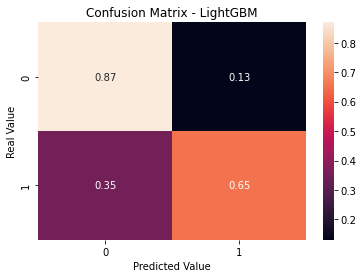

In [202]:
# final LightGBM model
lgb = LGBMClassifier(learning_rate=0.1, max_depth=35, num_leaves=170, silent=False, scale_pos_weight = 8, min_data_in_leaf= 100)

lgb.fit(X_train2, y_train2)

# prediction
y_pred_lgb = lgb.predict(X_test)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

The model performance is disappointing for precision on the test set. However, it is not the end. There is still one more strategy to deal with imbalanced problems - changing the probability threshold to favour precision. 

But first, in order to set the optimal probability, we need to check if our model is well calibrated towards the true probability. 

# Model Calibration

As one of the short answer questions alluded to, model calibration is important to create smoother credit score to probability ratios. We will use a calibration curve (aka reliability diagram) to check if our probability distribution is over or under estimated. 

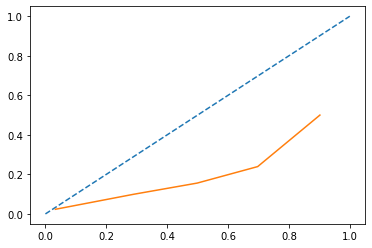

In [264]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
y_proba = lgb.predict_proba(X_test)[:, 1]
y_means, proba_means = calibration_curve(y_test, y_proba, 10, strategy = 'uniform')

plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)

The calibration curve shows a pretty severe underestimation, and we will need to use a calibrator, in this case Isotonic Regression to bring our distribution closer to the true probability. 

In [230]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

isotonic = CalibratedClassifierCV(lgb, cv=5, method= 'isotonic')
isotonic.fit(X_train2, y_train2)
calibrated_yhat = isotonic.predict_proba(X)[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 906, number of negative: 6042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 6948, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130397 -> initscore=-1.897451
[LightGBM] [Info] Start training from score -1.897451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 907, number of negative: 6042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5043
[LightGBM] [Info] Number of data points in the train set: 6949, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130522 -> initscore=-1.896348
[LightGBM] [Info] Start training from score -1.896348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 907, number of negative: 6042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5052
[LightGBM] [Info] Number of data points in the train set: 6949, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130522 -> initscore=-1.896348
[LightGBM] [Info] Start training from score -1.896348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

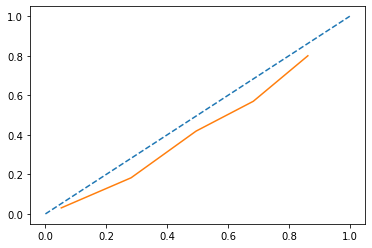

In [247]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
y_proba = isotonic.predict_proba(X_test)[:, 1]
y_means, proba_means = calibration_curve(y_test, y_proba, 10, strategy = 'uniform')

plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)

After applying Isotonic Regression, and rescaling our probability distribution, we are now closer to the true probability line

# Threshold-setting for Best Business Value

Now that we have our rescaled probability distribution, we can check different threshold levels to find the one that optimises for business value. How do we do this? 

We can run a simple simulation on the test set with certain price and cost assumptions, and see if our model can create more profit than the baseline (giving everyone a loan) 

In [287]:
# assumptions

cost_of_default = 328 # I'll use the USD value

interest_rate = 0.02 # I searched for Gojek's lending interest rate, but I could only find that it was between 1%-4%, depending on the size of the loan. 

In [285]:
df_simul = df[['calibrated_prob', 'user_id', 'outstanding']]

In [302]:
df_simul['interest_rate'] = pd.qcut(df_simul['outstanding'], 4, labels = [0.01, 0.02, 0.03, 0.04]).astype(float)

In [304]:
df_simul['expected_profit'] = df_simul['interest_rate']* df['outstanding']

In [265]:
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
 
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds_list = []

# predict probabilities
yhat = isotonic.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
recall = [recall_score(y_test, to_labels(probs, t)) for t in thresholds]
precision = [precision_score(y_test, to_labels(probs, t)) for t in thresholds]

for t in thresholds:thresholds_list.append(thresholds)
# get best threshold
ix = argmax(precision)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], precision[ix]))

Threshold=0.825, F-Score=1.00000


The other way to determine a threshold is to see if management has a minimum precision target e.g..0.6, and then finding the threshold to achieve that value

In [266]:
for t in thresholds: 
    threshold_target = 0.6
    recall = recall_score(y_test, to_labels(probs, t)) 
    precision = precision_score(y_test, to_labels(probs, t)) 
    
    if precision <threshold_target :
        
        continue
        
    elif precision >= threshold_target :
        
        print(t)
        break
            

0.562


# Final Model Performance on Test Set

Using our new probability threshold, we will assess the final model result on the test set

In [277]:
# predict probabilities
yhat = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
t = 0.825

y_pred_xgb = to_labels(probs, t)

report = classification_report(y_test, y_pred_xgb, output_dict= True )

In [278]:
report

{'0.0': {'precision': 0.946927374301676,
  'recall': 0.9529163738580464,
  'f1-score': 0.9499124343257442,
  'support': 2846},
 '1.0': {'precision': 0.49433962264150944,
  'recall': 0.4628975265017668,
  'f1-score': 0.47810218978102187,
  'support': 283},
 'accuracy': 0.908596995845318,
 'macro avg': {'precision': 0.7206334984715927,
  'recall': 0.7079069501799066,
  'f1-score': 0.7140073120533831,
  'support': 3129},
 'weighted avg': {'precision': 0.9059934229690372,
  'recall': 0.908596995845318,
  'f1-score': 0.9072399193988806,
  'support': 3129}}

In [269]:
results = lgb.predict_proba(X)[:, 1]

In [270]:
results

array([5.27684838e-01, 6.74639761e-03, 7.79834715e-04, ...,
       1.95257025e-04, 8.62803970e-02, 2.57045960e-03])

In [271]:
df['orig_prob'] = results

In [272]:
df['calibrated_prob'] = calibrated_yhat

In [273]:
df['class_predicted'] = df['orig_prob'].apply(lambda x: 1 if x > t else 0)

In [274]:
df.to_csv('processed_data/df_modelled.csv')

Conclusion
The main objective of this article was to build a machine learning algorithm that would be able to identify potential defaulters and therefore reduce company loss. The best model possible would be the one that could minimize false negatives, identifying all defaulters among the client base, while also minimizing false positives, preventing clients to be wrongly classified as defaulters.

Meeting these requirements can be quite tricky as there is a tradeoff between precision and recall, meaning that increasing the value of one of these metrics often decreases the value of the other. Considering the importance of minimizing company loss, we decided to give more emphasis on reducing false positives, searching for the best hyperparameters that could increase the recall rate.

Among the three Gradient Boosting Algorithms tested, XGBoost yielded the best results, with a recall rate of 81%, although it delivered an undesired 56% of false positives. On the other hand, LightGBM and CatBoost delivered a better count of false positives, with 38% and 33% respectively, but their false negatives were substantially higher than that of XGBoost, resulting in a weaker recall rate.

This article presents a classic evaluation metrics dilemma. In this case, it would be up to the company's decision-makers to analyze the big picture, with the aid of the machine learning algorithms, and decide the best plan to follow. Of course, in a future article, we can test a different approach to achieve a more desirable result, such as taking advantage of deep learning models.